## Problem Statement

### Business Context

Renewable energy sources play an increasingly important role in the global energy mix, as the effort to reduce the environmental impact of energy production increases.

Out of all the renewable energy alternatives, wind energy is one of the most developed technologies worldwide. The U.S Department of Energy has put together a guide to achieving operational efficiency using predictive maintenance practices.

Predictive maintenance uses sensor information and analysis methods to measure and predict degradation and future component capability. The idea behind predictive maintenance is that failure patterns are predictable and if component failure can be predicted accurately and the component is replaced before it fails, the costs of operation and maintenance will be much lower.

The sensors fitted across different machines involved in the process of energy generation collect data related to various environmental factors (temperature, humidity, wind speed, etc.) and additional features related to various parts of the wind turbine (gearbox, tower, blades, break, etc.).



## Objective
“ReneWind” is a company working on improving the machinery/processes involved in the production of wind energy using machine learning and has collected data of generator failure of wind turbines using sensors. They have shared a ciphered version of the data, as the data collected through sensors is confidential (the type of data collected varies with companies). Data has 40 predictors, 20000 observations in the training set and 5000 in the test set.

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost.
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Train.csv - To be used for training and tuning of models.
- Test.csv - To be used only for testing the performance of the final best model.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [1]:
# Installing the libraries with the specified version.
!pip install pandas==1.5.3 numpy==1.25.2 matplotlib==3.7.1 seaborn==0.13.1 scikit-learn==1.2.2 imbalanced-learn==0.10.1 xgboost==2.0.3 threadpoolctl==3.3.0 -q --user

**Note:** After running the above cell, kindly restart the notebook kernel and run all cells sequentially from the start again.

In [2]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier

# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    make_scorer,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To oversample and undersample data
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.2f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")

## Loading the dataset

In [3]:
# reading csv files into seperate pandas Dataframes
train = pd.read_csv('Train.csv.csv')
test = pd.read_csv('Test.csv.csv')

# print the shape of both Dataframes
print(train.shape)
print(test.shape)

# copying data to another variable to preserve original training data
df_train = train.copy()
df_test = test.copy()

(20000, 41)
(5000, 41)


## Observations

- Both training and testing dataframes have a total of 41 columns
- The training data has the majority of observations at 20,000
- The test data has a smaller number of observations at 5,000

## Exploratory Data Analysis (EDA)

In [4]:
# print a sample of five randomly selected rows from the training data
df_train.sample(n=5)

V1    V2    V3    V4    V5    V6    V7    V8    V9   V10   V11   V12  \
17764 -3.80 -2.85 -1.46 -1.51  0.59  2.27 -1.21 -1.42 -2.76  2.35  0.18 -0.10   
13043 -1.97  4.95  2.15  0.22  2.75  0.74 -0.83 -2.92  0.93 -2.95 -1.36  0.77   
3843  -1.99  0.28  0.25 -3.03  0.82  0.69 -0.77 -1.97  0.29 -1.07 -1.16  2.86   
11175  1.29  2.21  9.80  0.81  0.77 -3.26 -1.25 -3.14  2.07  1.36 -9.82 -0.63   
9325   2.54  1.44  6.39  1.09 -1.31 -2.11 -1.11 -2.66  0.85  1.41 -4.29  1.24   

        V13   V14   V15   V16   V17  V18   V19   V20   V21   V22   V23   V24  \
17764 -3.96 -0.50  0.39 -0.84  0.21 3.74  0.61 -0.37  1.97  0.32 -0.60  4.10   
13043  0.76 -3.54 -3.81 -4.35  0.99 2.82 -1.33 -3.23 -3.07  0.15 -0.84  2.13   
3843   2.86 -1.08 -4.10 -3.55 -0.67 4.23 -1.83 -0.85 -2.56  1.62  1.26 -0.72   
11175  1.37 -1.00 -1.39 -8.13  1.94 1.02  1.46  2.67 -5.66 -0.22 -7.02 -0.51   
9325   1.59 -1.97 -2.51 -8.01 -0.36 0.49  4.74  0.10 -8.07  2.18 -3.37  2.17   

        V25   V26   V27   V28   V29   V30   V31   V32   V33   V34   V35   V36  \
17764 -0.96 -3.75 -1.14  1.92  1.71  2.57 -0.54  1.24  3.27  0.79  0.47  1.79   
13043 -1.54  6.69 -4.41 -1.65  1.16  0.25 -0.32 -0.35  3.36 -3.77  0.12 -0.70   
3843  -0.50  1.52  0.02 -1.33 -0.67 -0.33 -2.15 -2.77 -0.10 -1.25 -1.51  2.72   
11175  4.99  5.25  3.44 -1.12 -7.68 -9.91  4.62 -5.66 -7.40  1.68 -0.45  7.97   
9325   1.78  3.38  1.68 -0.67 -3.67 -2.47  1.27 -1.45 -1.97  0.81  5.36  2.23   

        V37   V38  V39   V40  Target  
17764  0.60  4.01 0.98  0.37       0  
13043  0.37  3.45 0.91  1.29       0  
3843   2.23  1.59 2.55  0.89       0  
11175 -0.41 -1.66 3.94 -0.76       0  
9325  -1.56  0.60 1.39 -2.96       0

In [5]:
# print the statistical summary of the numerical columns in the training data
df_train.describe().T

count  mean  std    min   25%   50%   75%   max
V1     19982.00 -0.27 3.44 -11.88 -2.74 -0.75  1.84 15.49
V2     19982.00  0.44 3.15 -12.32 -1.64  0.47  2.54 13.09
V3     20000.00  2.48 3.39 -10.71  0.21  2.26  4.57 17.09
V4     20000.00 -0.08 3.43 -15.08 -2.35 -0.14  2.13 13.24
V5     20000.00 -0.05 2.10  -8.60 -1.54 -0.10  1.34  8.13
V6     20000.00 -1.00 2.04 -10.23 -2.35 -1.00  0.38  6.98
V7     20000.00 -0.88 1.76  -7.95 -2.03 -0.92  0.22  8.01
V8     20000.00 -0.55 3.30 -15.66 -2.64 -0.39  1.72 11.68
V9     20000.00 -0.02 2.16  -8.60 -1.49 -0.07  1.41  8.14
V10    20000.00 -0.01 2.19  -9.85 -1.41  0.10  1.48  8.11
V11    20000.00 -1.90 3.12 -14.83 -3.92 -1.92  0.12 11.83
V12    20000.00  1.60 2.93 -12.95 -0.40  1.51  3.57 15.08
V13    20000.00  1.58 2.87 -13.23 -0.22  1.64  3.46 15.42
V14    20000.00 -0.95 1.79  -7.74 -2.17 -0.96  0.27  5.67
V15    20000.00 -2.41 3.35 -16.42 -4.42 -2.38 -0.36 12.25
V16    20000.00 -2.93 4.22 -20.37 -5.63 -2.68 -0.10 13.58
V17    20000.00 -0.13 3.35 -14.09 -2.22 -0.01  2.07 16.76
V18    20000.00  1.19 2.59 -11.64 -0.40  0.88  2.57 13.18
V19    20000.00  1.18 3.40 -13.49 -1.05  1.28  3.49 13.24
V20    20000.00  0.02 3.67 -13.92 -2.43  0.03  2.51 16.05
V21    20000.00 -3.61 3.57 -17.96 -5.93 -3.53 -1.27 13.84
V22    20000.00  0.95 1.65 -10.12 -0.12  0.97  2.03  7.41
V23    20000.00 -0.37 4.03 -14.87 -3.10 -0.26  2.45 14.46
V24    20000.00  1.13 3.91 -16.39 -1.47  0.97  3.55 17.16
V25    20000.00 -0.00 2.02  -8.23 -1.37  0.03  1.40  8.22
V26    20000.00  1.87 3.44 -11.83 -0.34  1.95  4.13 16.84
V27    20000.00 -0.61 4.37 -14.90 -3.65 -0.88  2.19 17.56
V28    20000.00 -0.88 1.92  -9.27 -2.17 -0.89  0.38  6.53
V29    20000.00 -0.99 2.68 -12.58 -2.79 -1.18  0.63 10.72
V30    20000.00 -0.02 3.01 -14.80 -1.87  0.18  2.04 12.51
V31    20000.00  0.49 3.46 -13.72 -1.82  0.49  2.73 17.26
V32    20000.00  0.30 5.50 -19.88 -3.42  0.05  3.76 23.63
V33    20000.00  0.05 3.58 -16.90 -2.24 -0.07  2.26 16.69
V34    20000.00 -0.46 3.18 -17.99 -2.14 -0.26  1.44 14.36
V35    20000.00  2.23 2.94 -15.35  0.34  2.10  4.06 15.29
V36    20000.00  1.51 3.80 -14.83 -0.94  1.57  3.98 19.33
V37    20000.00  0.01 1.79  -5.48 -1.26 -0.13  1.18  7.47
V38    20000.00 -0.34 3.95 -17.38 -2.99 -0.32  2.28 15.29
V39    20000.00  0.89 1.75  -6.44 -0.27  0.92  2.06  7.76
V40    20000.00 -0.88 3.01 -11.02 -2.94 -0.92  1.12 10.65
Target 20000.00  0.06 0.23   0.00  0.00  0.00  0.00  1.00

- Within the training dataset, the average ranges from -3.61 to 2.48
- There appear to be some missing values, which will be treated later

In [6]:
# print the data types of the columns within the training dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      19982 non-null  float64
 1   V2      19982 non-null  float64
 2   V3      20000 non-null  float64
 3   V4      20000 non-null  float64
 4   V5      20000 non-null  float64
 5   V6      20000 non-null  float64
 6   V7      20000 non-null  float64
 7   V8      20000 non-null  float64
 8   V9      20000 non-null  float64
 9   V10     20000 non-null  float64
 10  V11     20000 non-null  float64
 11  V12     20000 non-null  float64
 12  V13     20000 non-null  float64
 13  V14     20000 non-null  float64
 14  V15     20000 non-null  float64
 15  V16     20000 non-null  float64
 16  V17     20000 non-null  float64
 17  V18     20000 non-null  float64
 18  V19     20000 non-null  float64
 19  V20     20000 non-null  float64
 20  V21     20000 non-null  float64
 21  V22     20000 non-null  float64
 22

In [7]:
# checking for duplicate values
df_train.duplicated().sum()

0

- Within the training dataset, there are no duplicate values

In [8]:
# create dataset of only failures from training data
fail = df_train[df_train['Target']==1]
len(fail)

1110

In [9]:
# create dataset of only non-failures from training data
no_fail = df_train[df_train['Target']==0]

In [10]:
# calculate failure rate in the training data
len(fail)/len(df_train) * 100

5.55

- The failure rate in the training data is 5.55% of all of the observations

In [11]:
# create dataset of only failures from testing data
fail_test = df_test[df_test['Target']==1]
len(fail)

1110

In [12]:
# create dataset of only non-failures from training data
no_fail_test = df_test[df_test['Target']==0]

In [13]:
# calculate the failure rate in the testing data
len(fail_test)/len(df_test) * 100

5.64

- The failure rate in the testing data is 5.64% of all the observations
- There is a small difference in failure rate for generators in the datasets

In [14]:
diff = fail.describe().T['mean'] - no_fail.describe().T['mean']
print(diff.sort_values().head())
print(" ")
print(diff.sort_values().tail())

V36   -3.59
V18   -3.32
V3    -3.17
V26   -2.71
V31   -2.07
Name: mean, dtype: float64
 
V34   2.14
V11   2.68
V15   3.65
V21   4.00
V16   4.25
Name: mean, dtype: float64


- Failed generators stick out with largest differences in both lower and higher means of observations amongst the sensors
- ReneWind could benefit from performing a root cause analysis on these sensors, which could help in substantially lowering the failure rate of their generators

In [15]:
diff_std = fail.describe().T['std'] - no_fail.describe().T['std']
print(diff_std.sort_values().head())
print(" ")
print(diff_std.sort_values().tail())

V36   -0.94
V38   -0.55
V8    -0.55
V27   -0.54
V20   -0.34
Name: std, dtype: float64
 
V17   1.02
V24   1.08
V13   1.36
V12   1.58
V35   1.61
Name: std, dtype: float64


- Failed generators stick out with largest differences in both lower and higher standard deviation of observations amongst the sensors
- As previously mentioned, ReneWind could benefit from perfoming a root cause analysis on these sensors, which could help in substatially lowering the failure rate of their generators

### Plotting histograms and boxplots for all the variables

In [16]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the sensor values, as well as for both failures and no failures


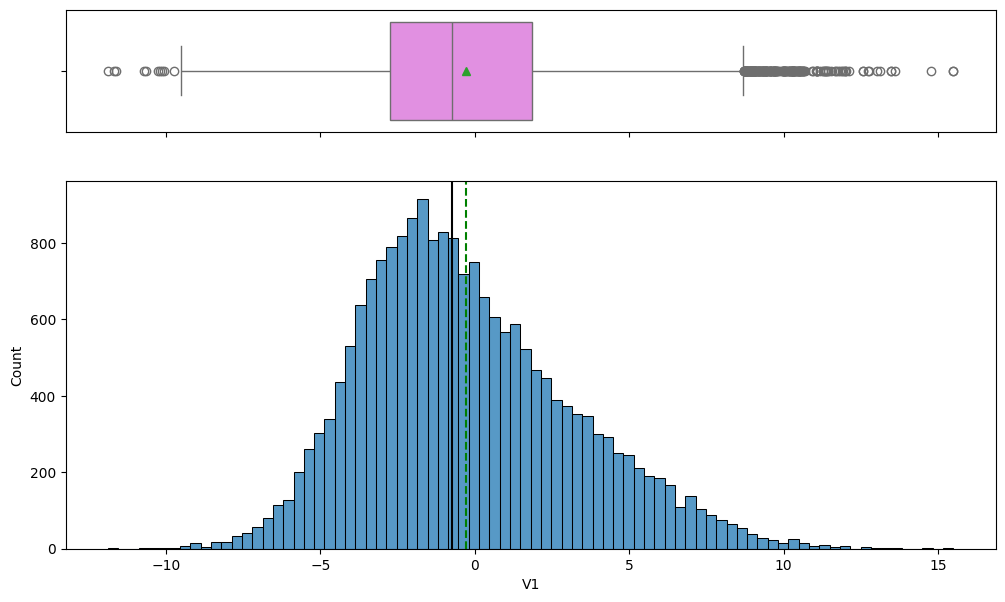

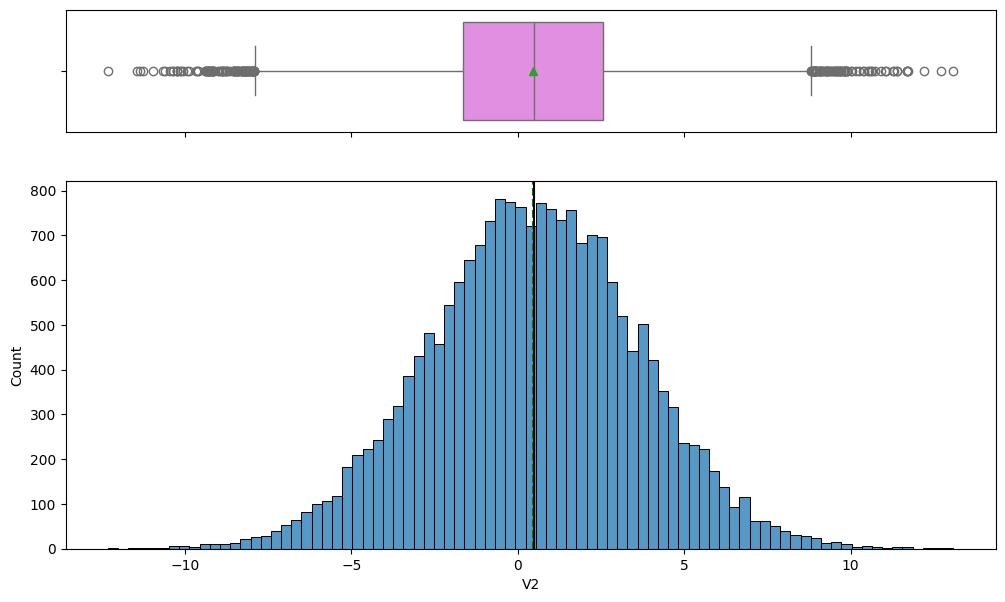

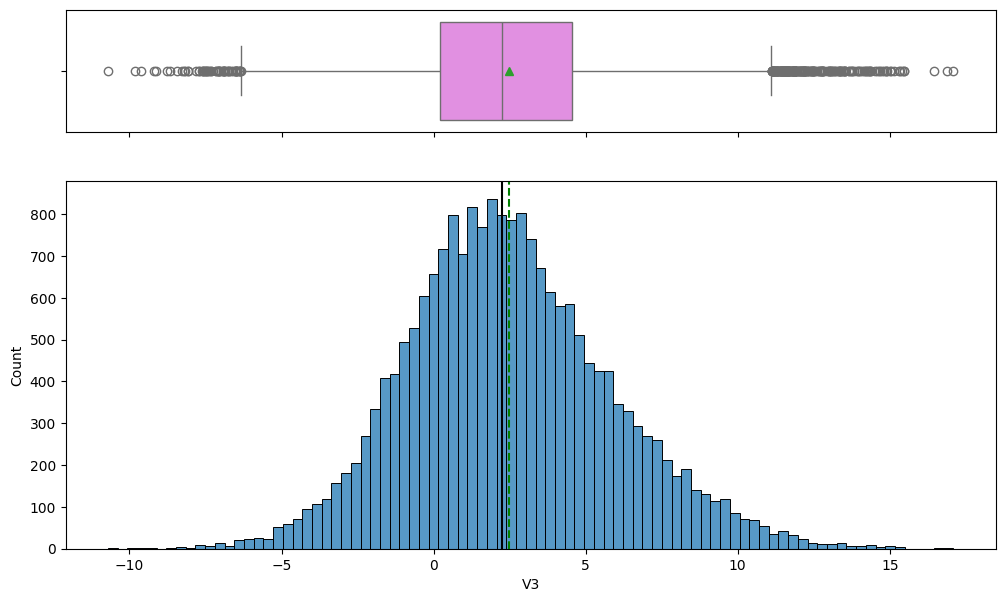

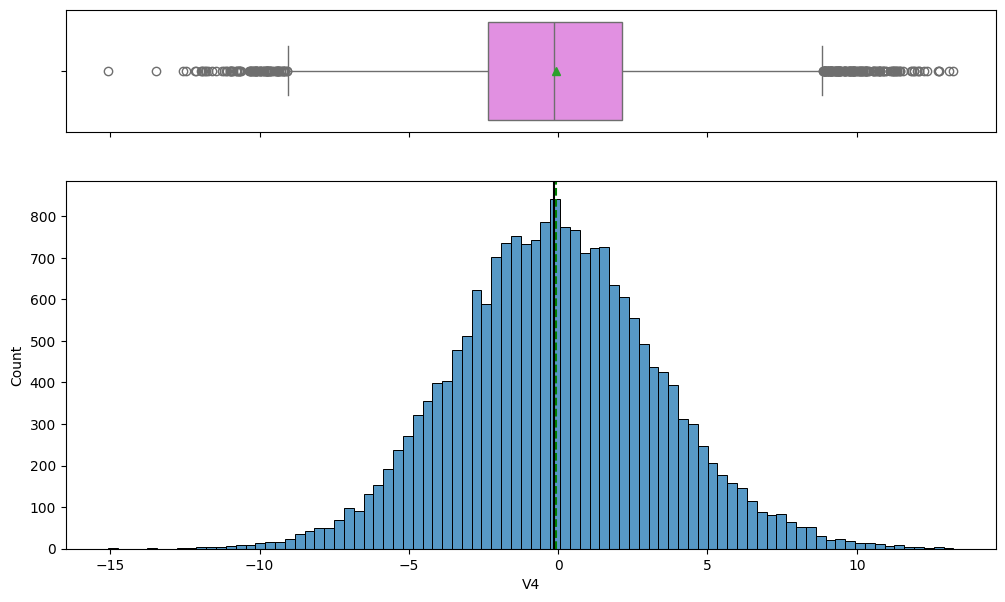

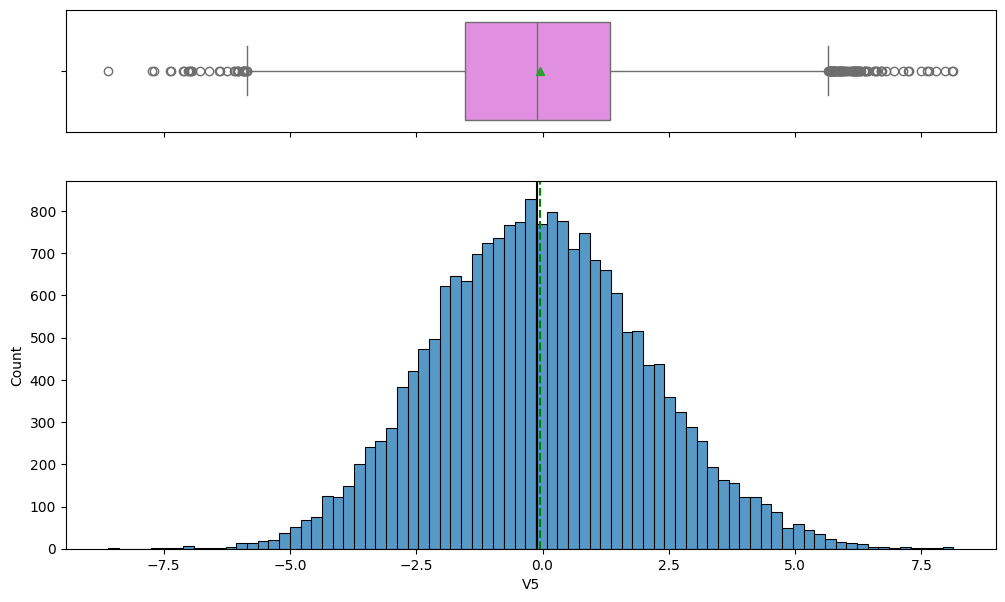

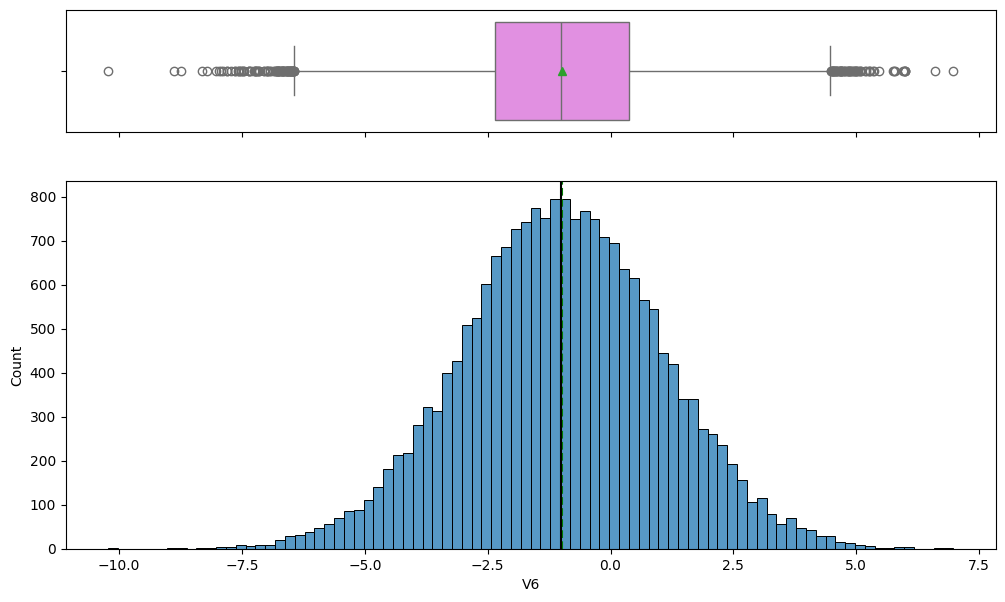

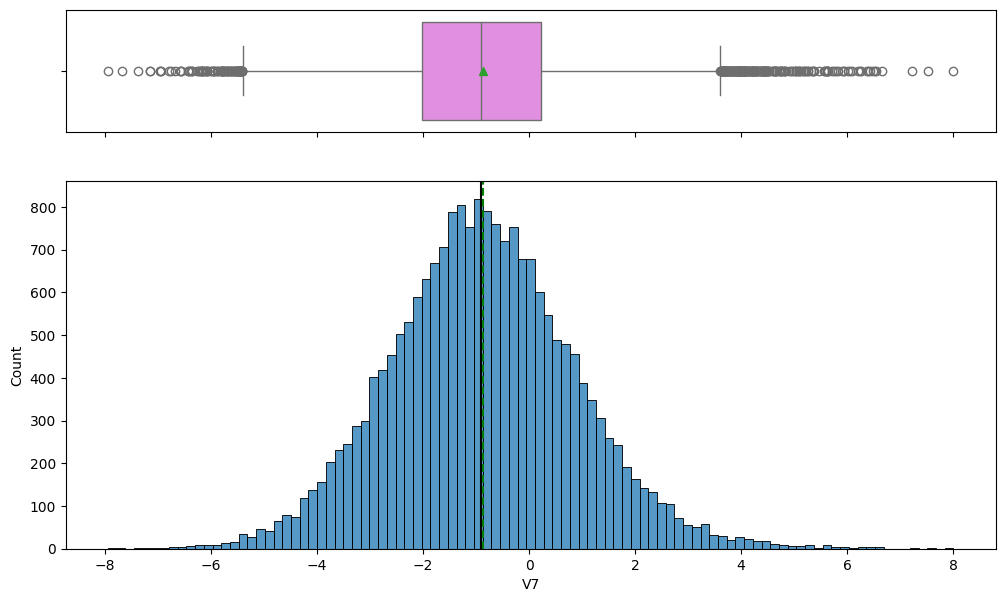

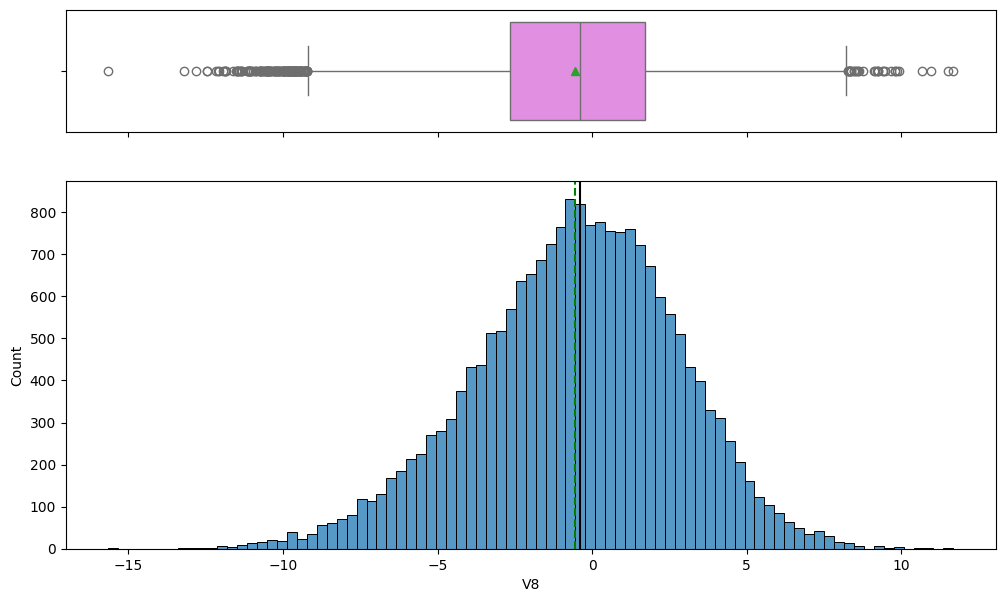

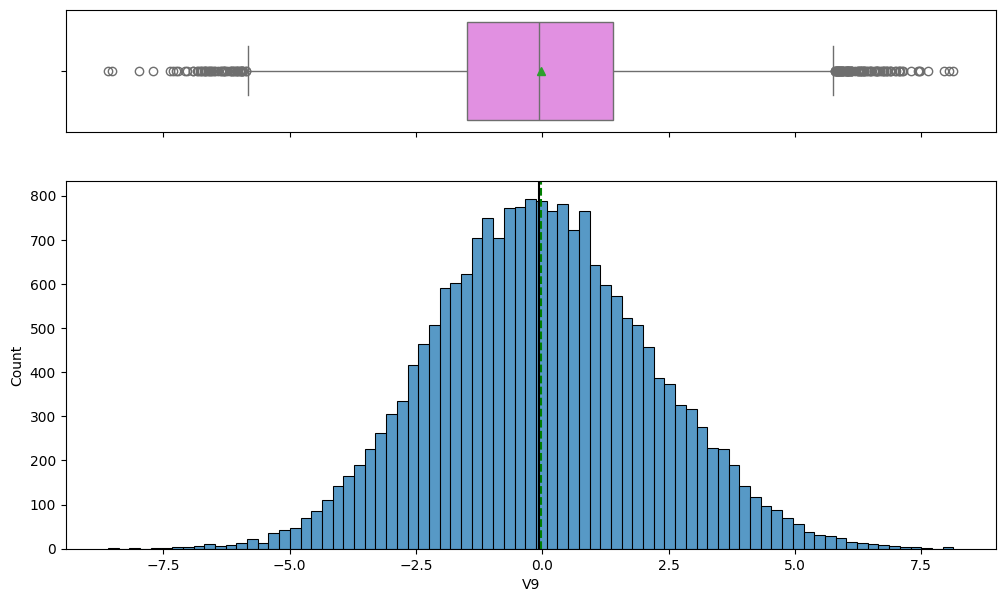

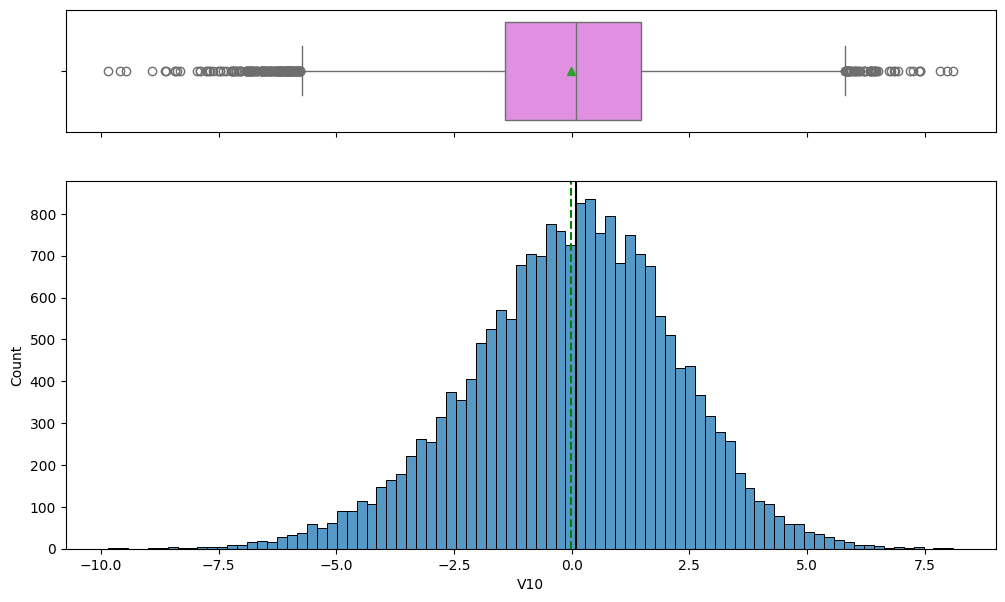

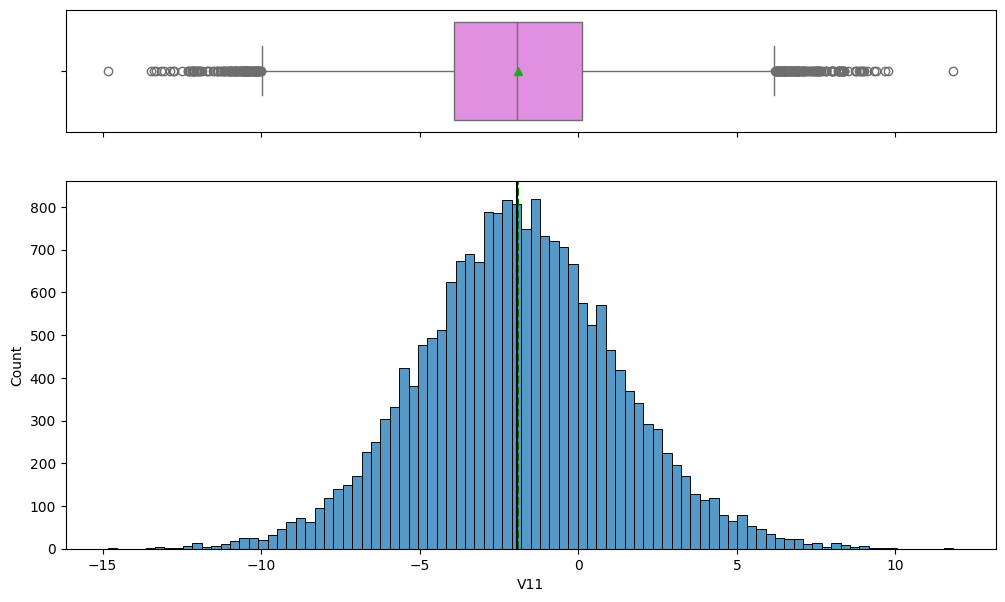

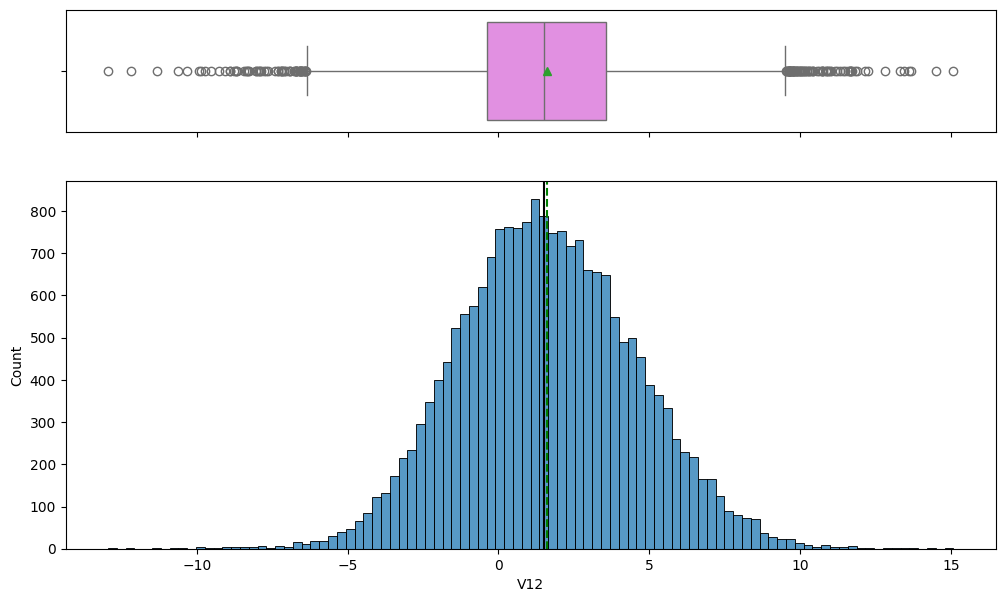

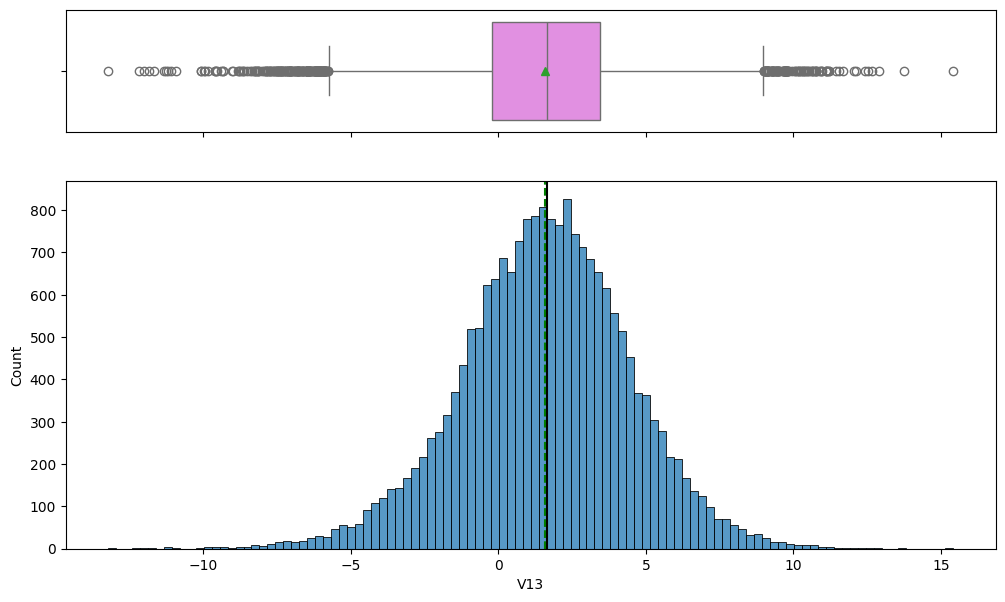

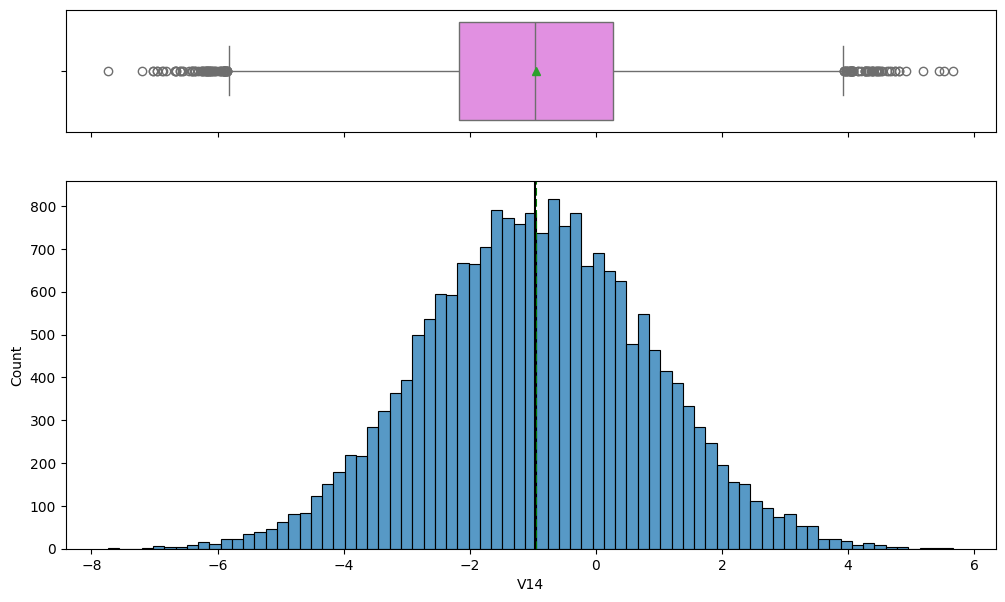

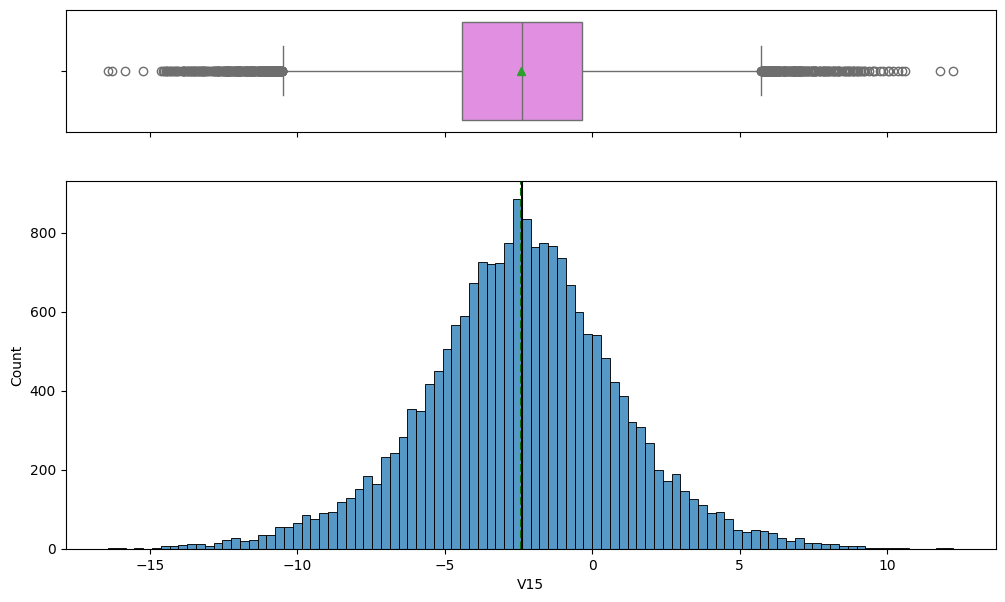

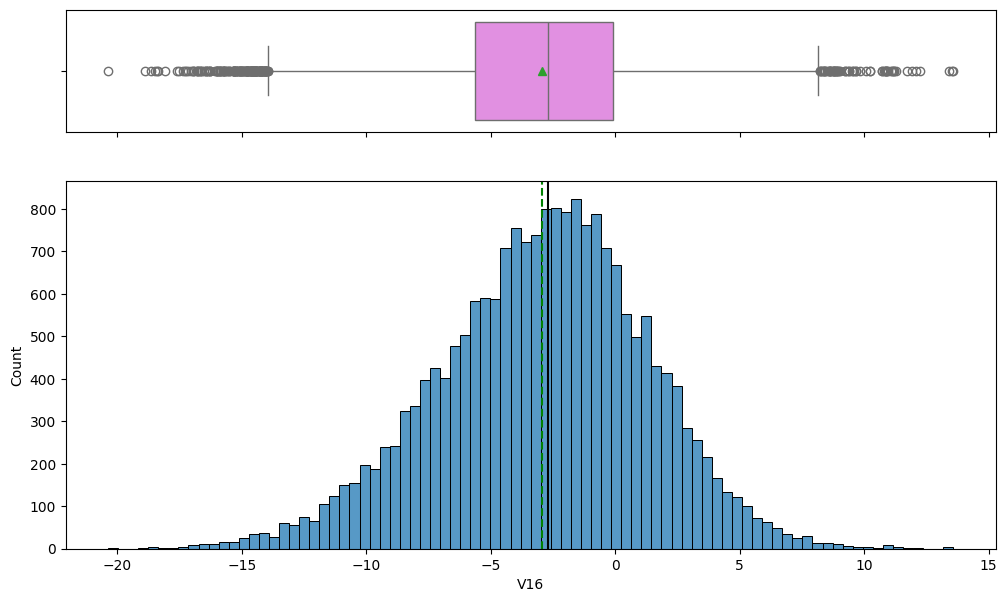

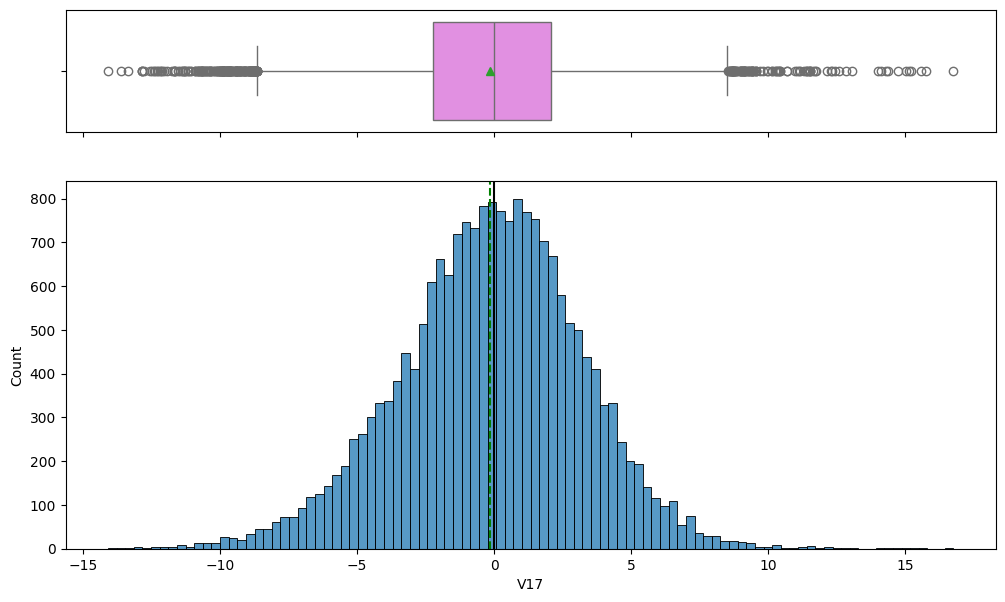

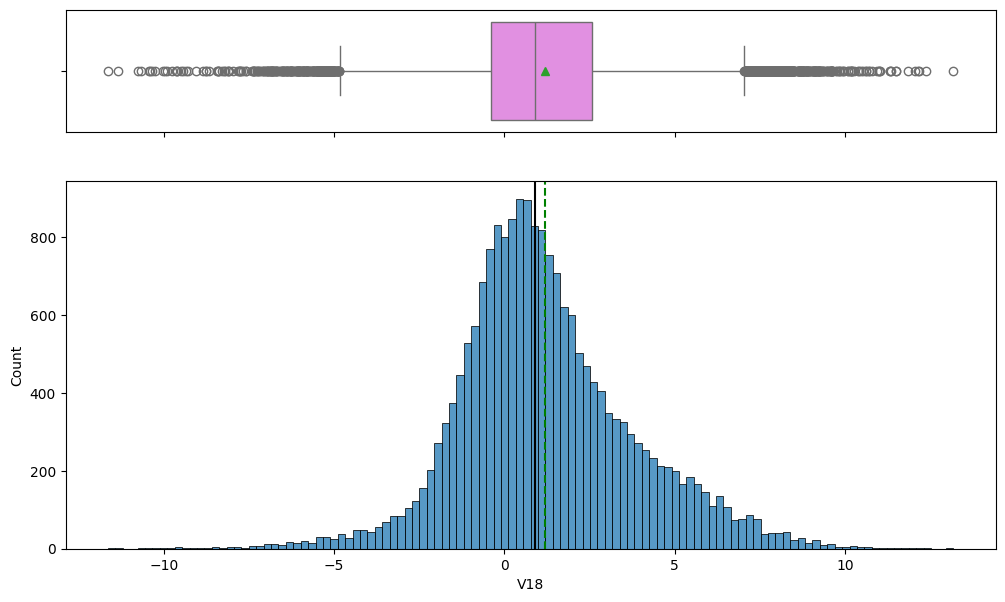

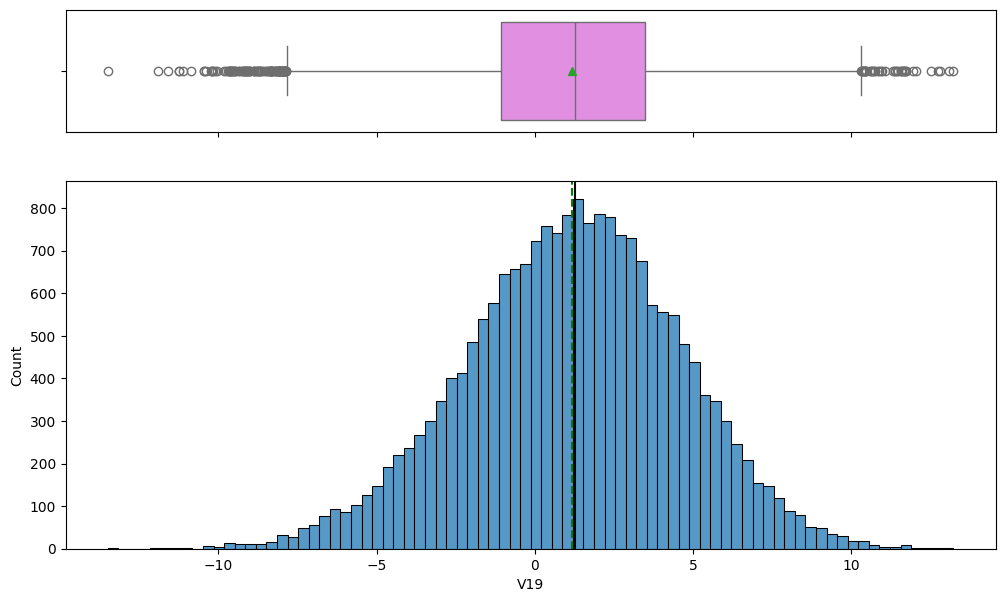

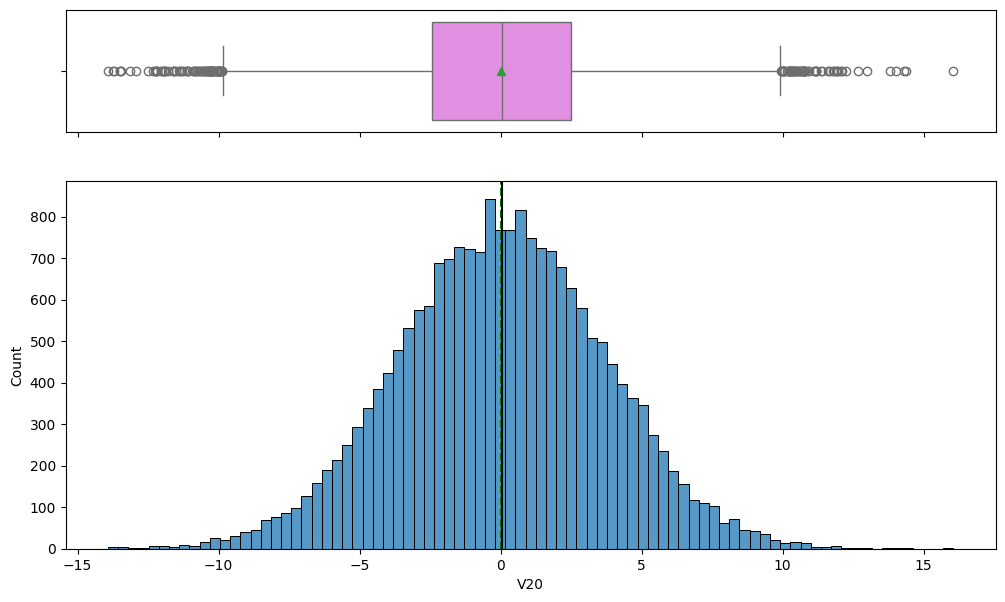

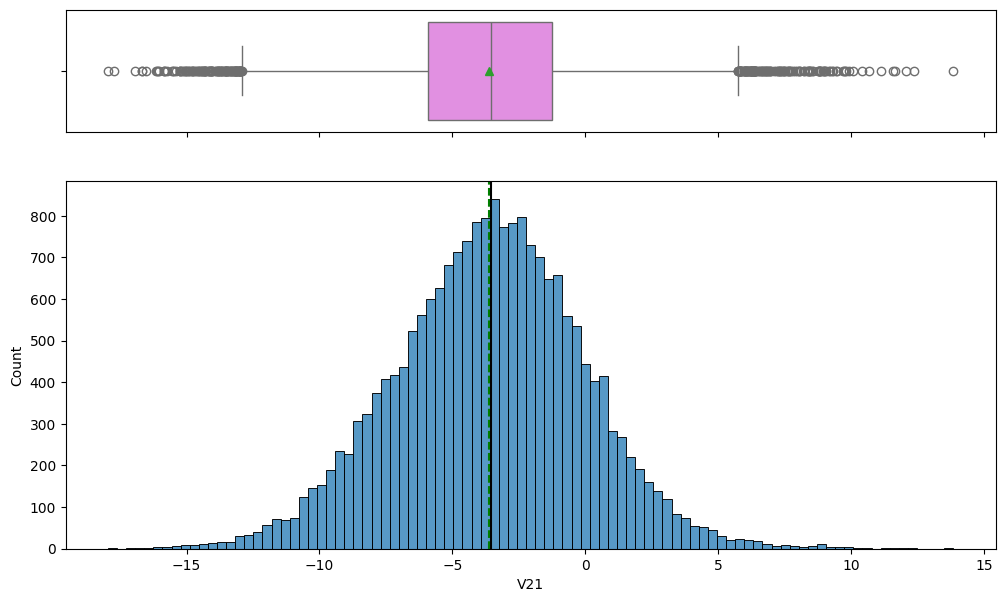

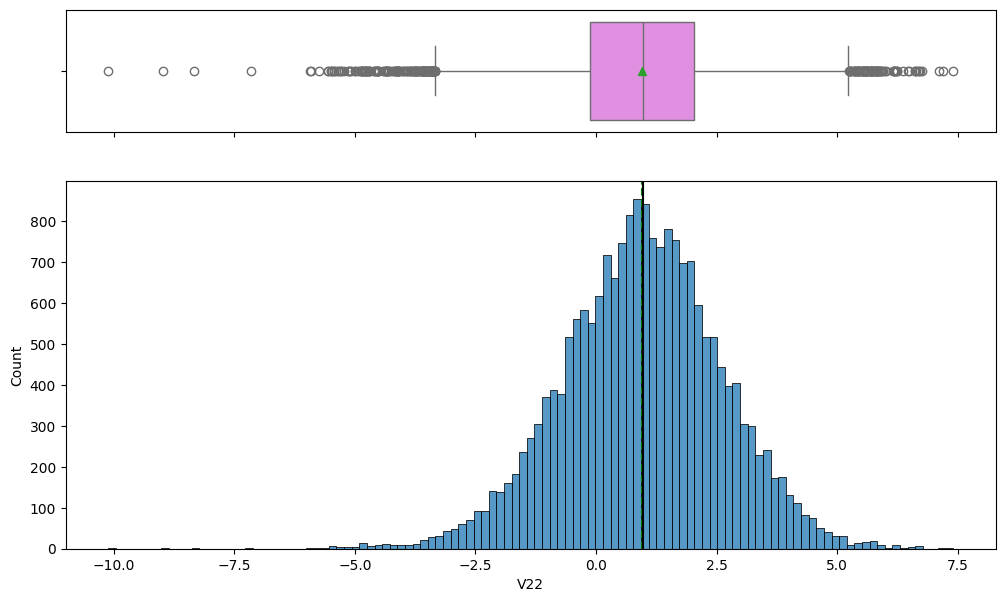

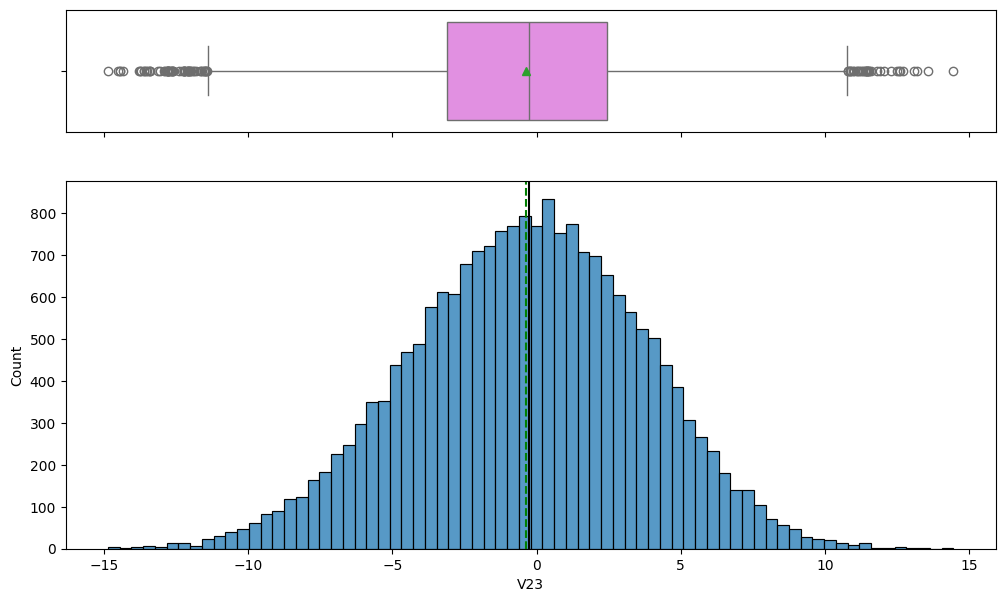

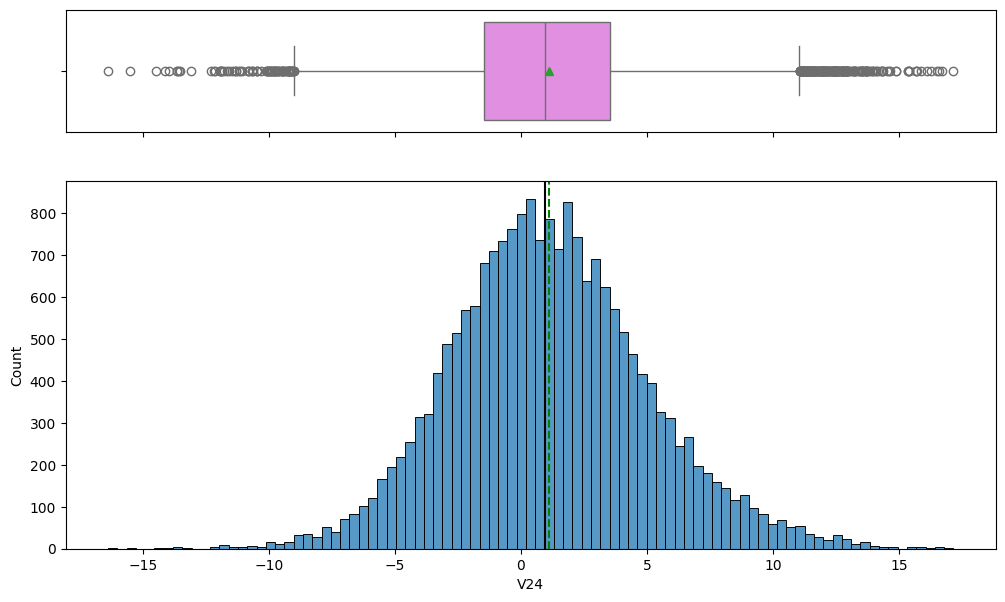

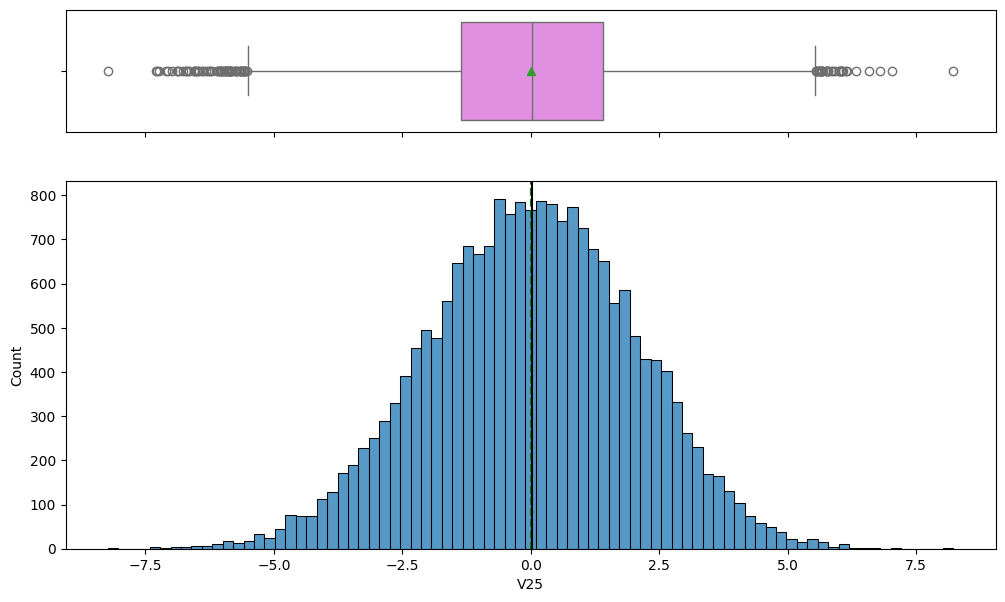

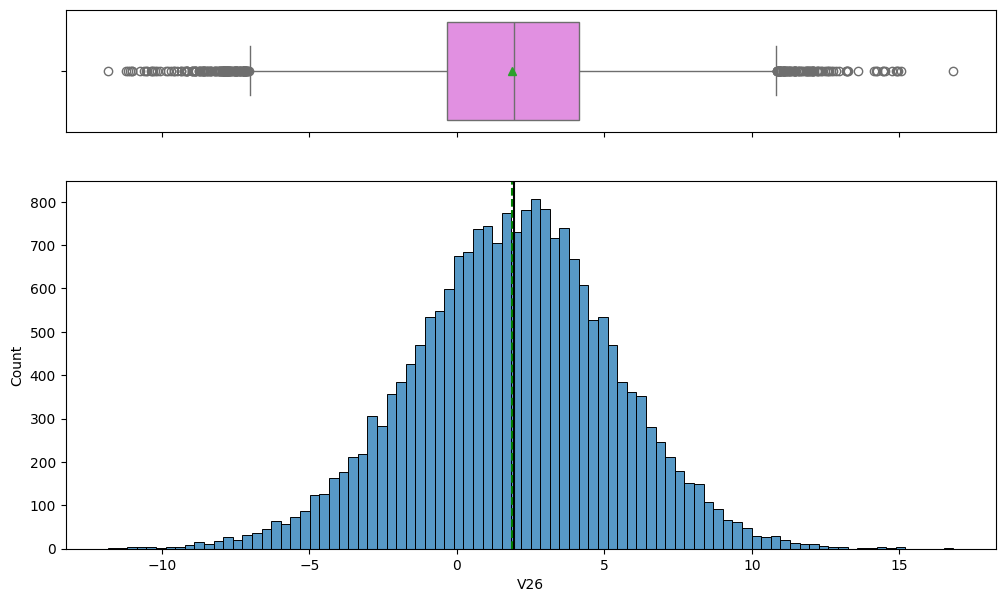

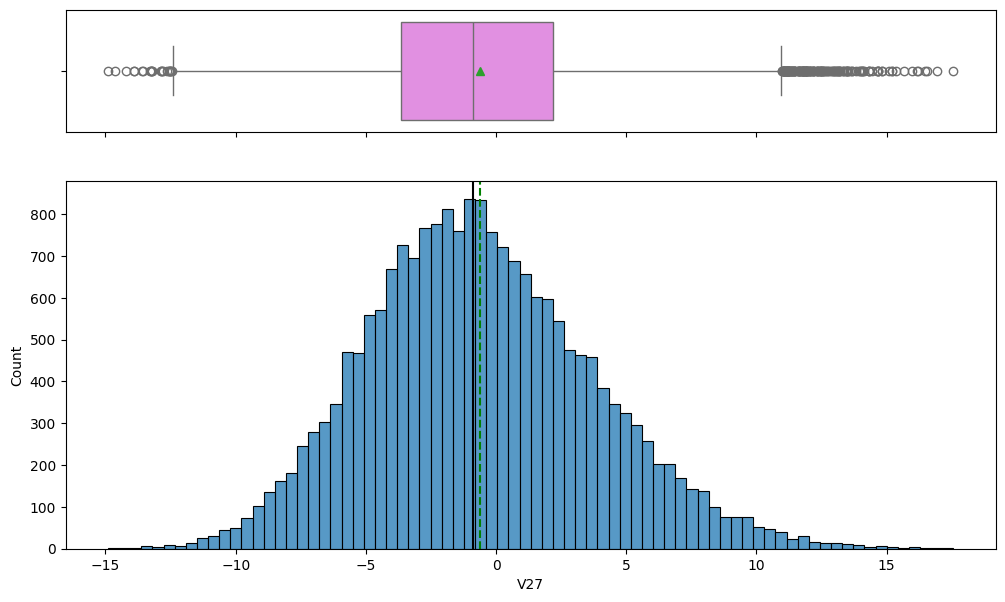

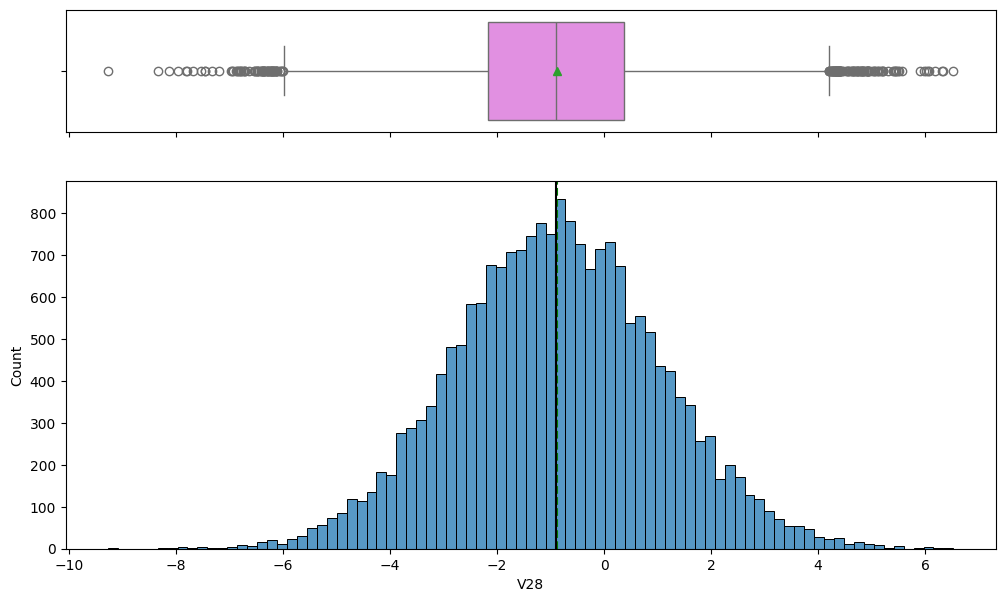

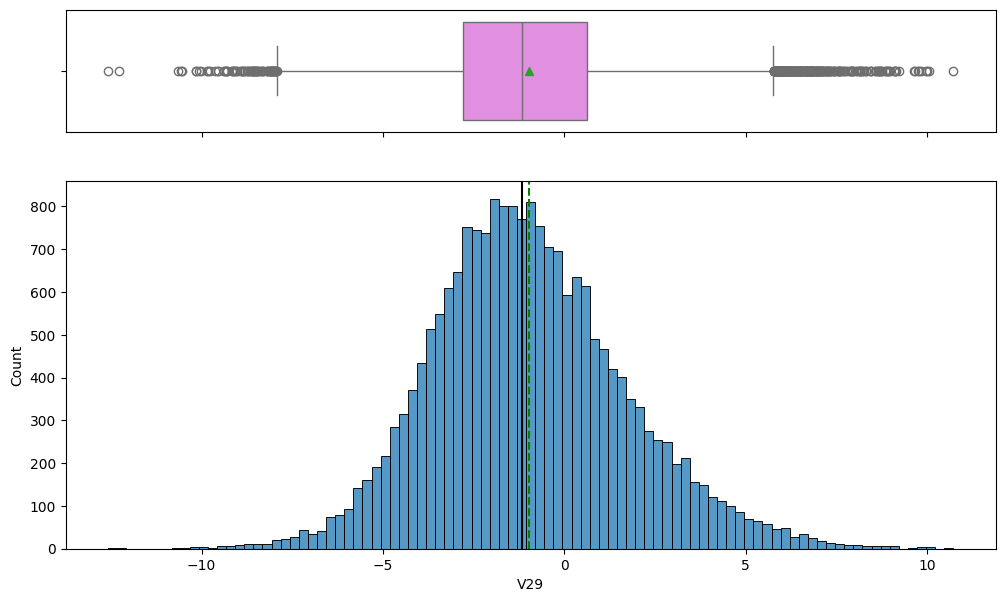

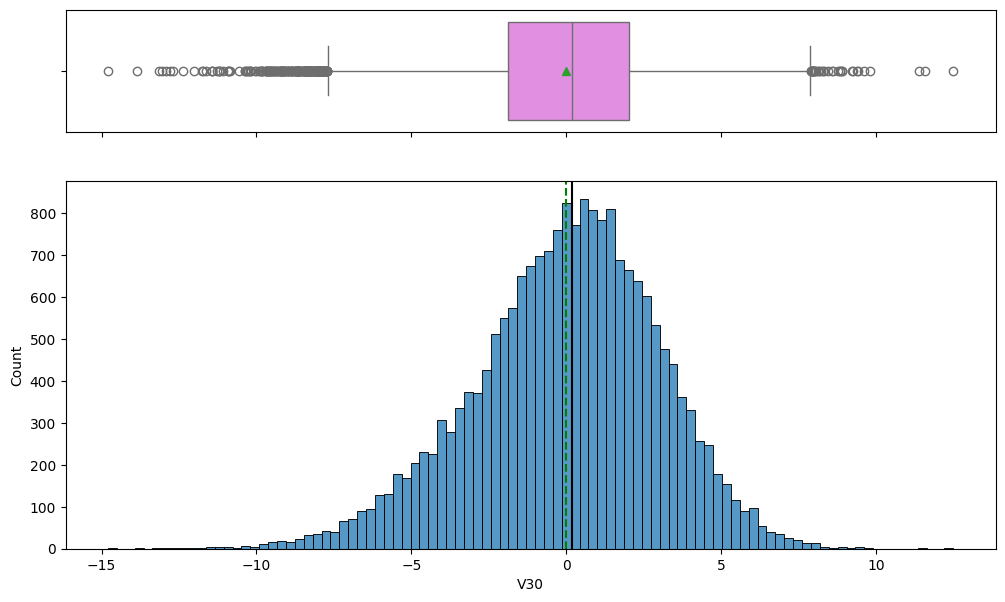

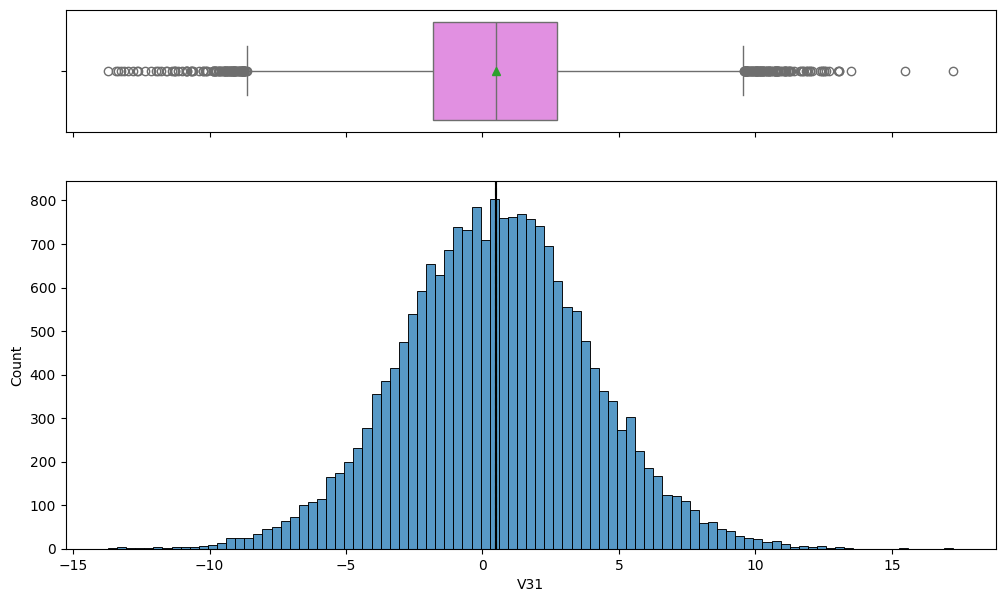

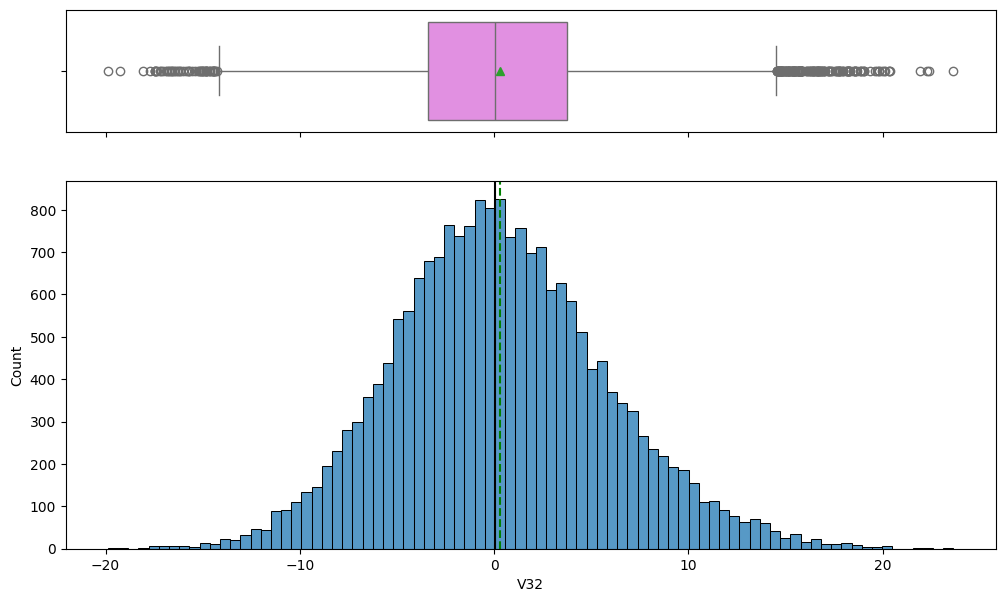

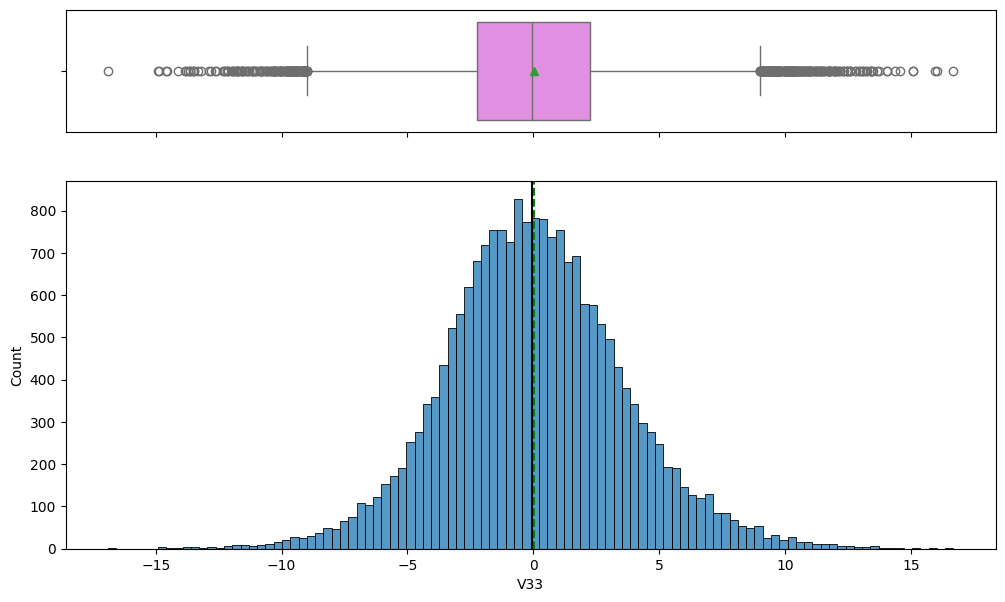

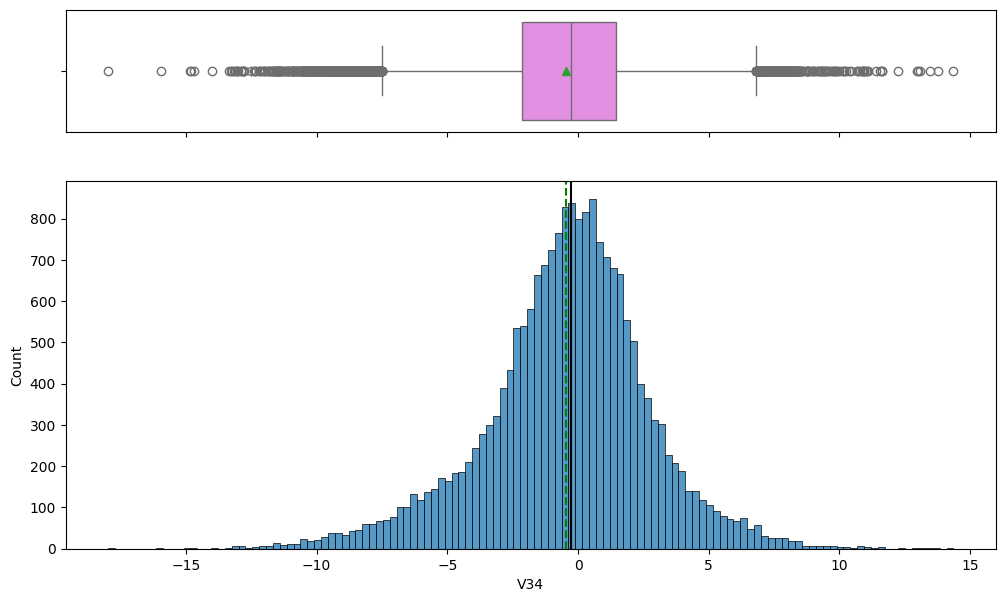

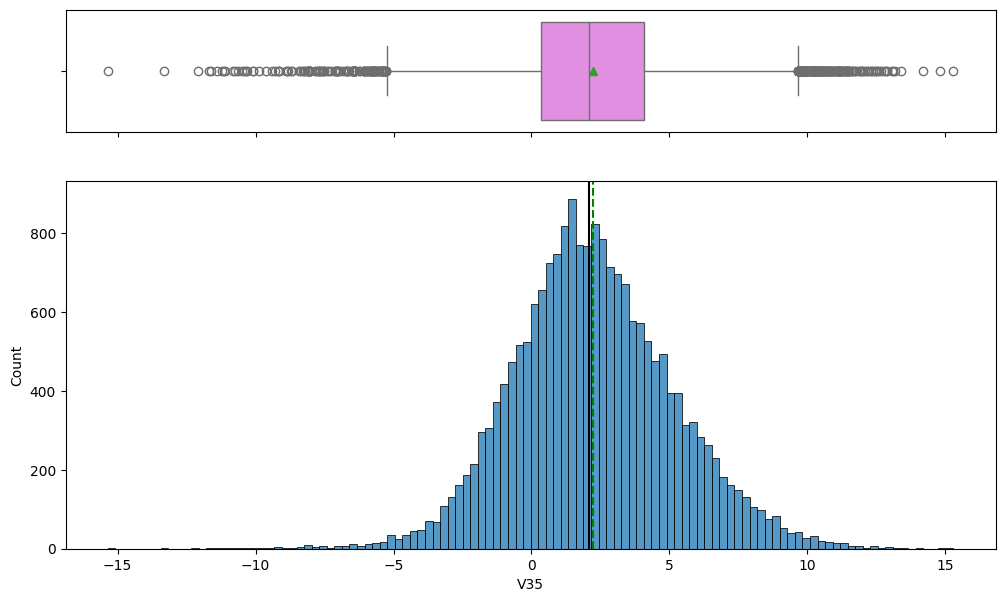

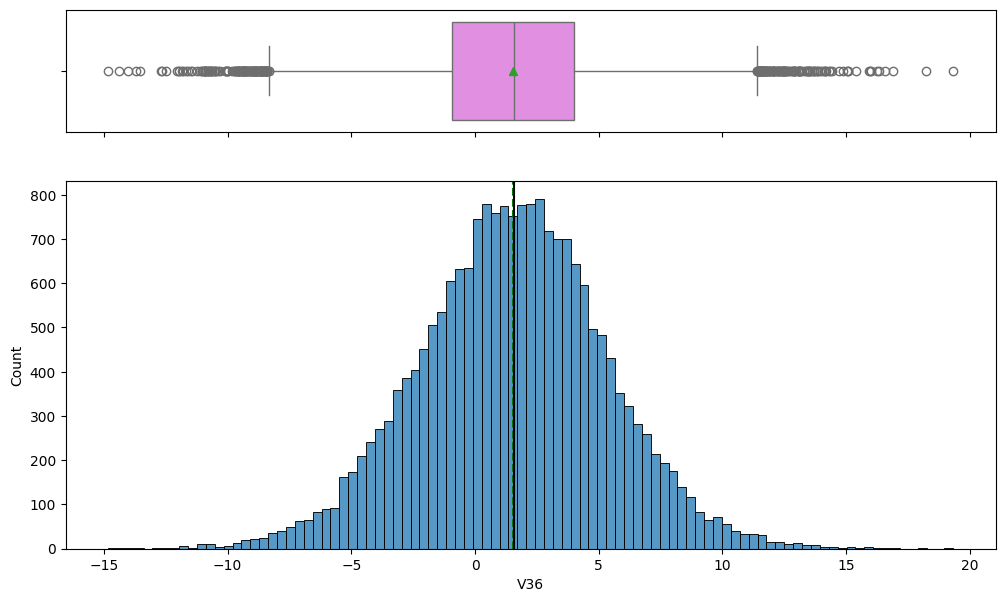

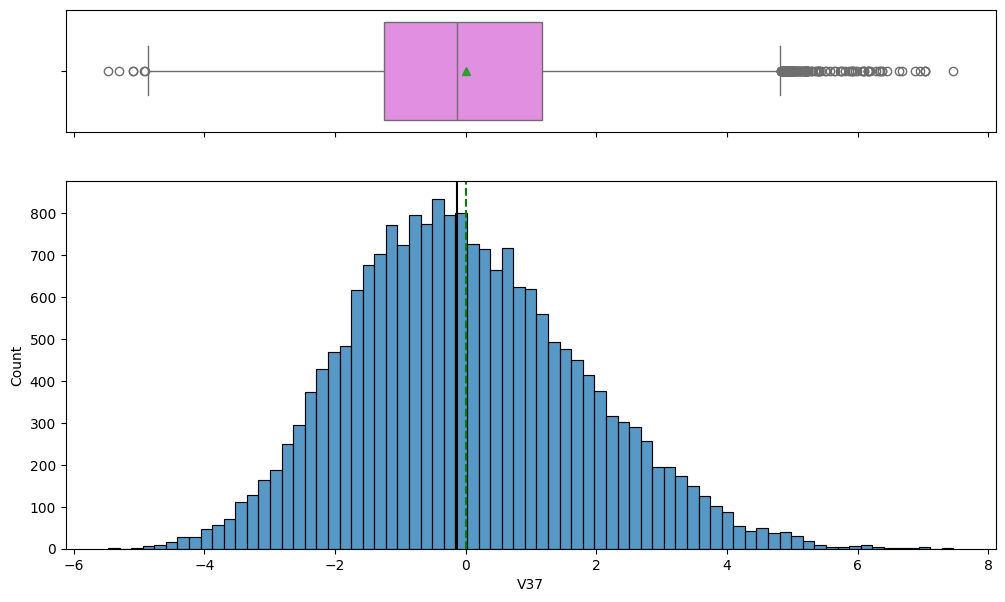

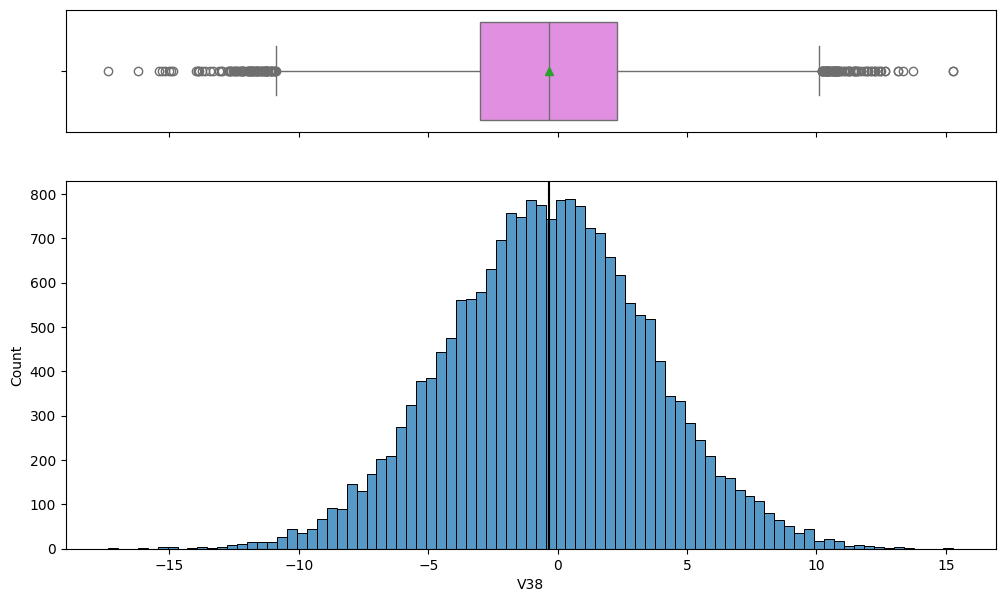

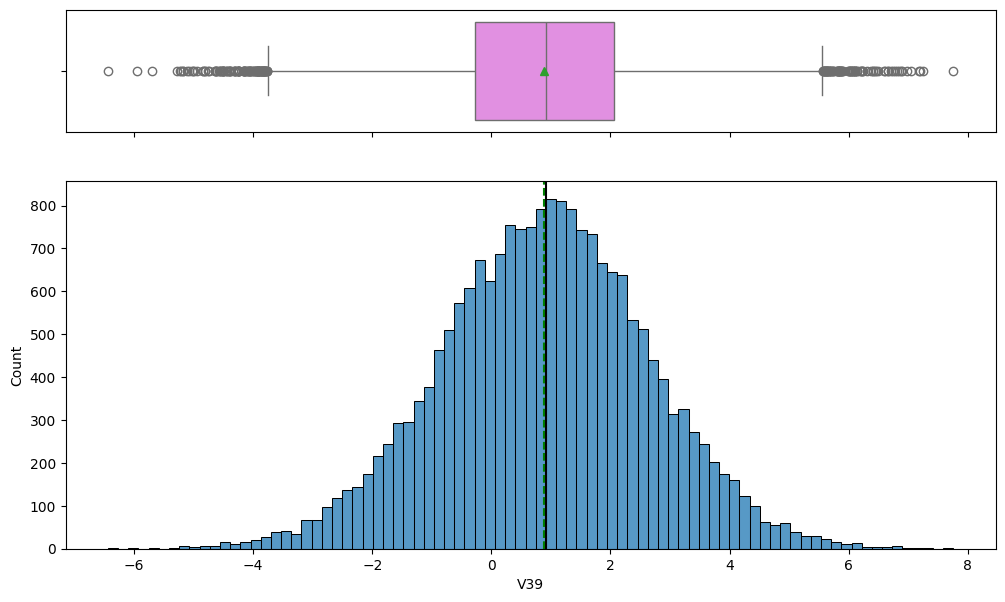

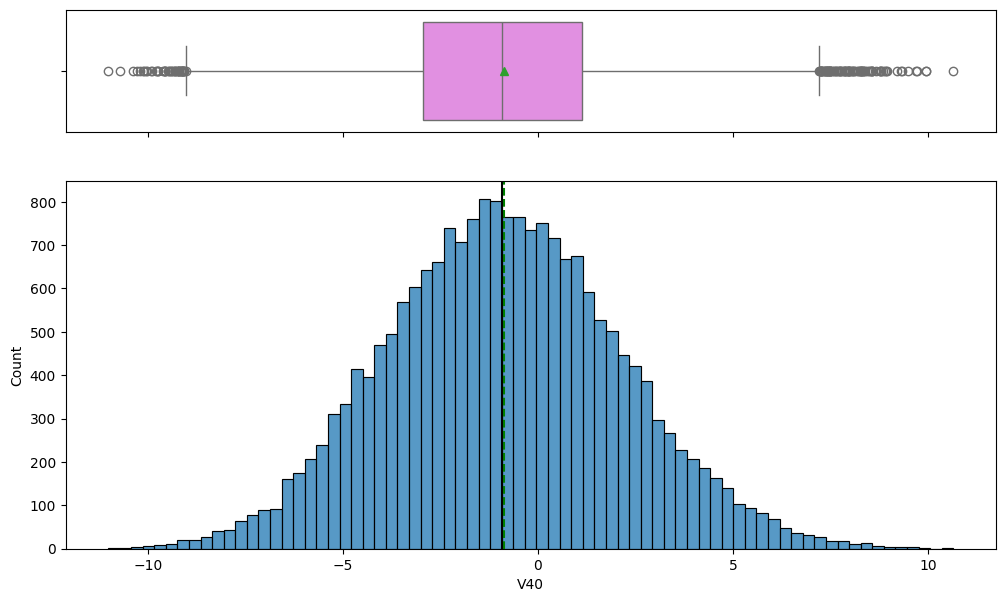

In [17]:
for feature in df_train.columns[df_train.dtypes=='float64']:
    histogram_boxplot(df_train, feature, figsize=(12, 7), kde=False, bins=None)

- Distributions for `V1`, `V18`, `V27`, `V27`, and `V30` appear right-skewed
- The remainder of the sensor variables appear normally distributed

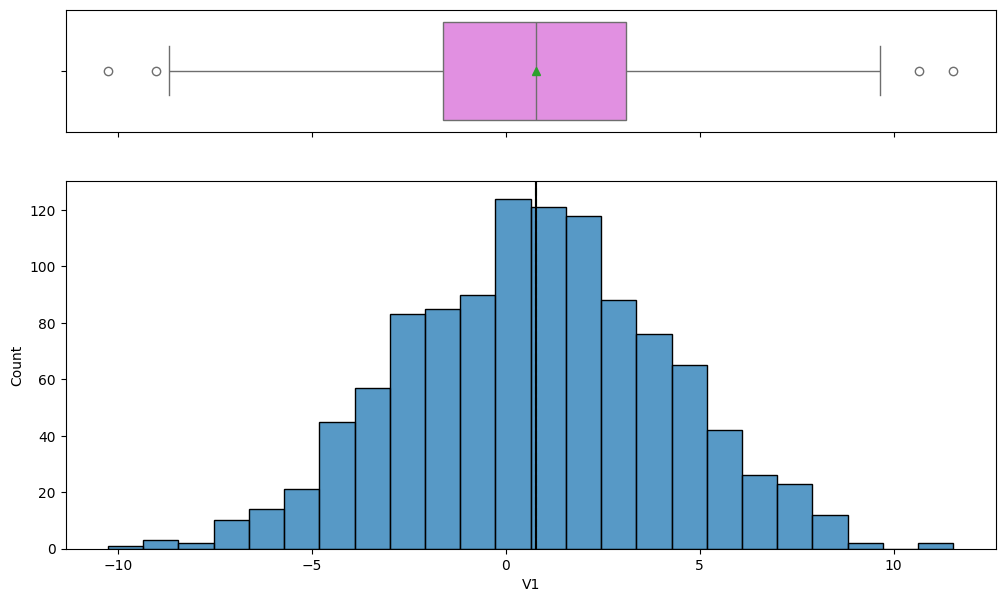

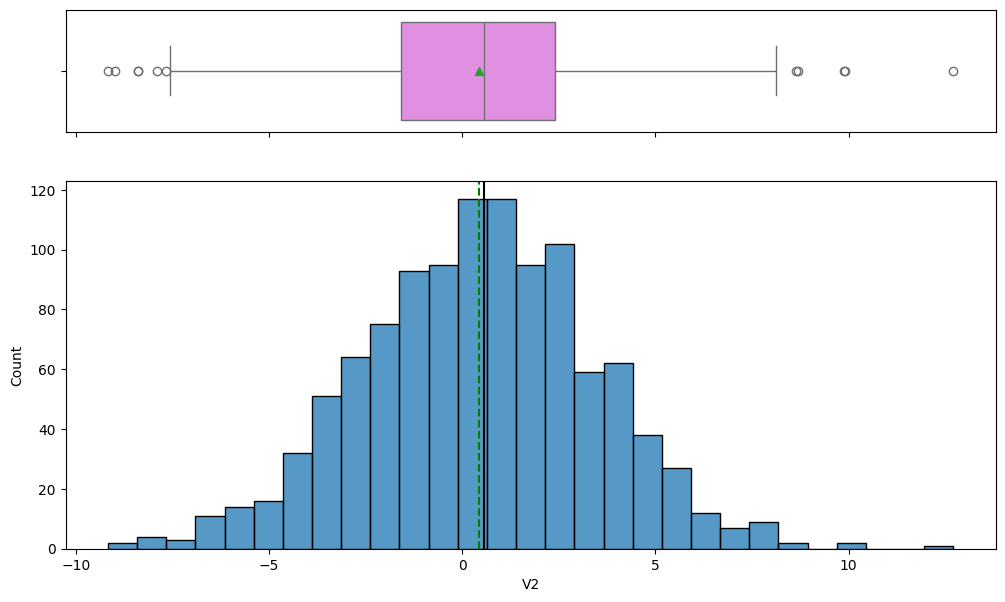

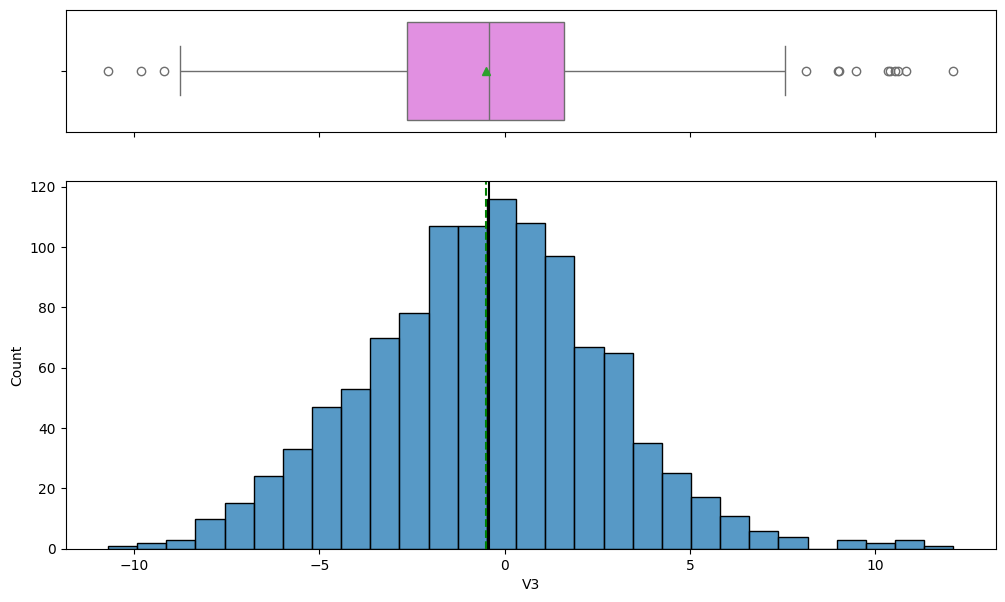

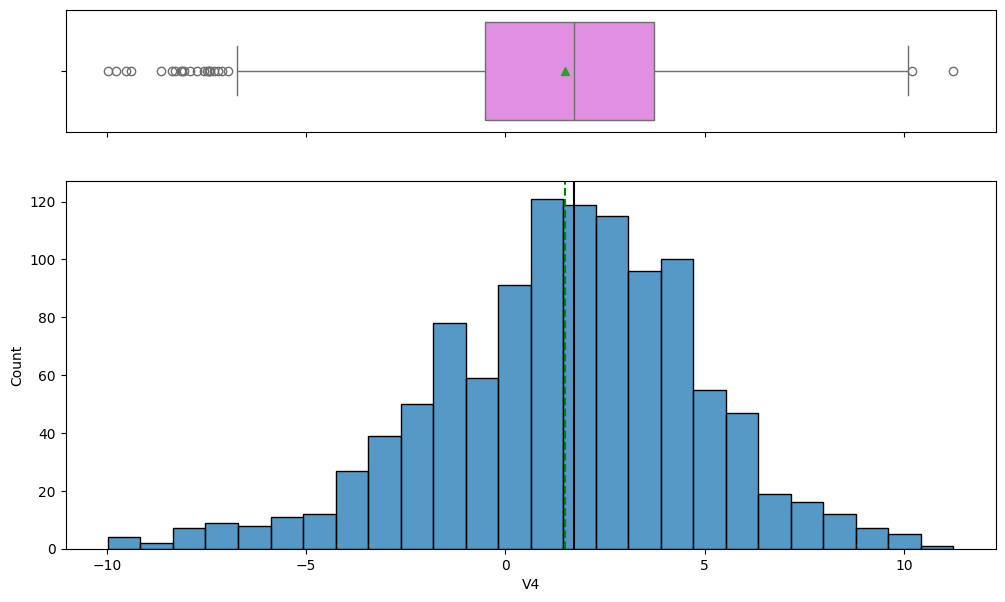

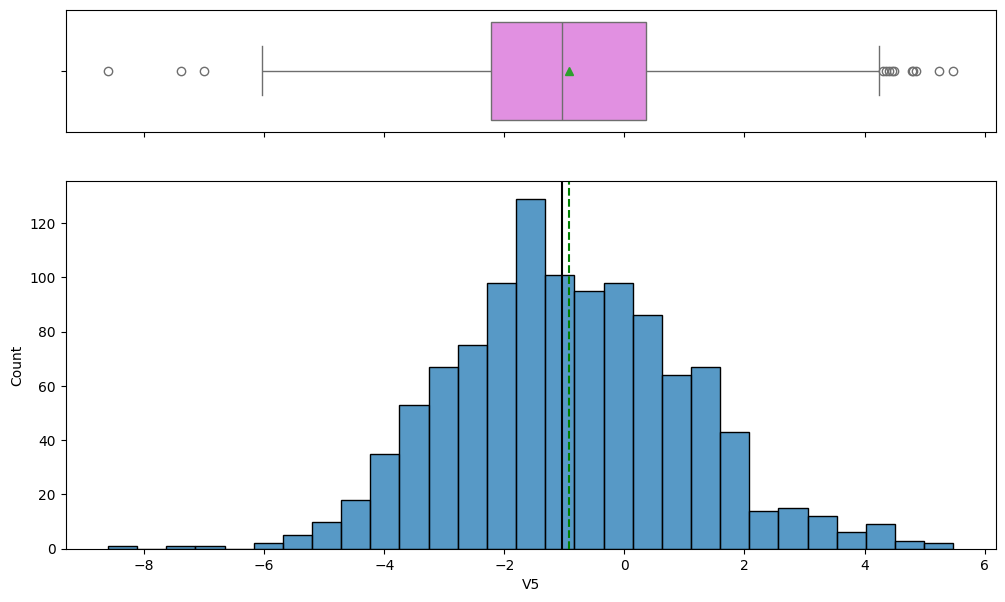

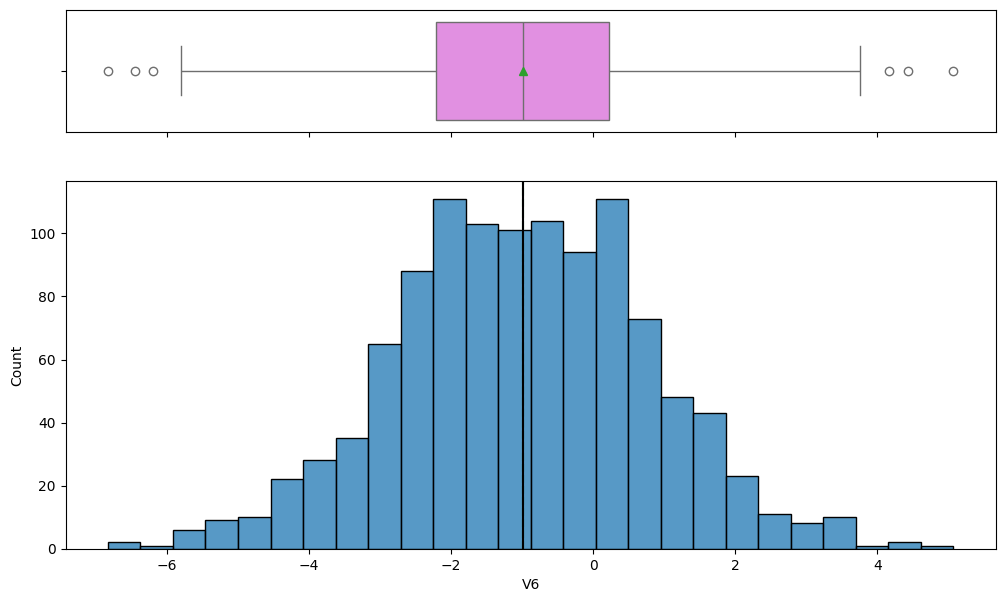

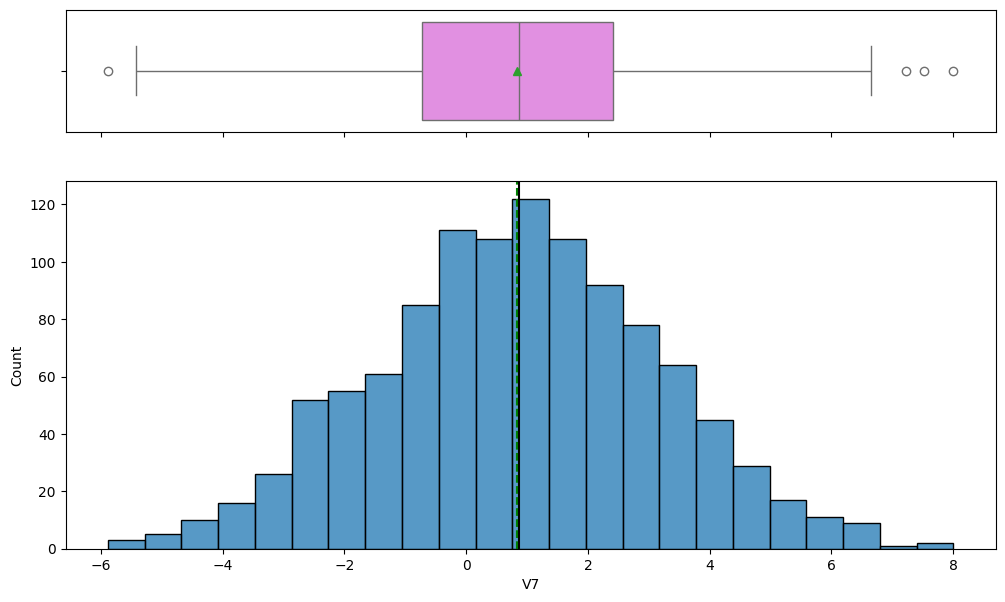

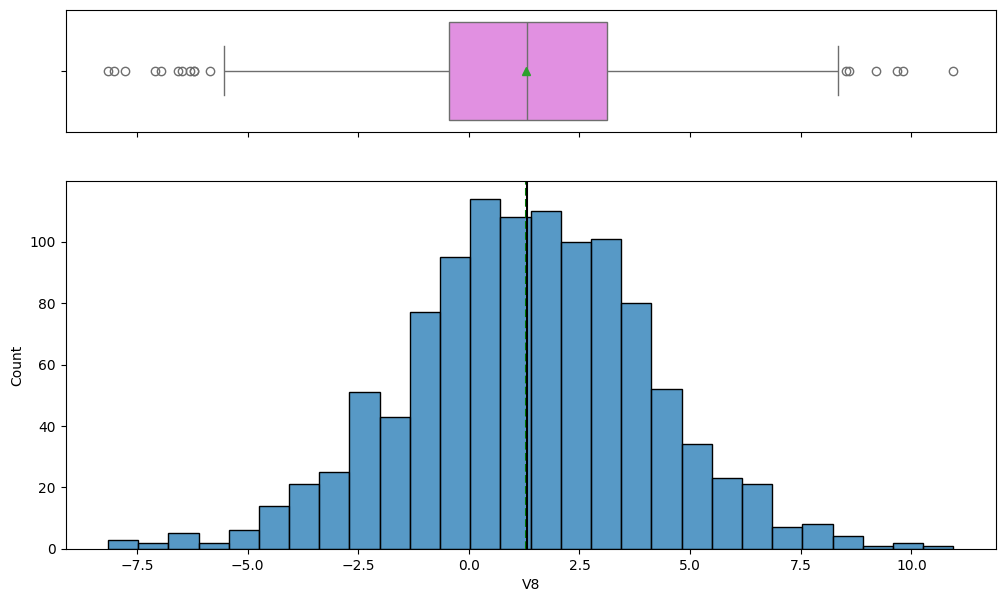

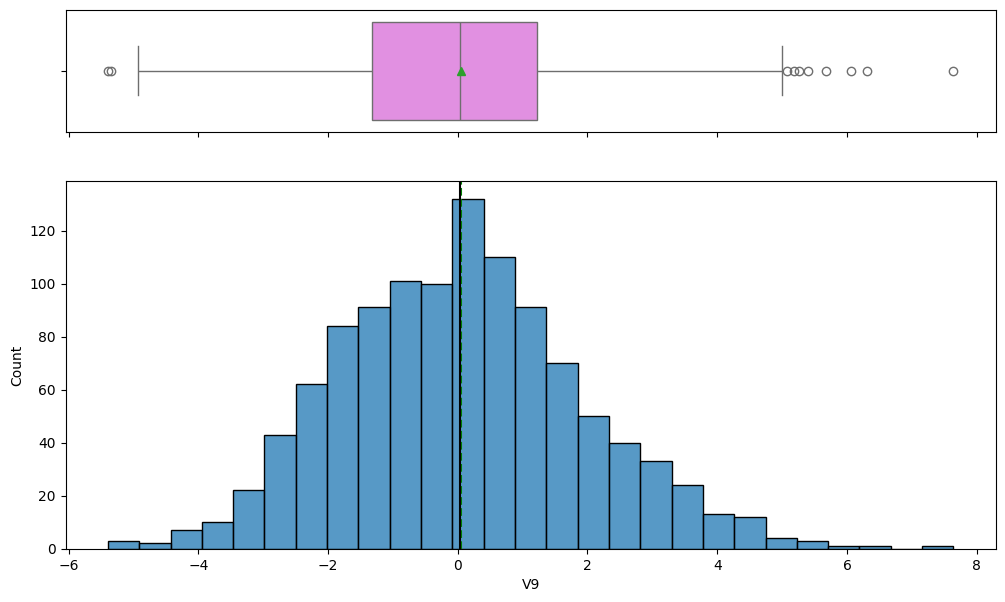

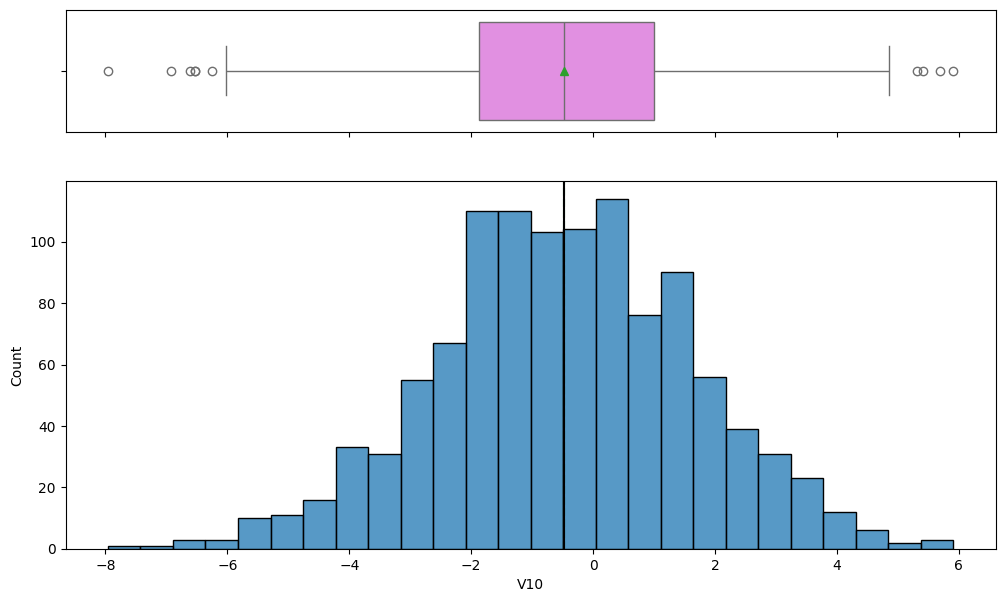

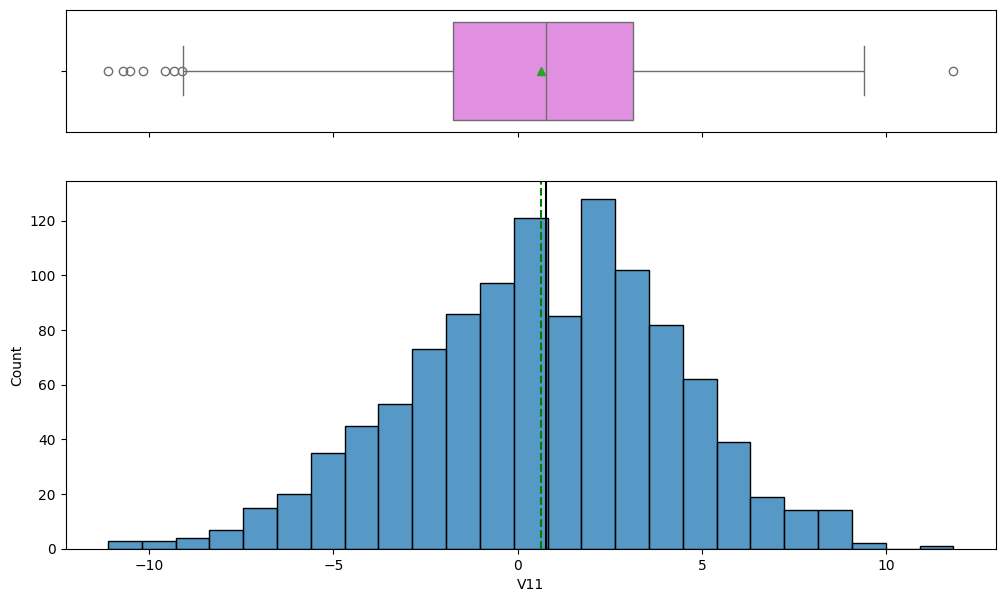

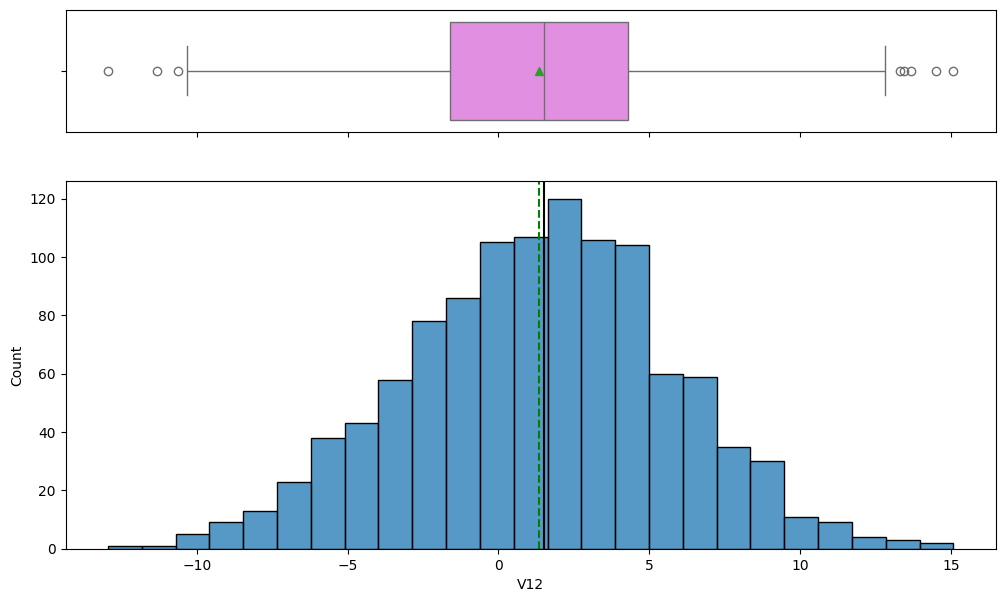

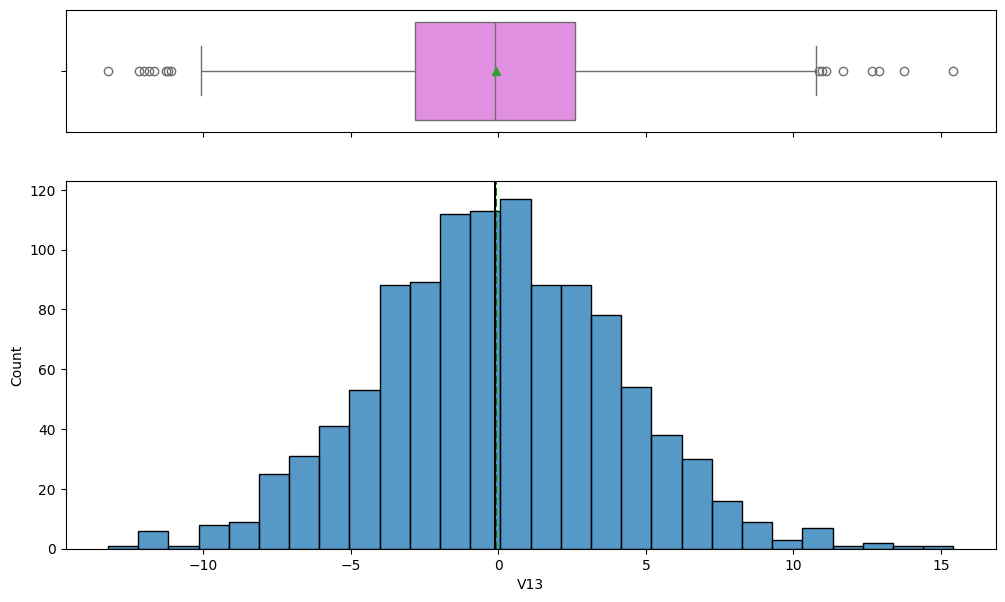

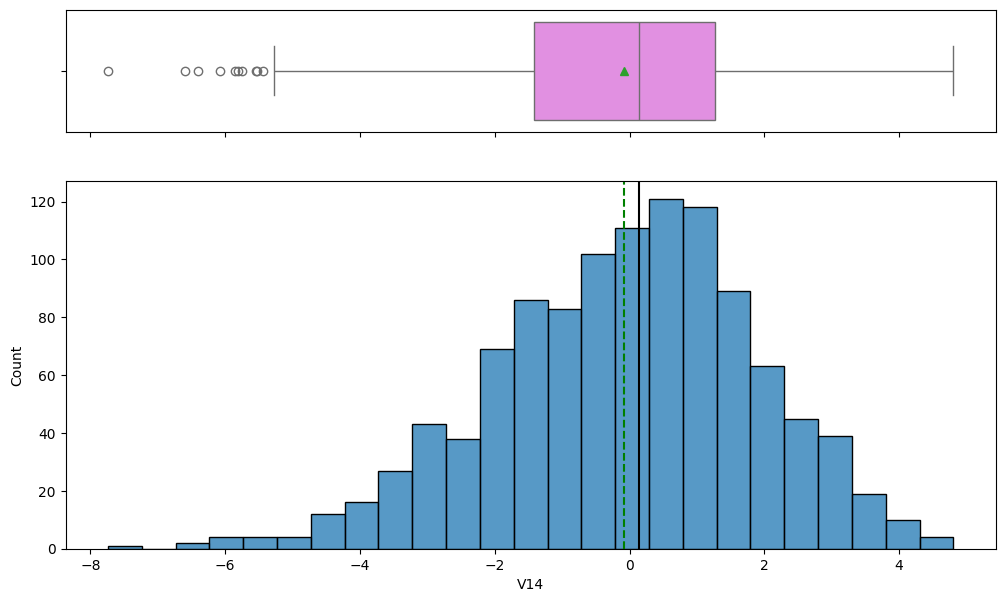

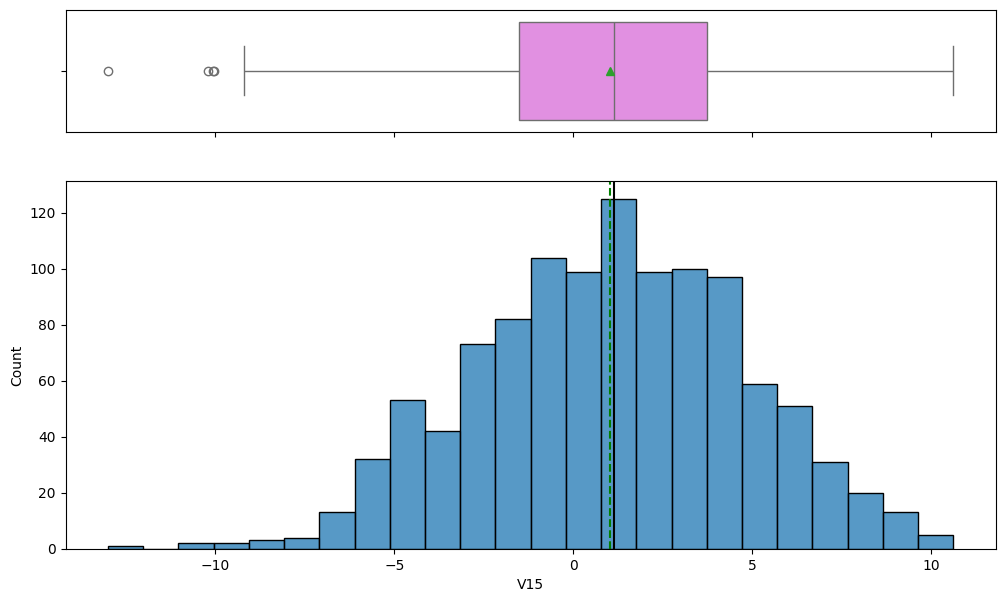

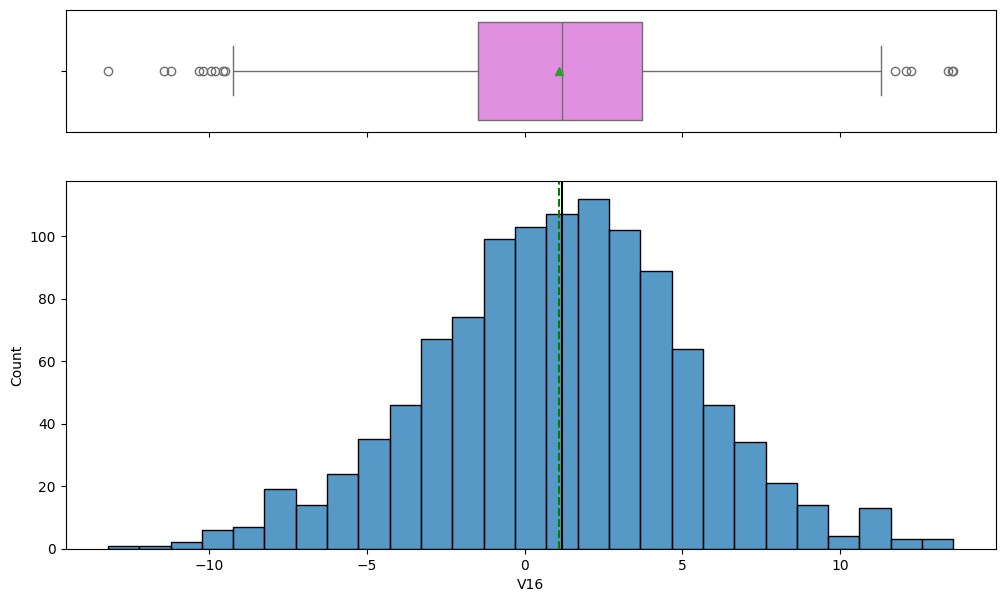

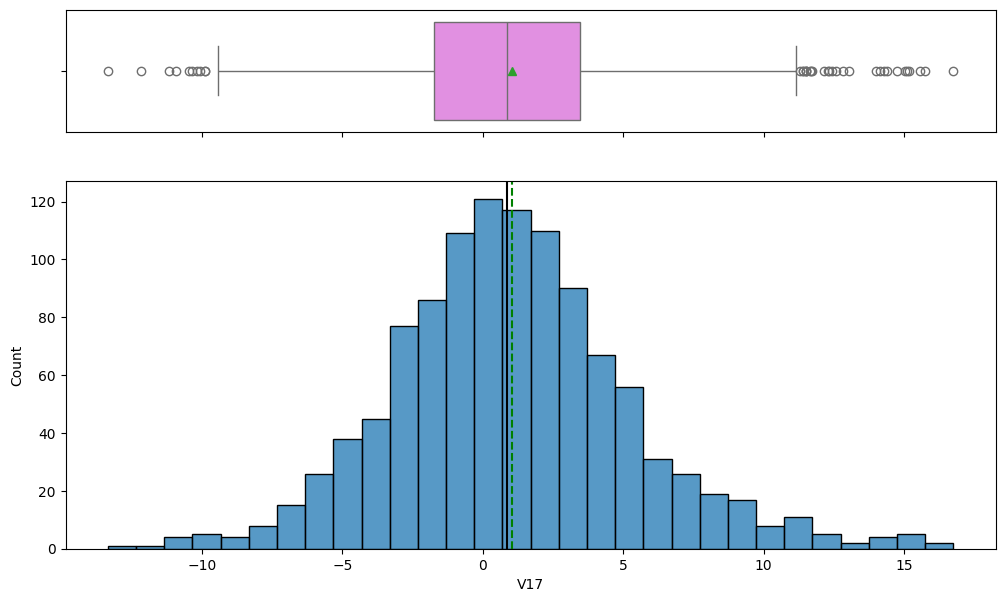

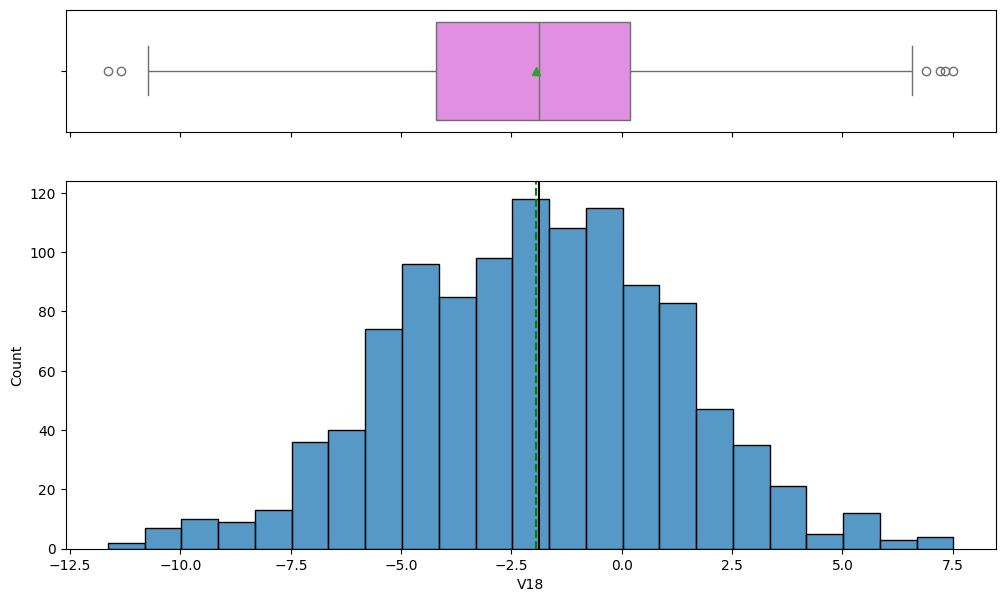

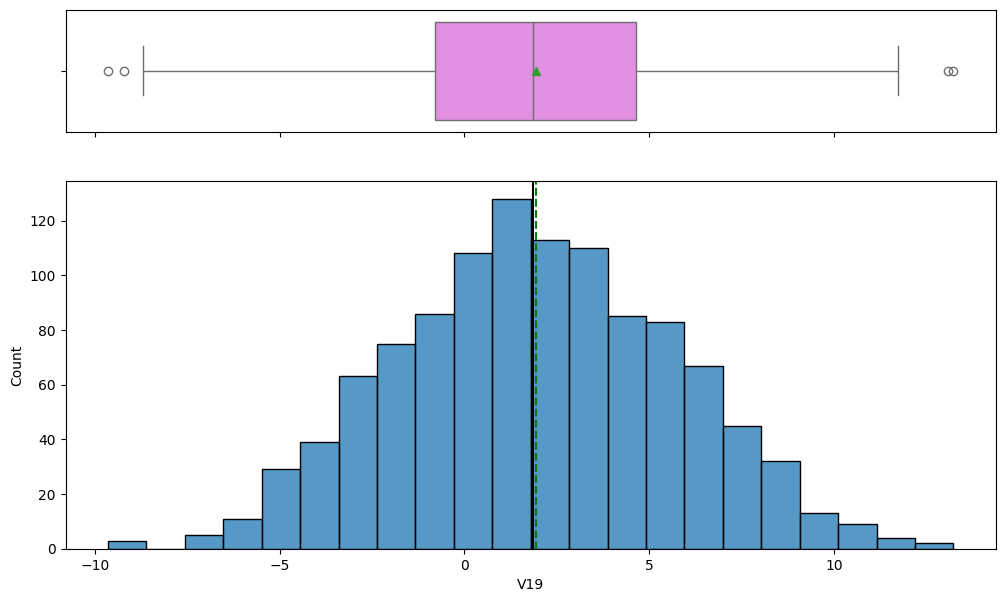

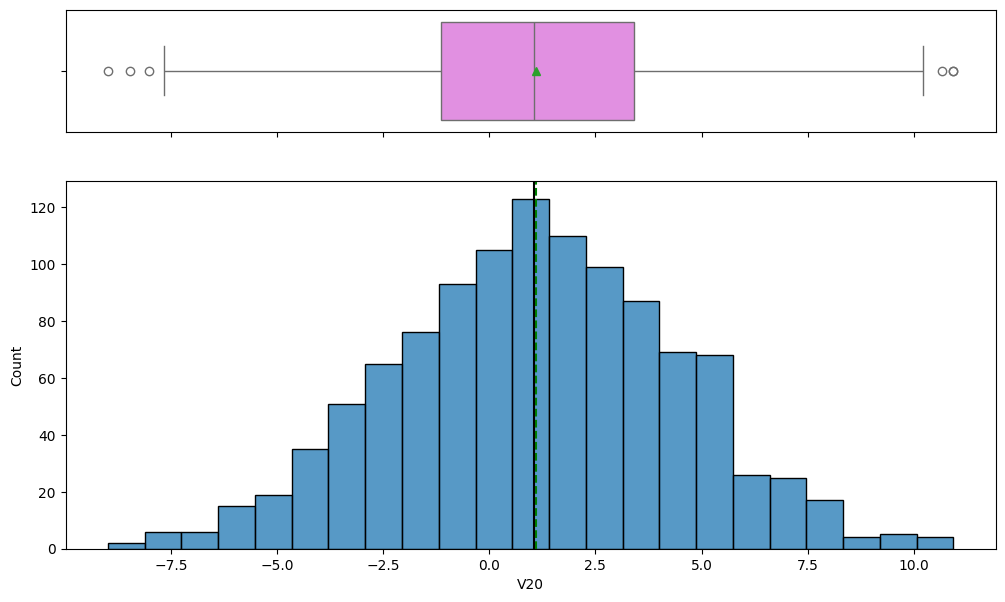

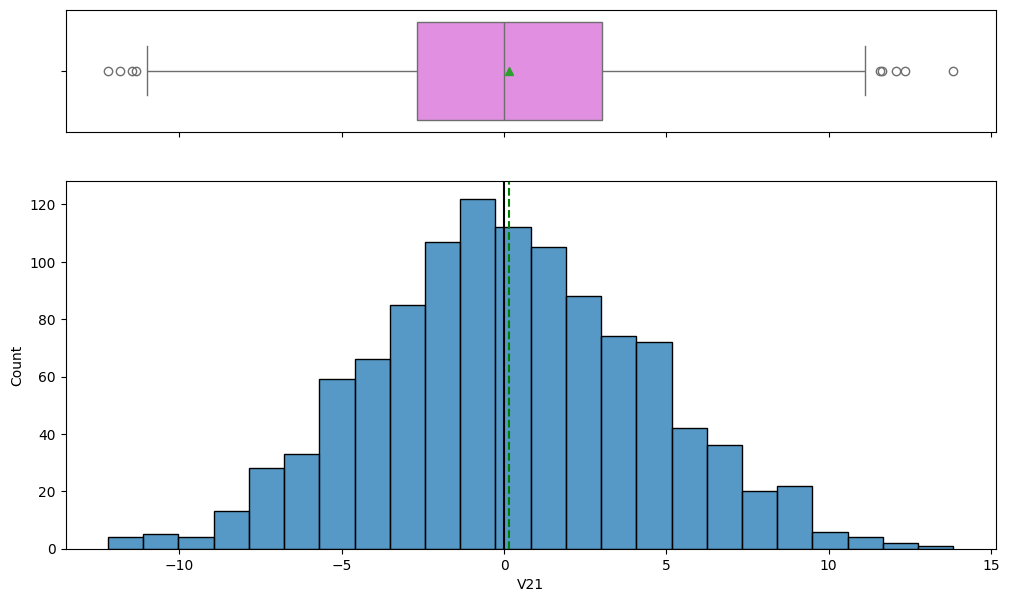

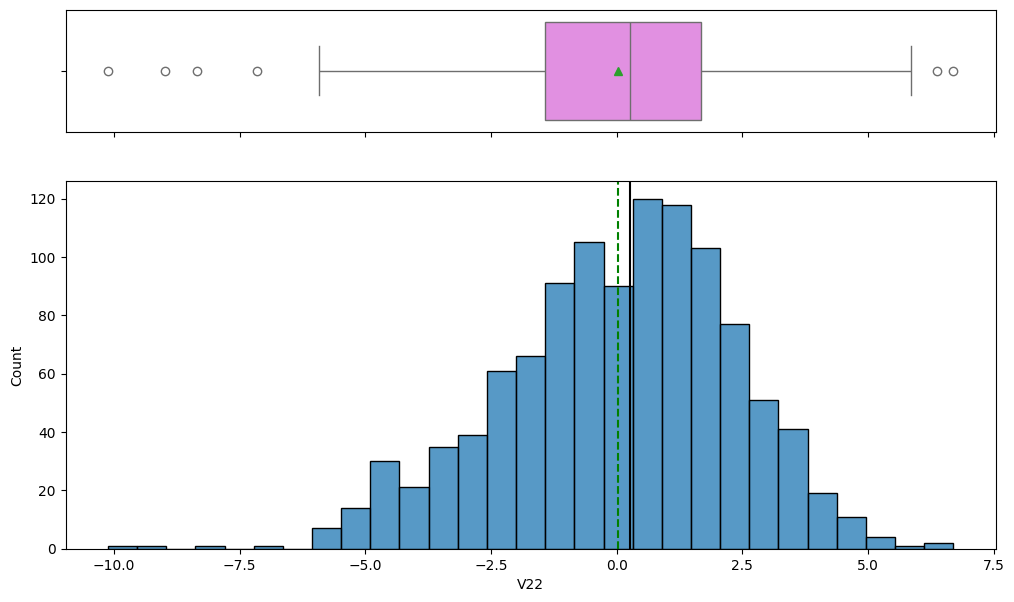

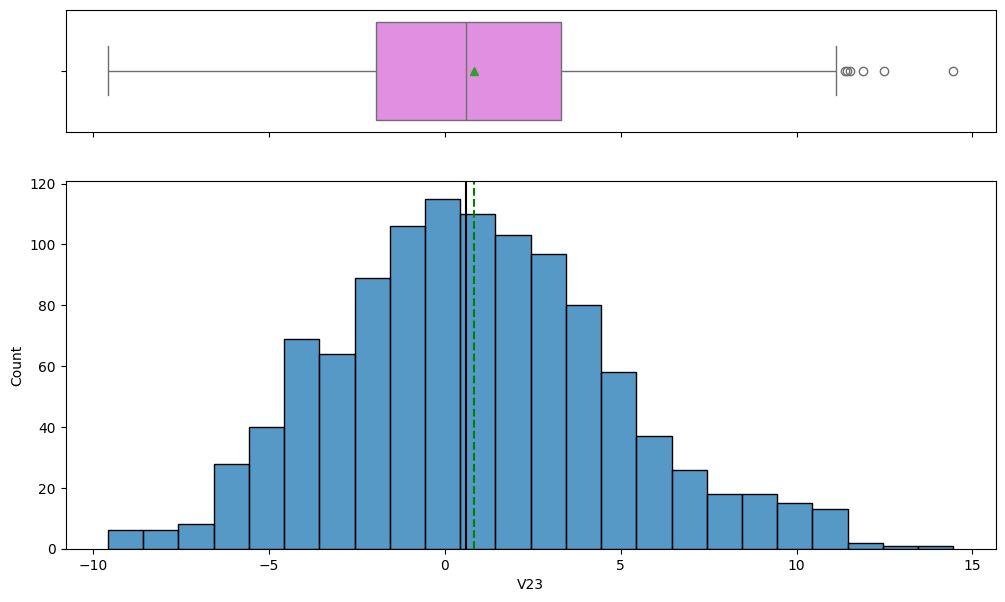

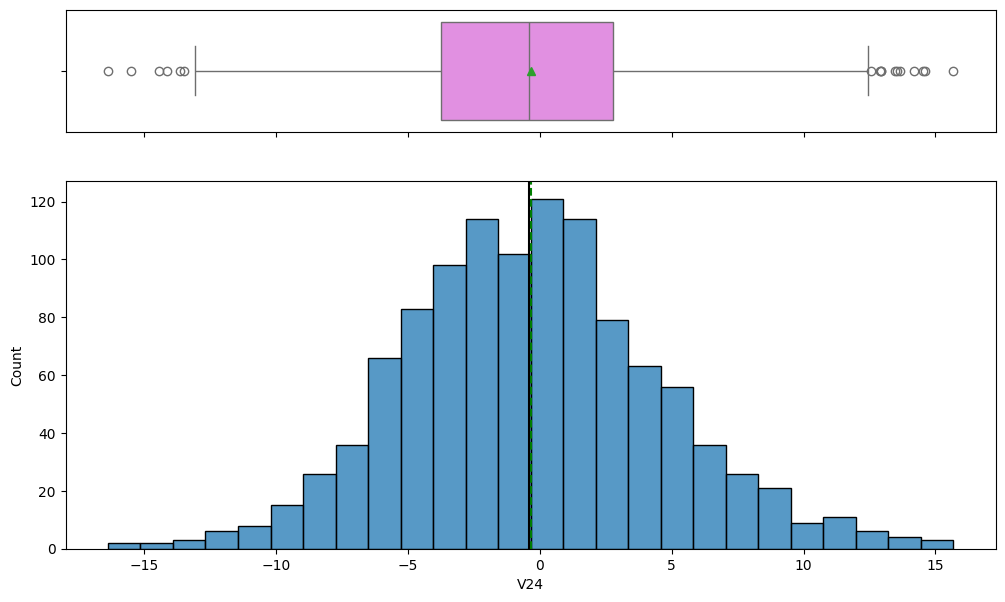

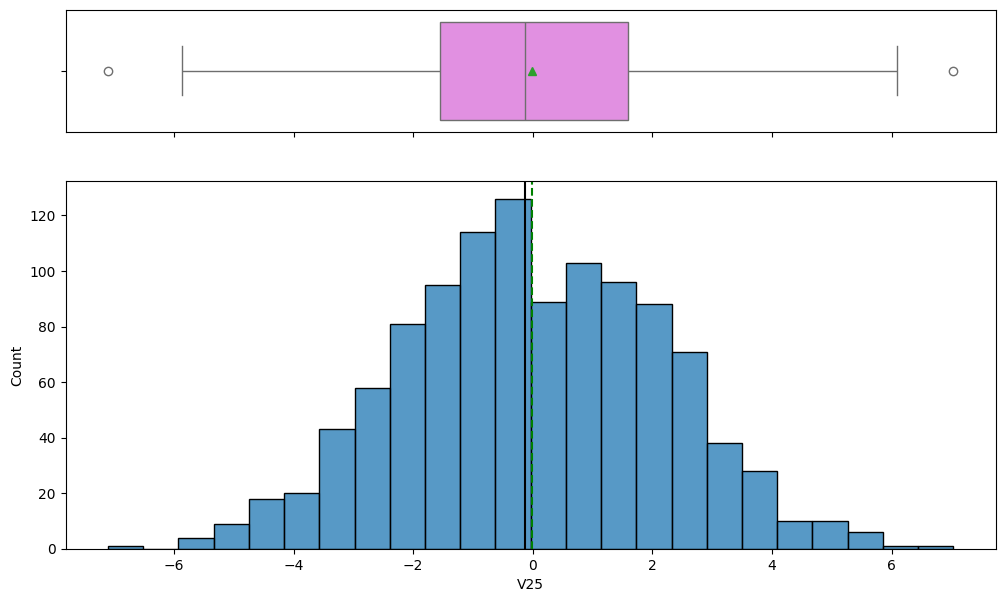

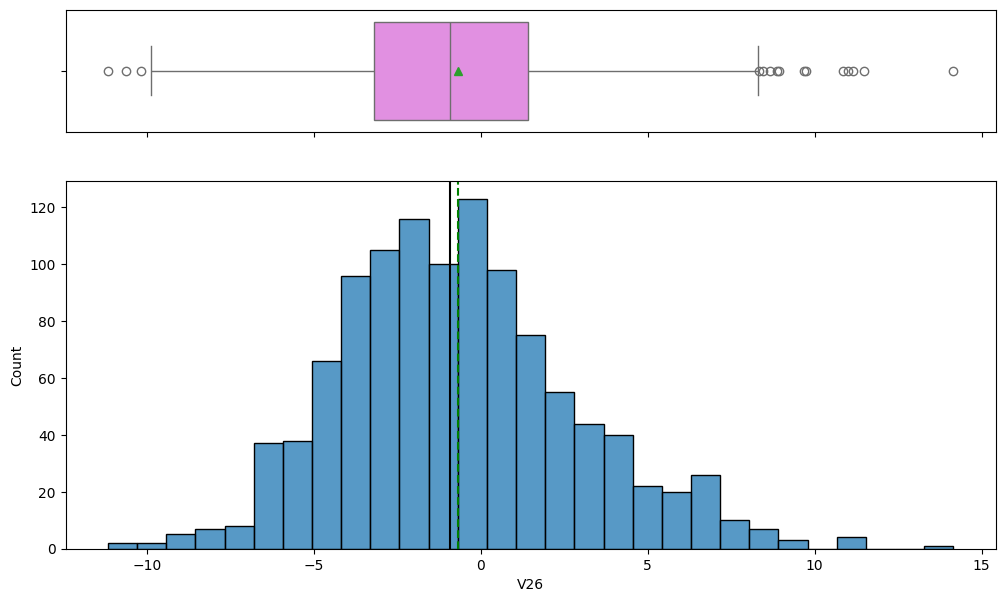

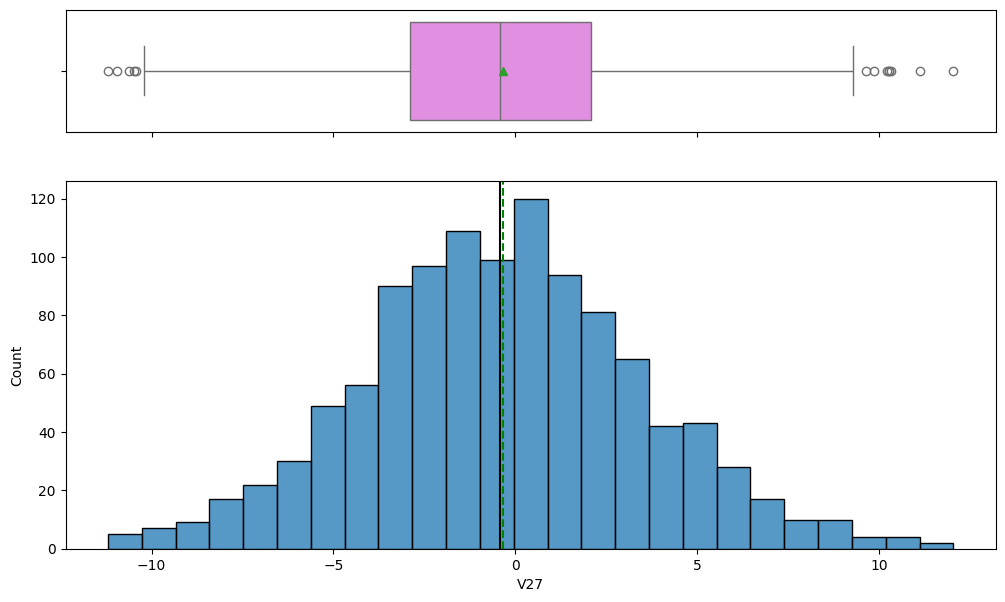

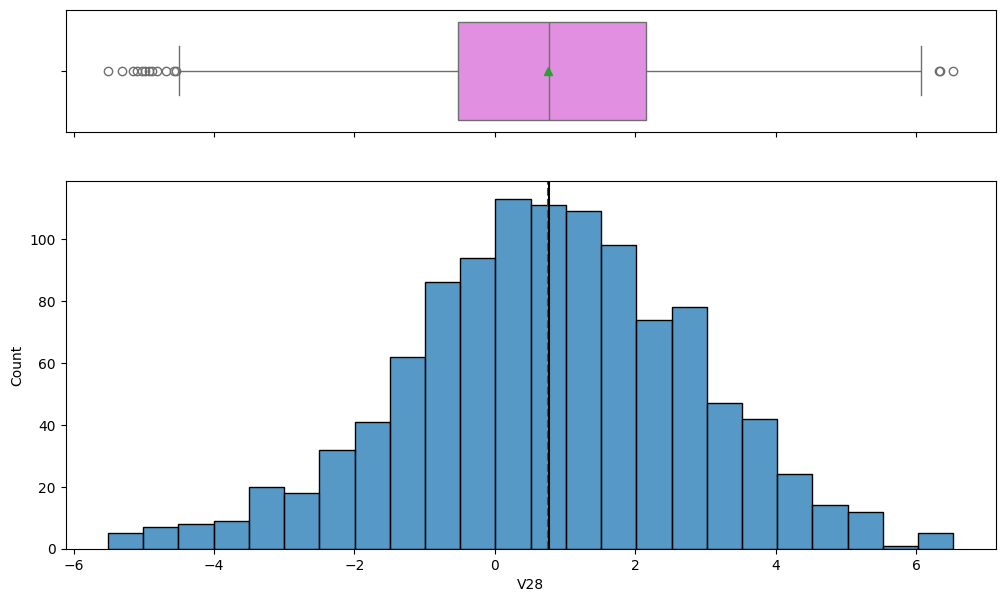

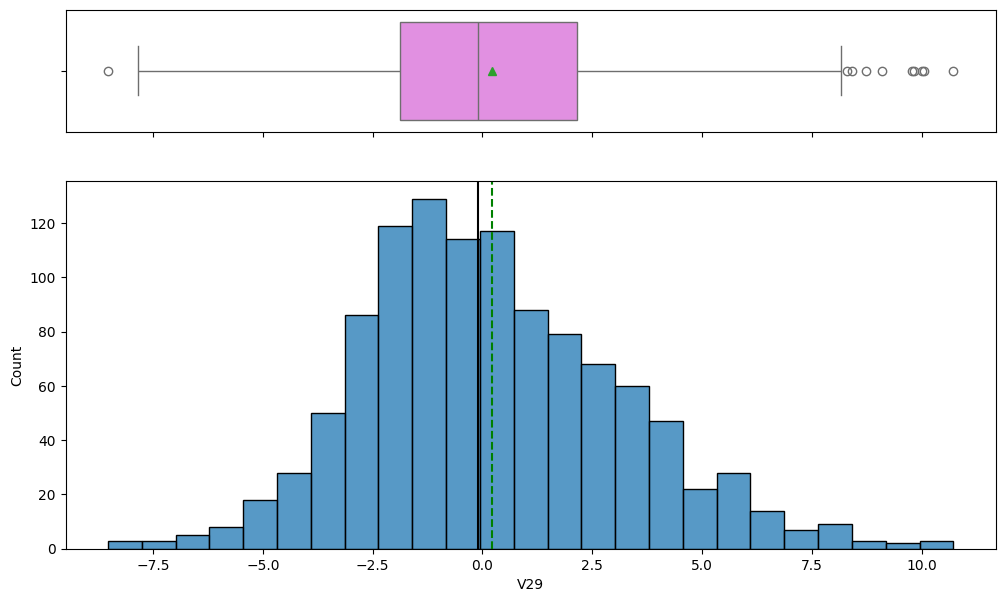

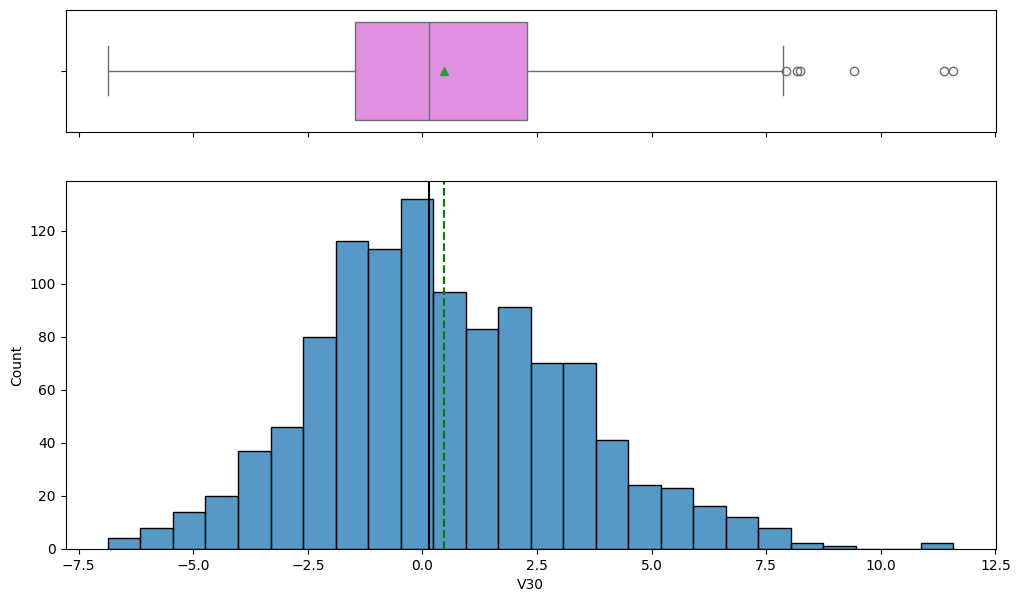

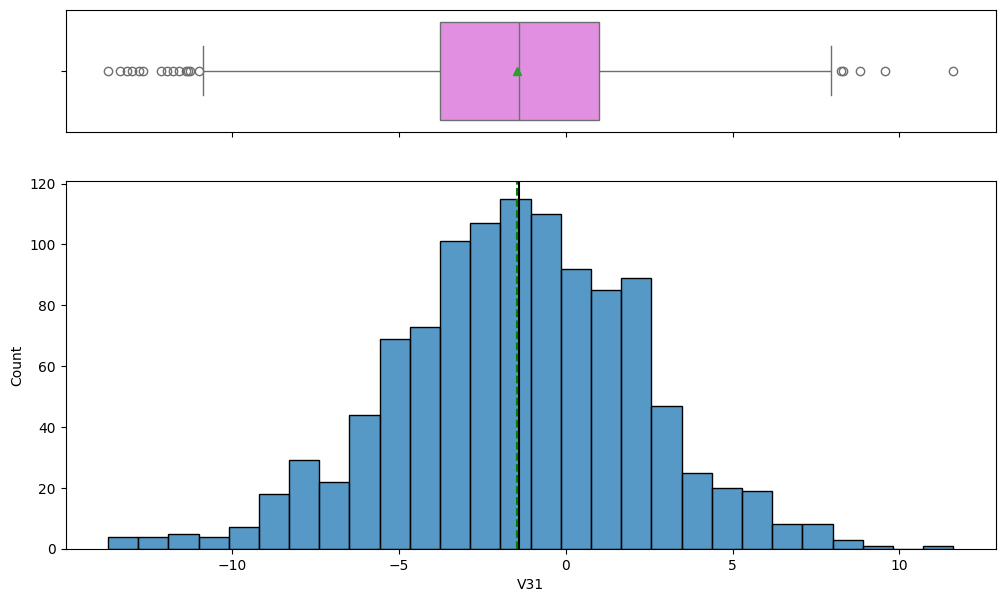

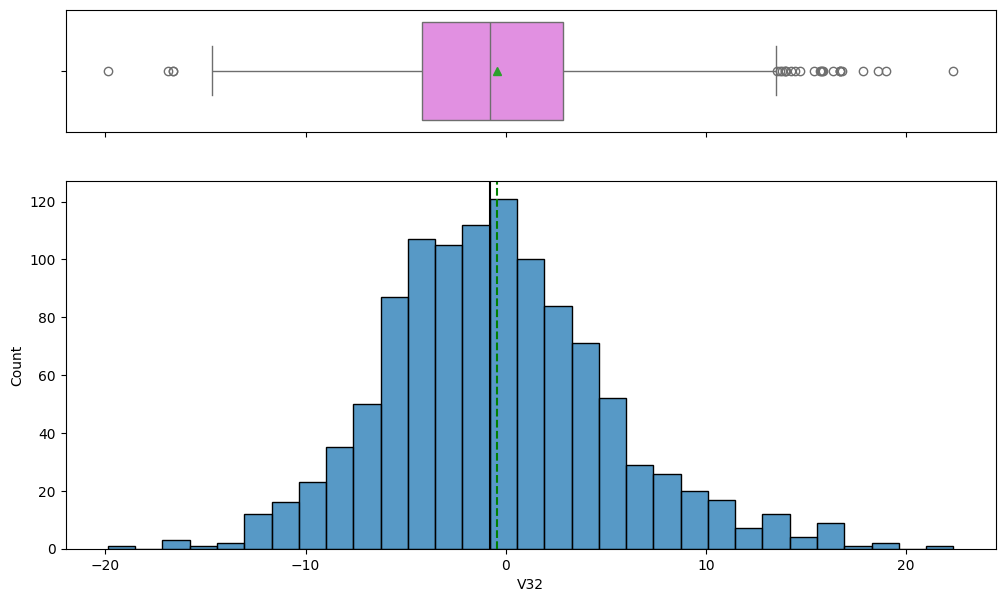

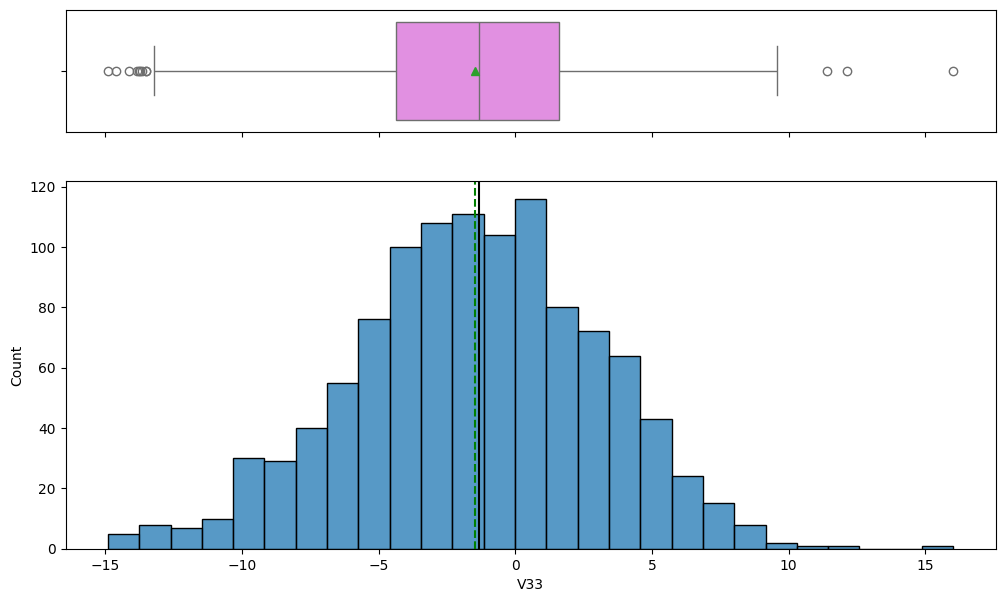

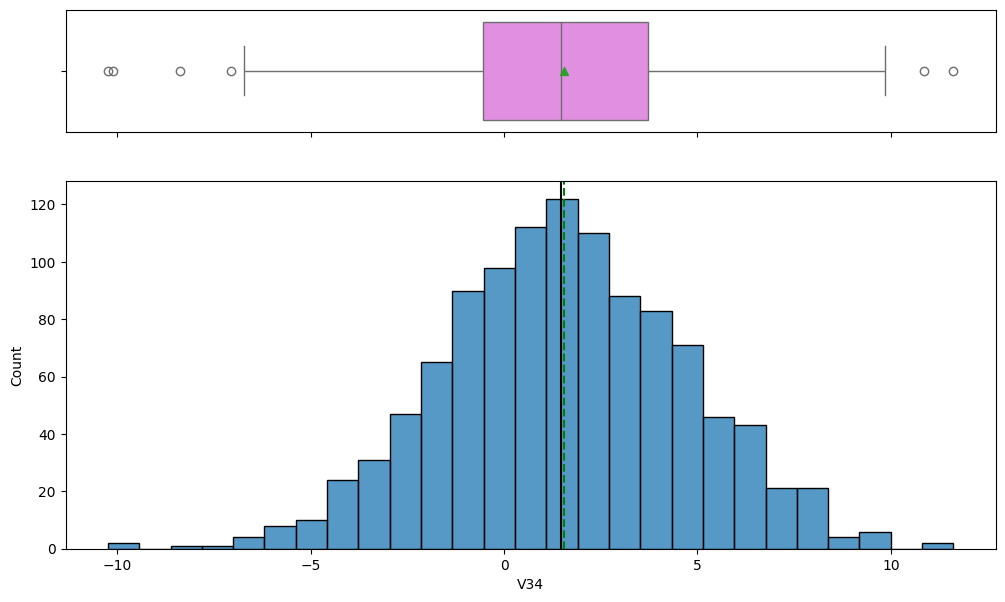

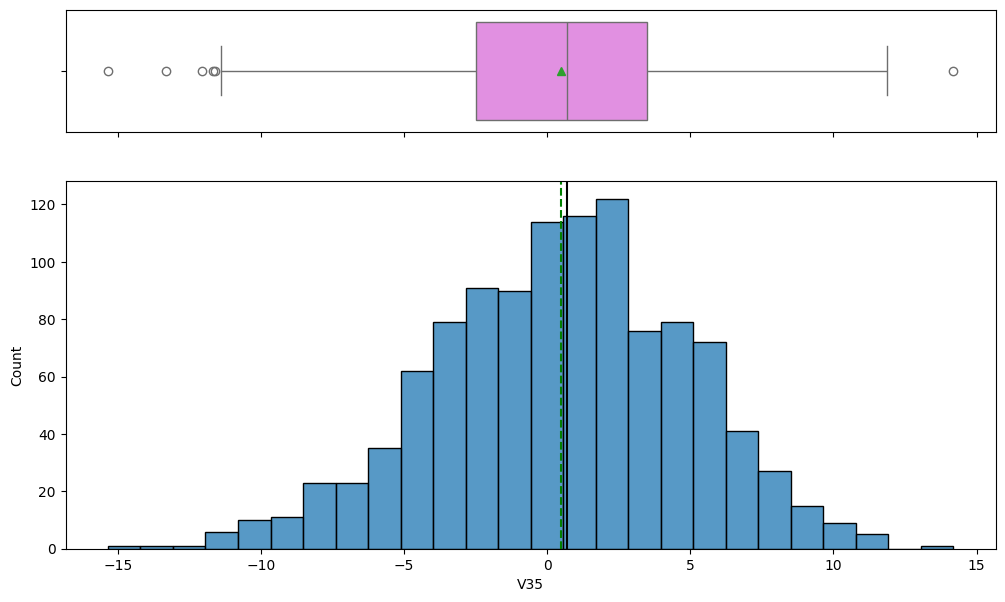

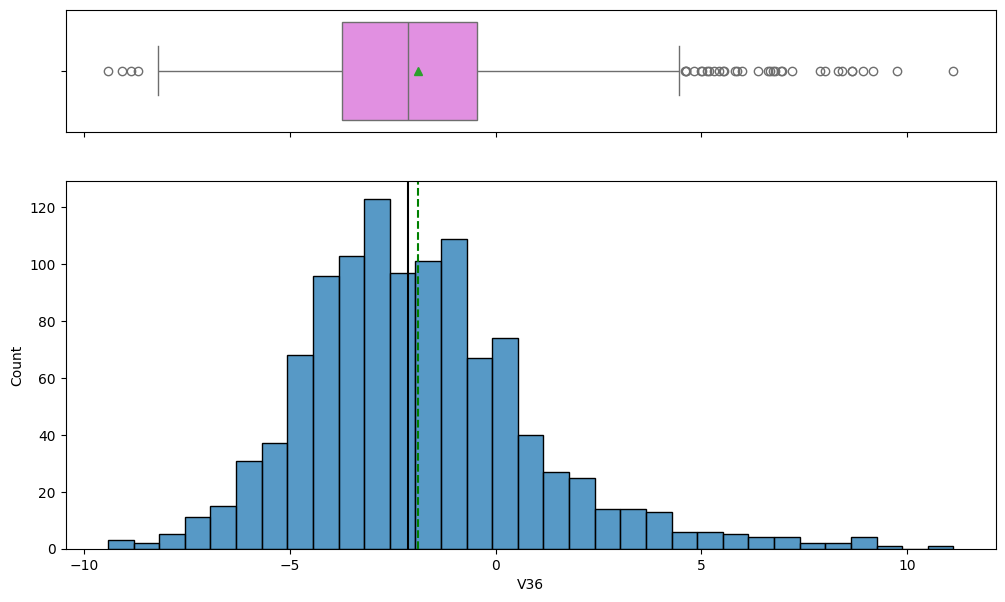

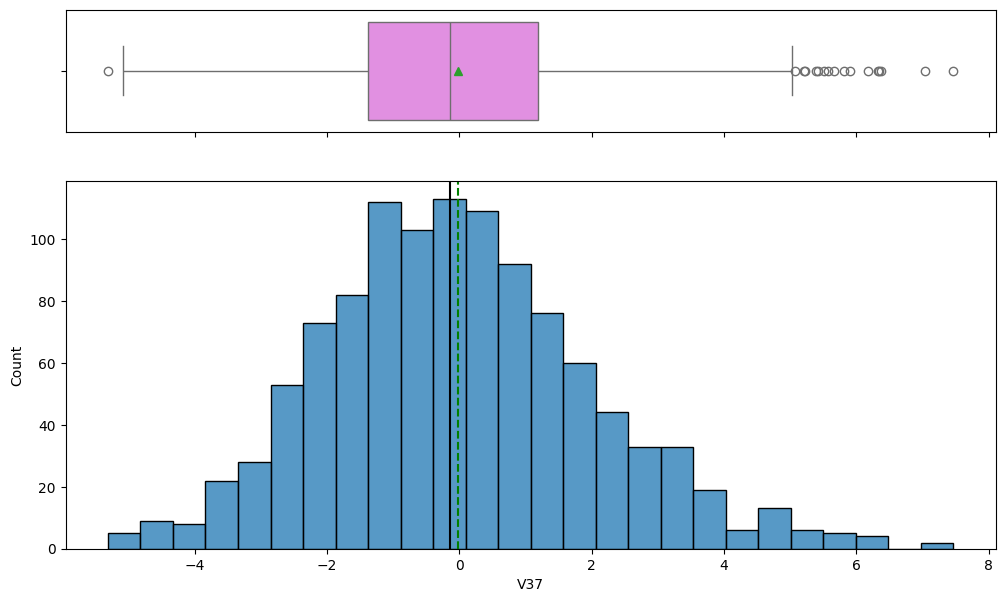

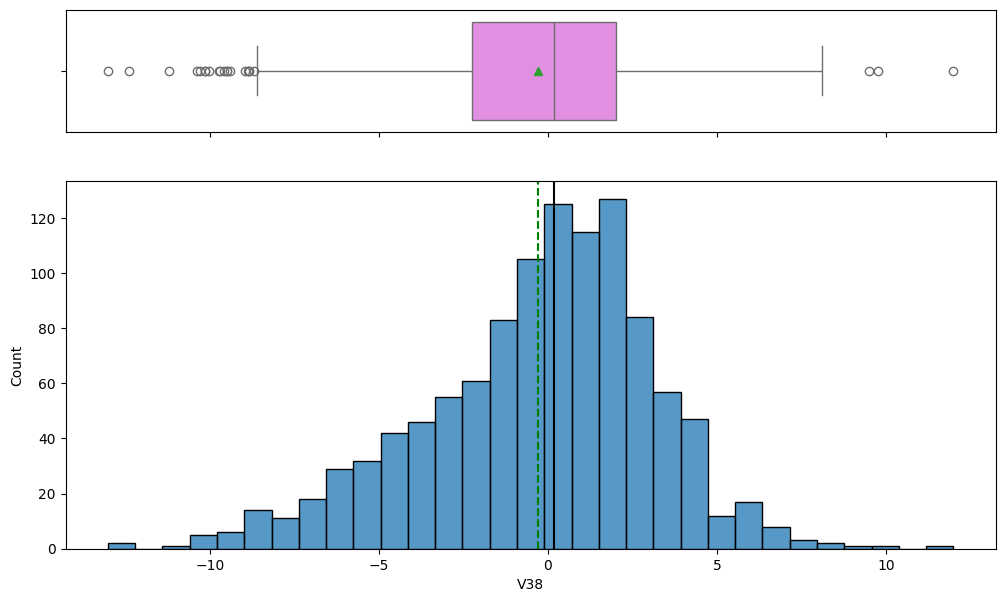

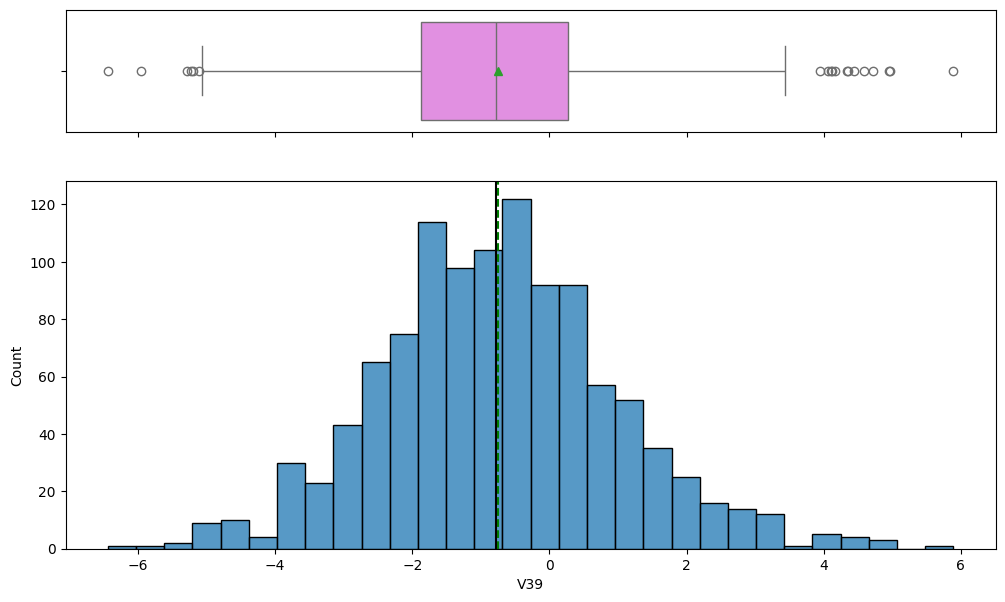

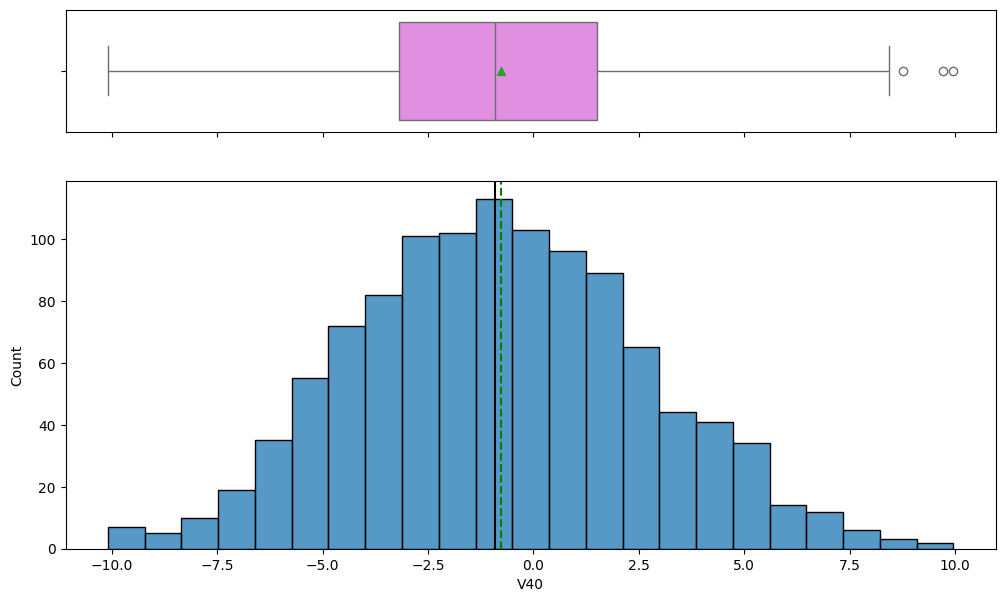

In [18]:
for feature in df_test.columns[df_test.dtypes=='float64']:
    histogram_boxplot(fail, feature, figsize=(12, 7), kde=False, bins=None)

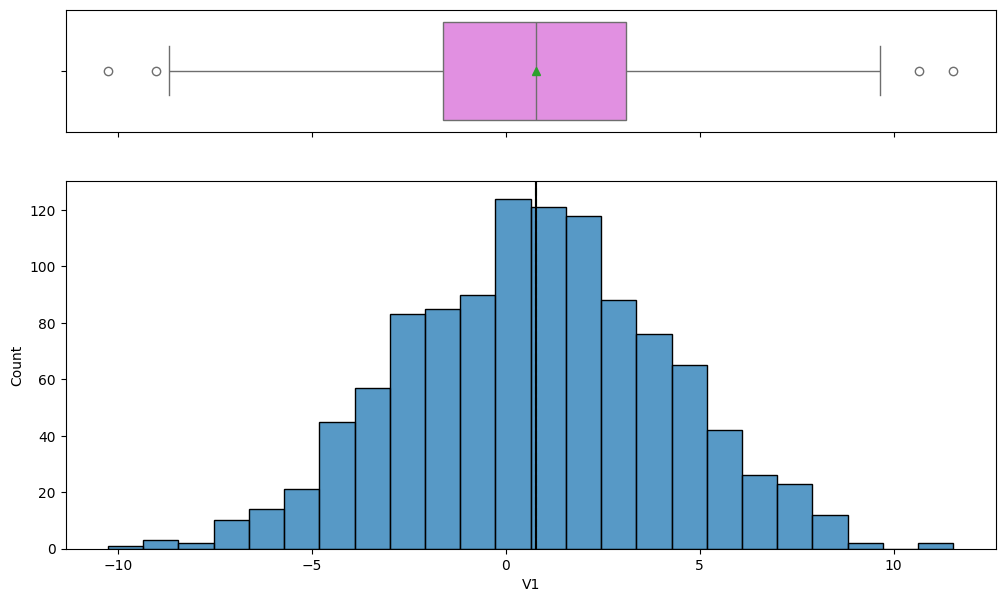

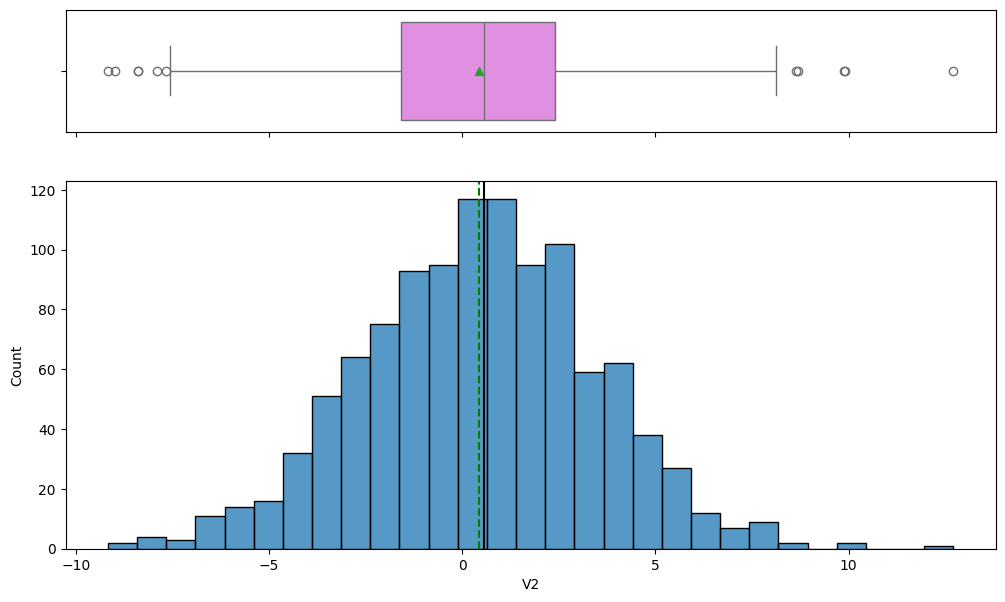

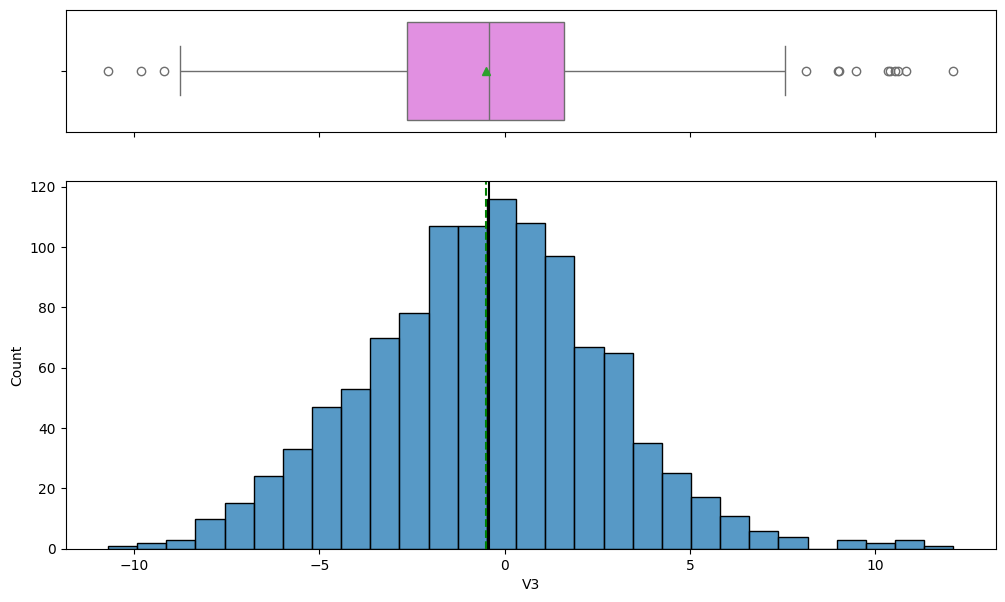

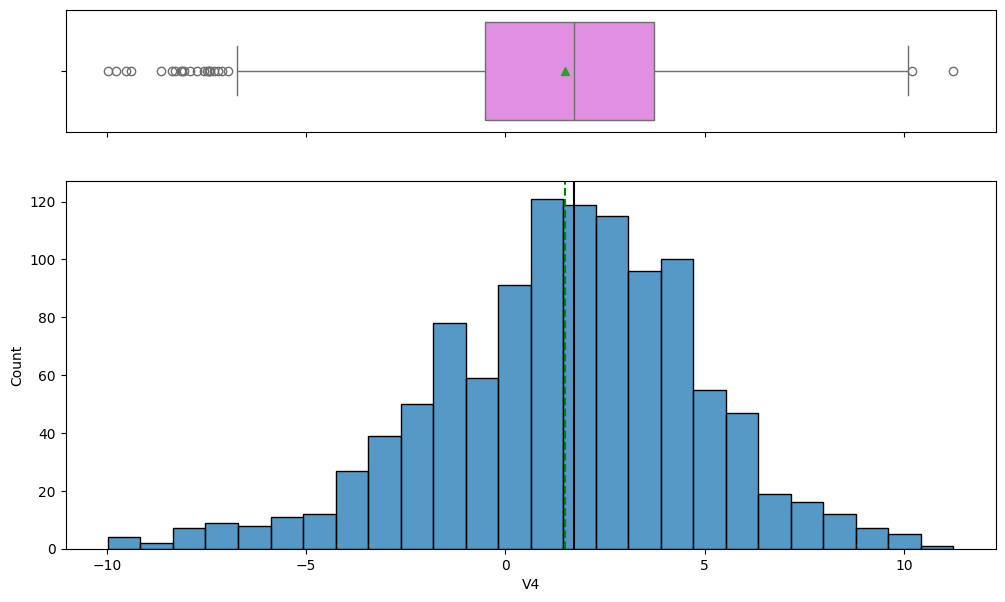

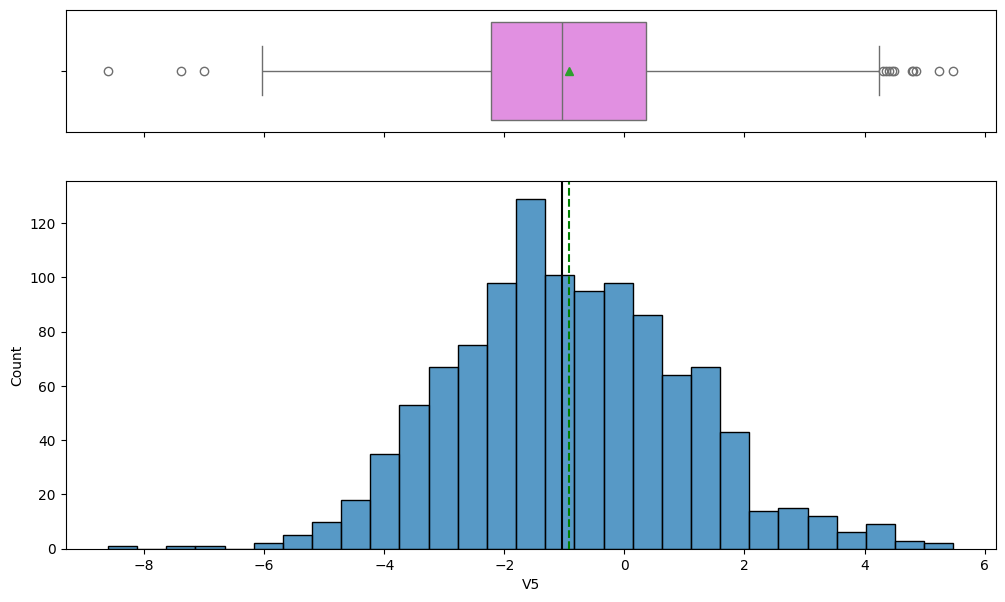

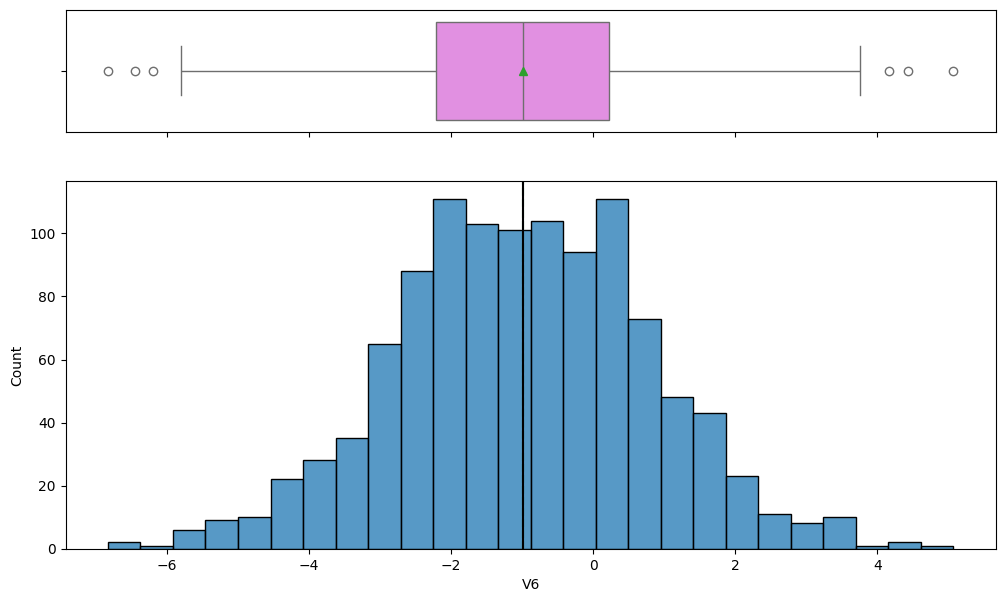

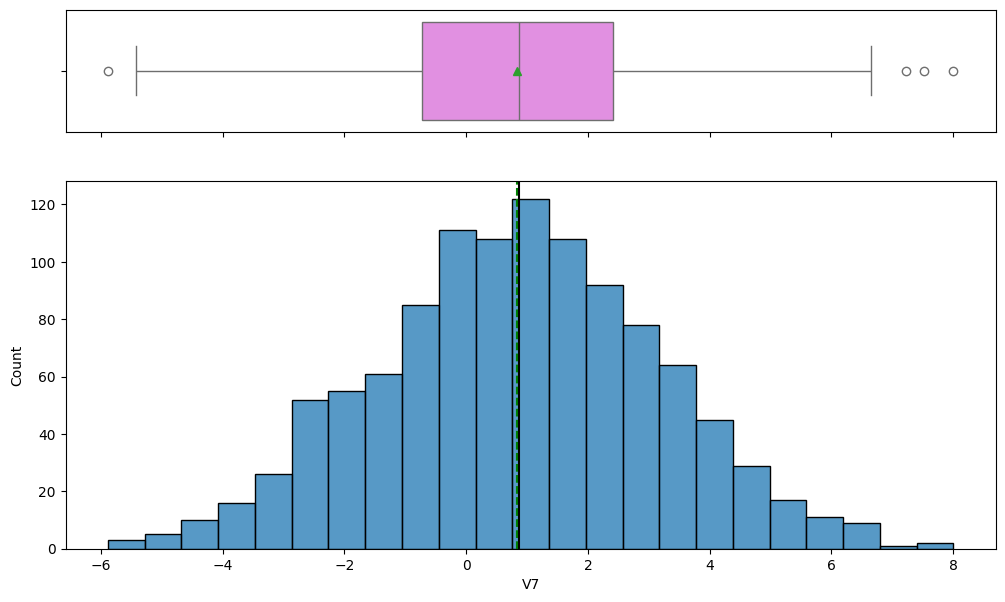

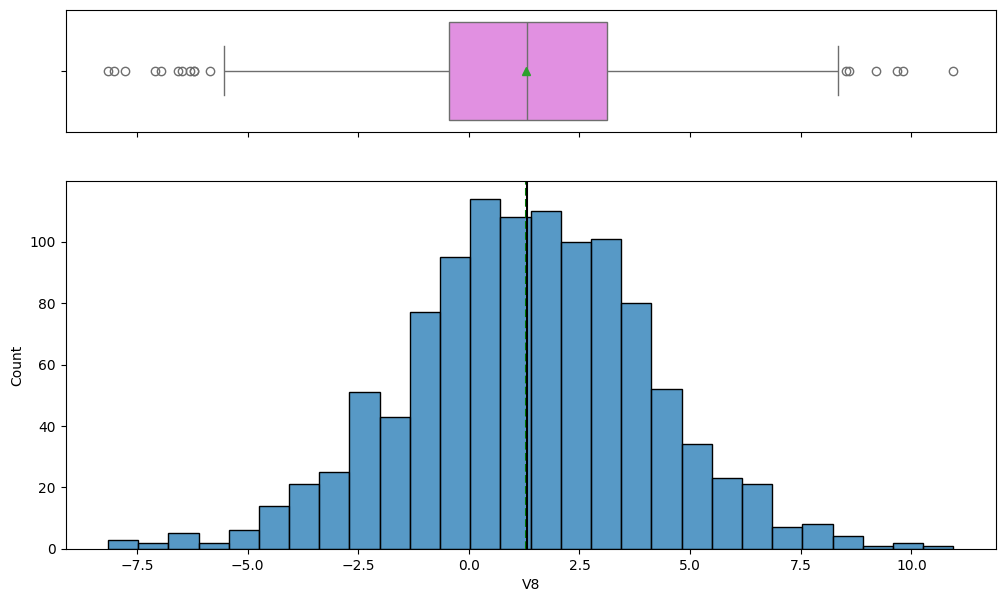

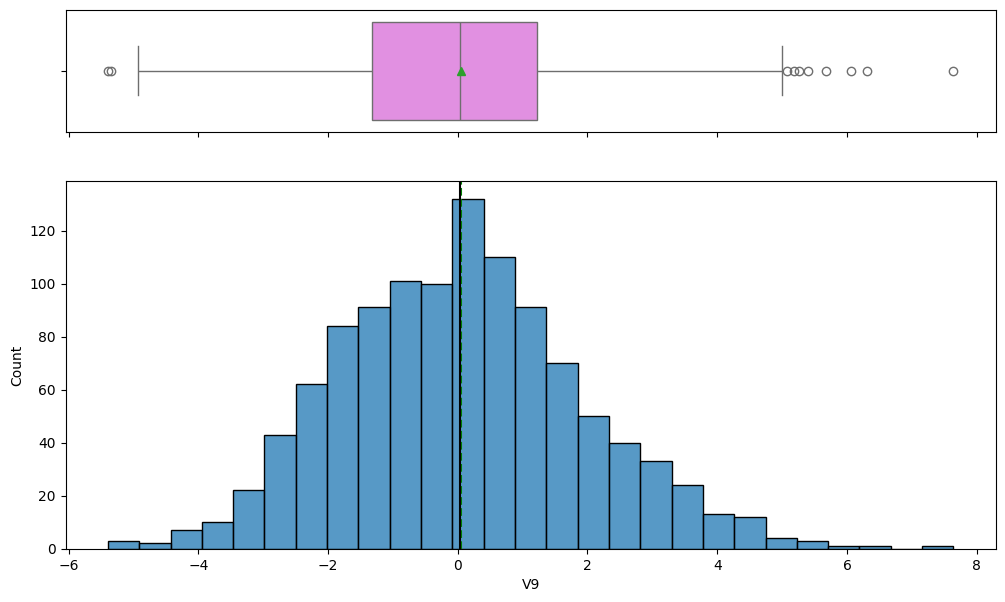

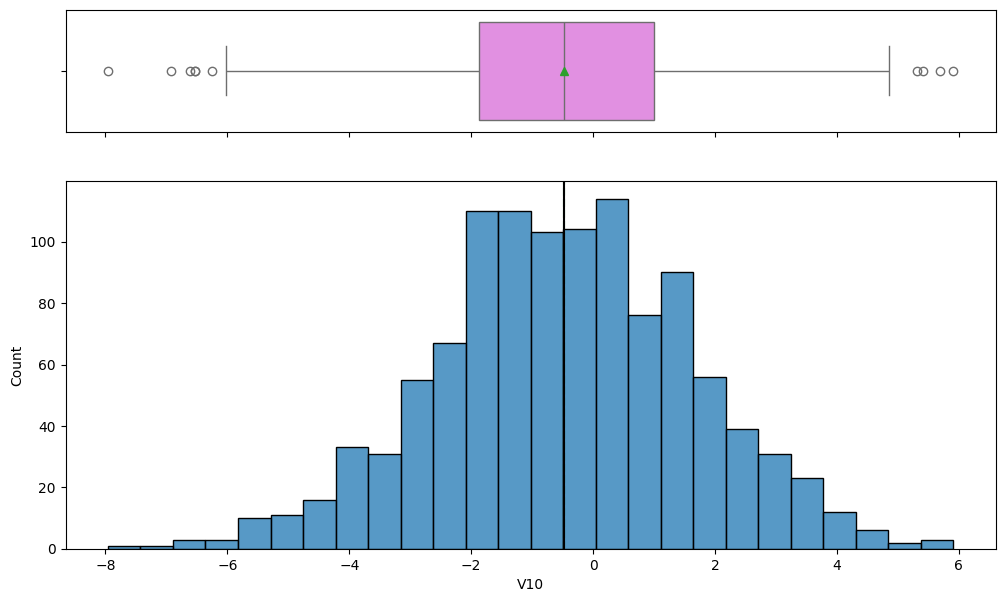

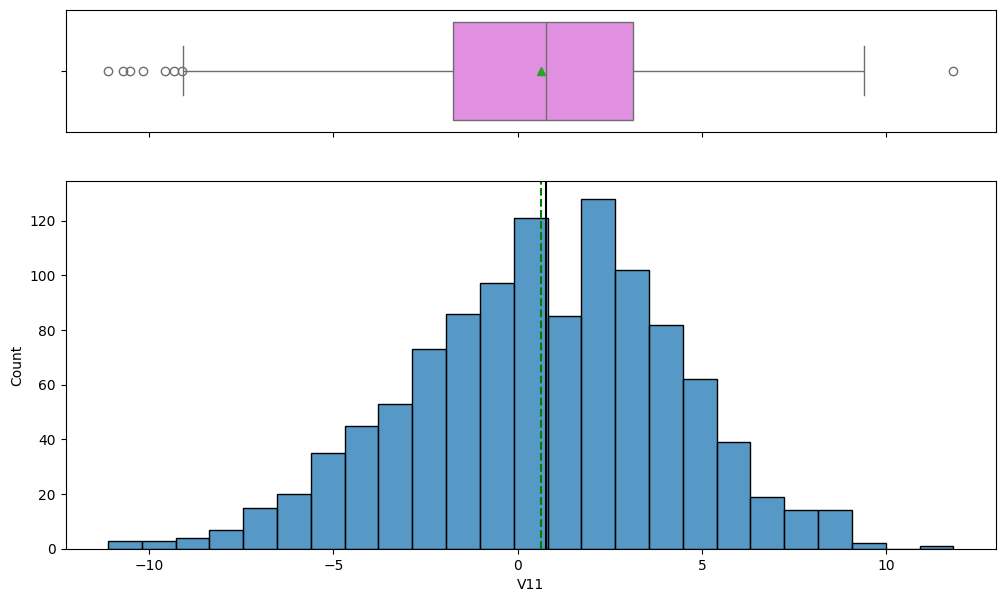

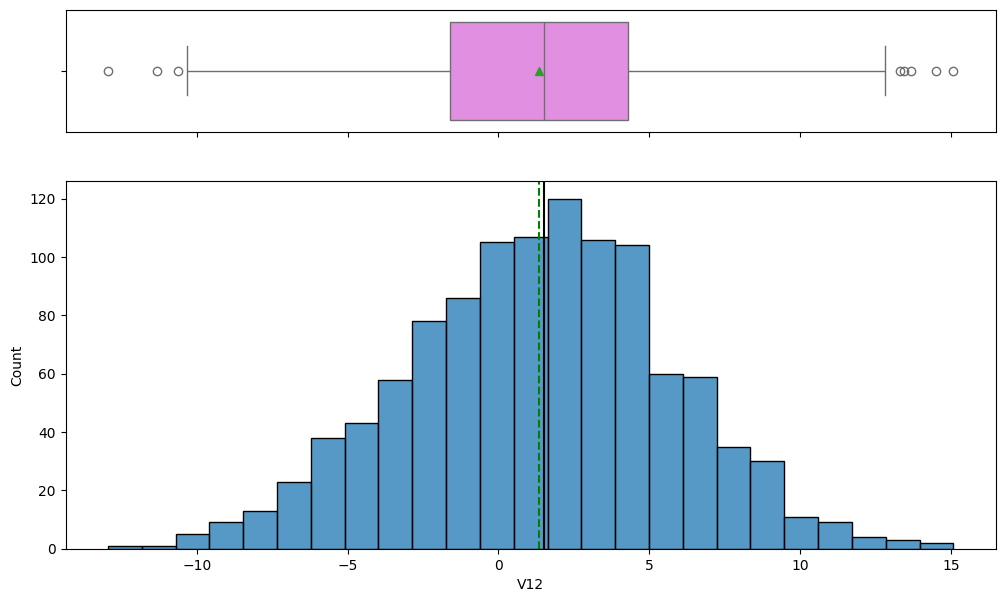

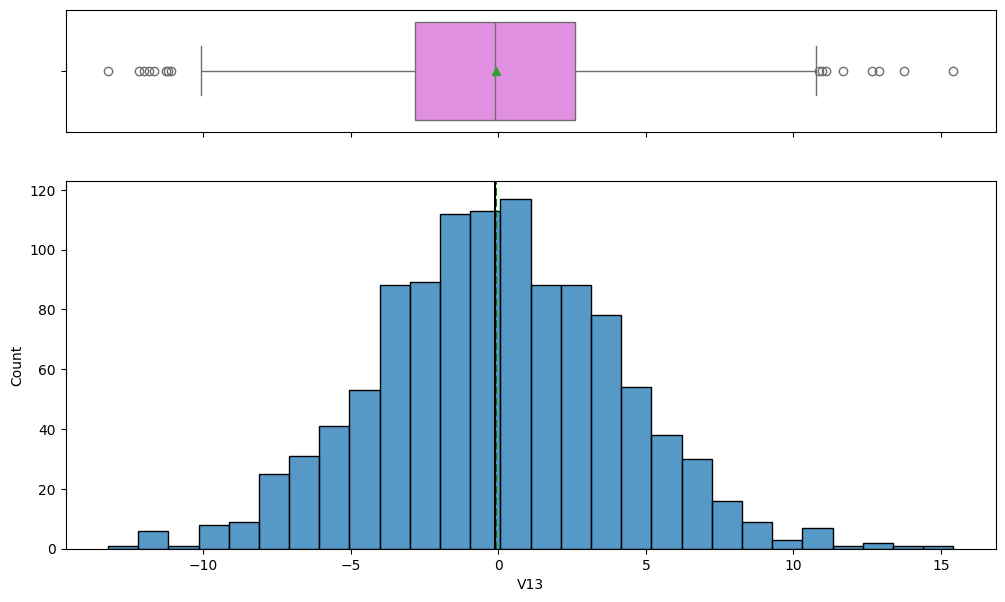

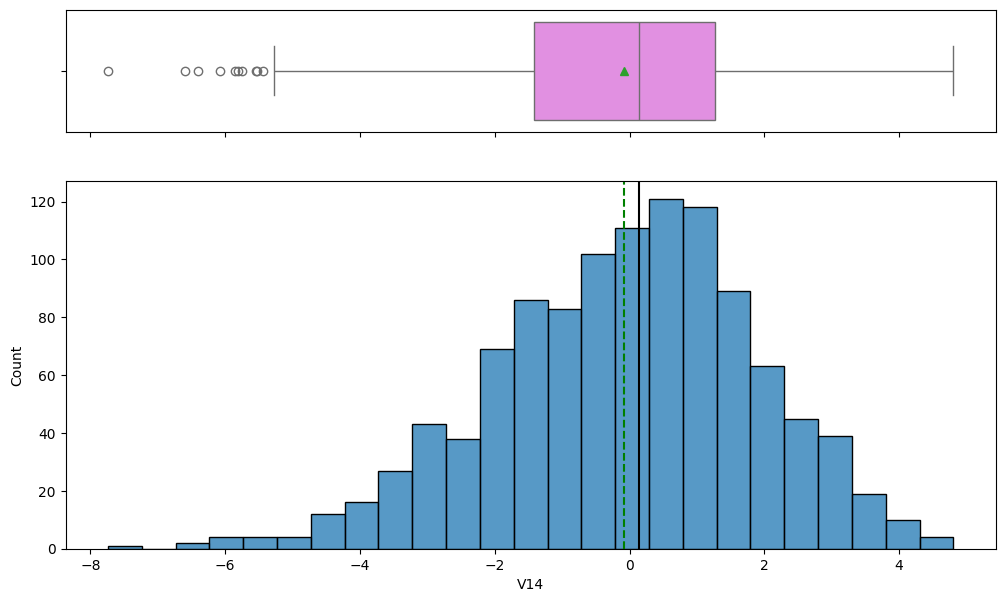

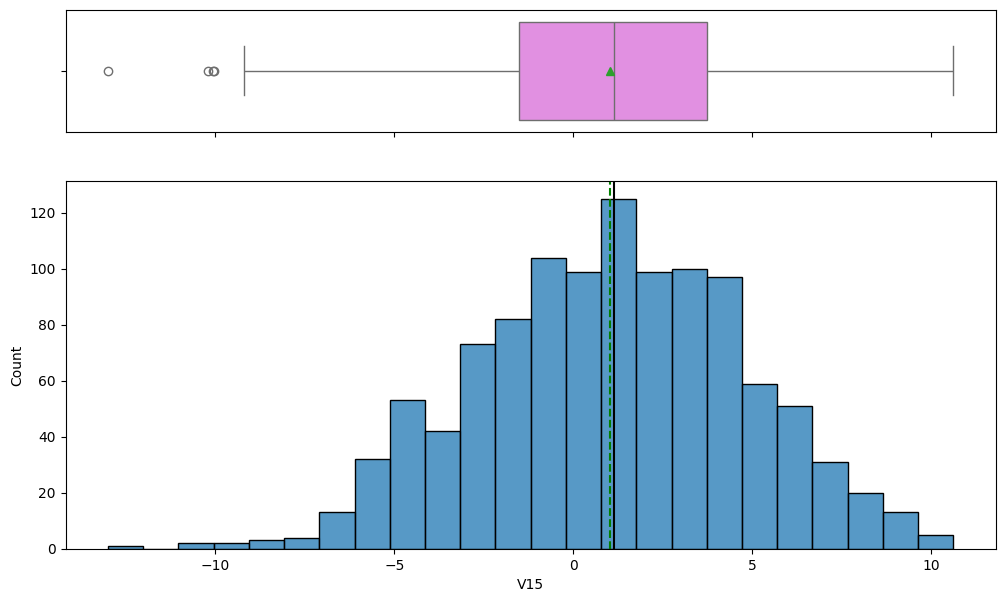

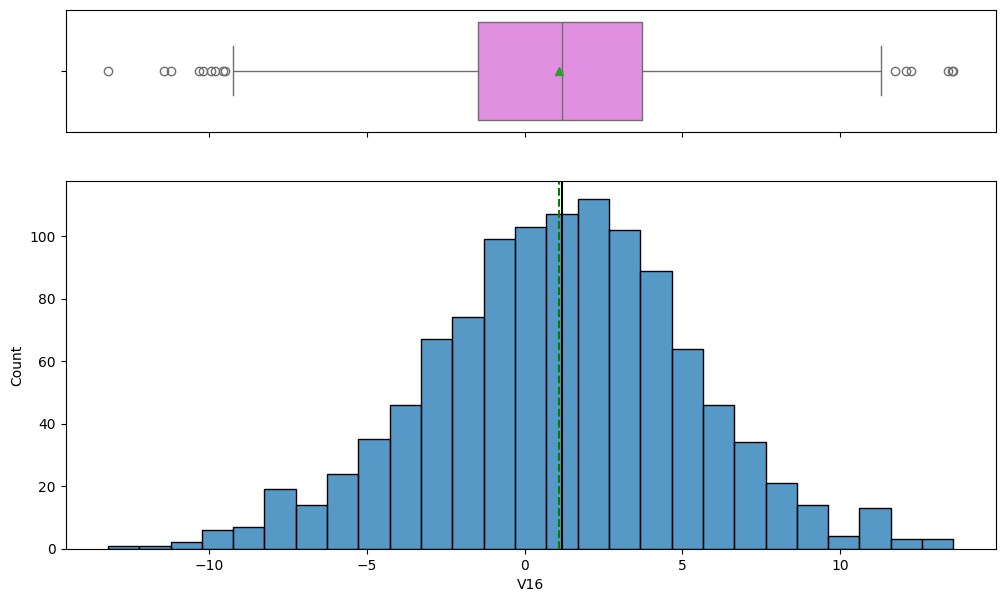

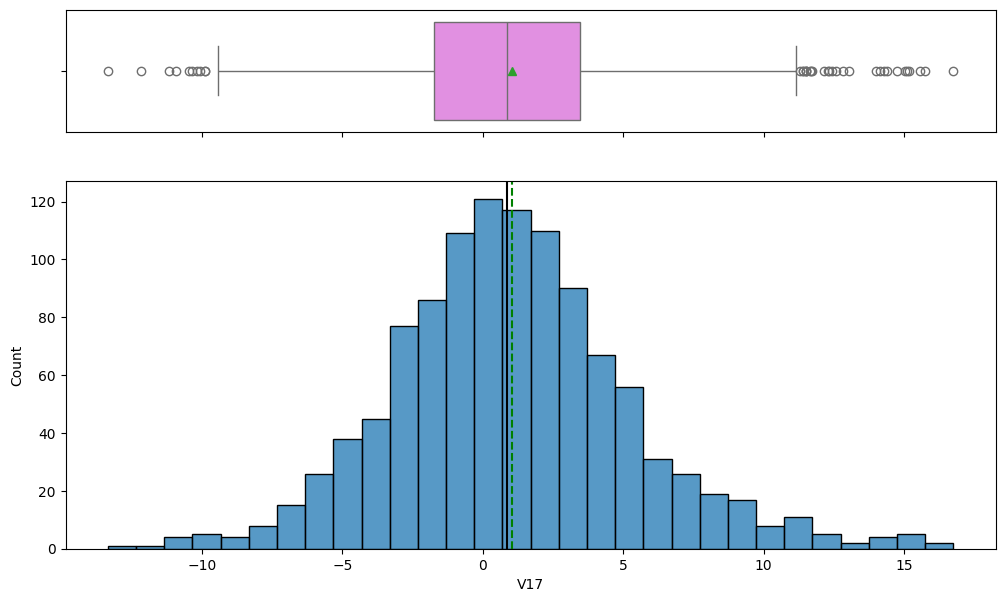

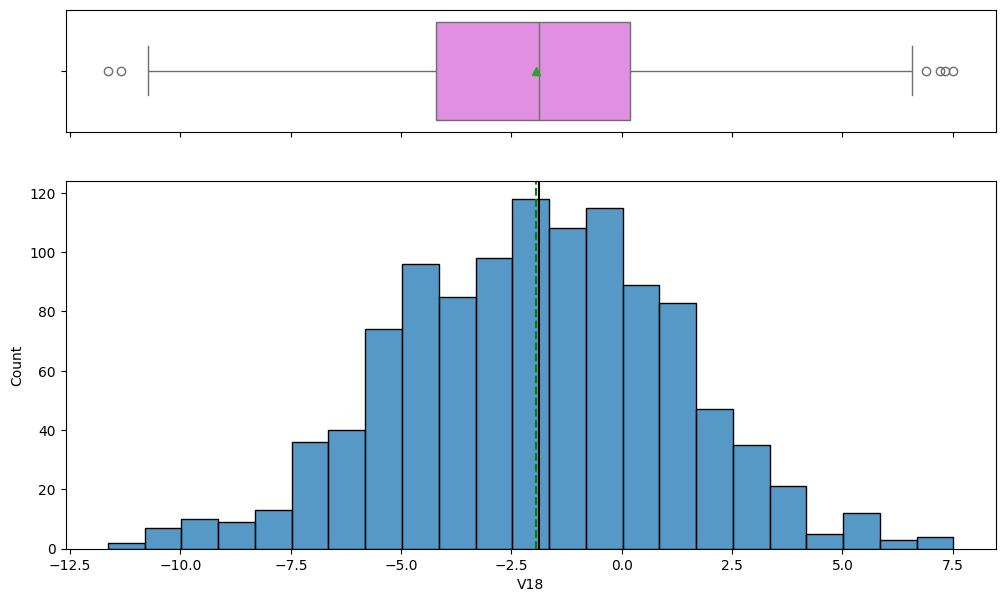

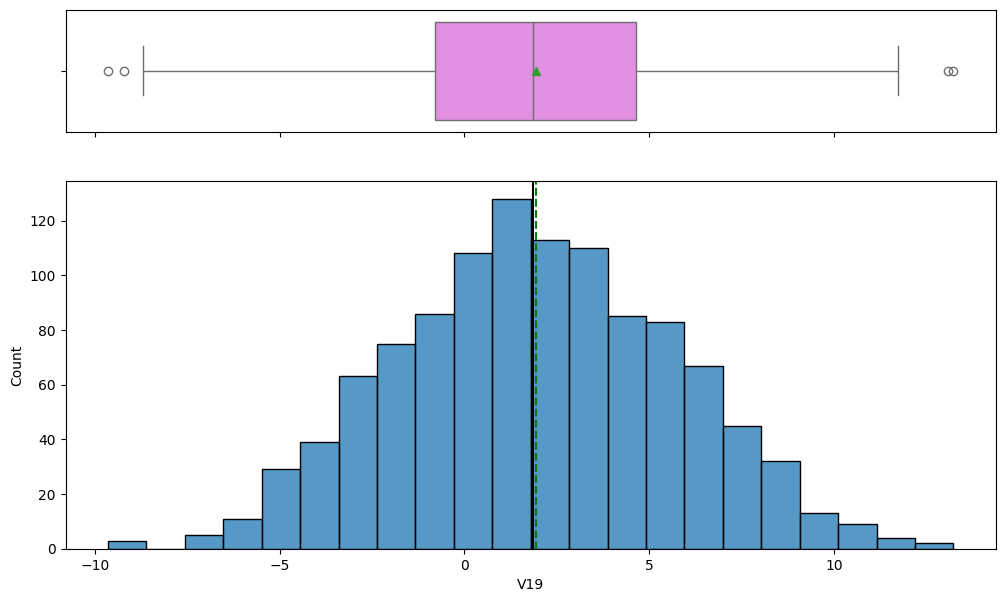

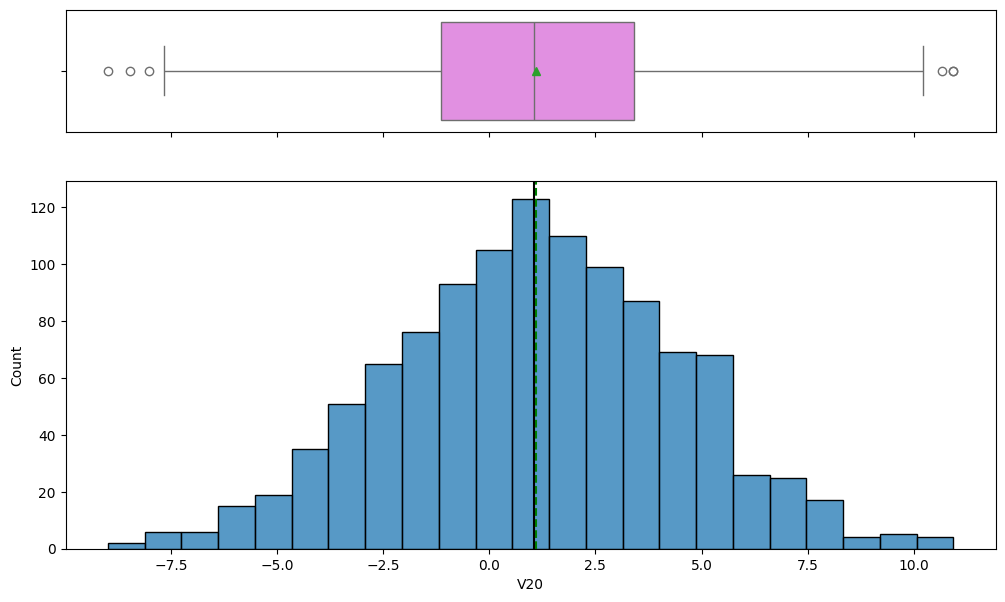

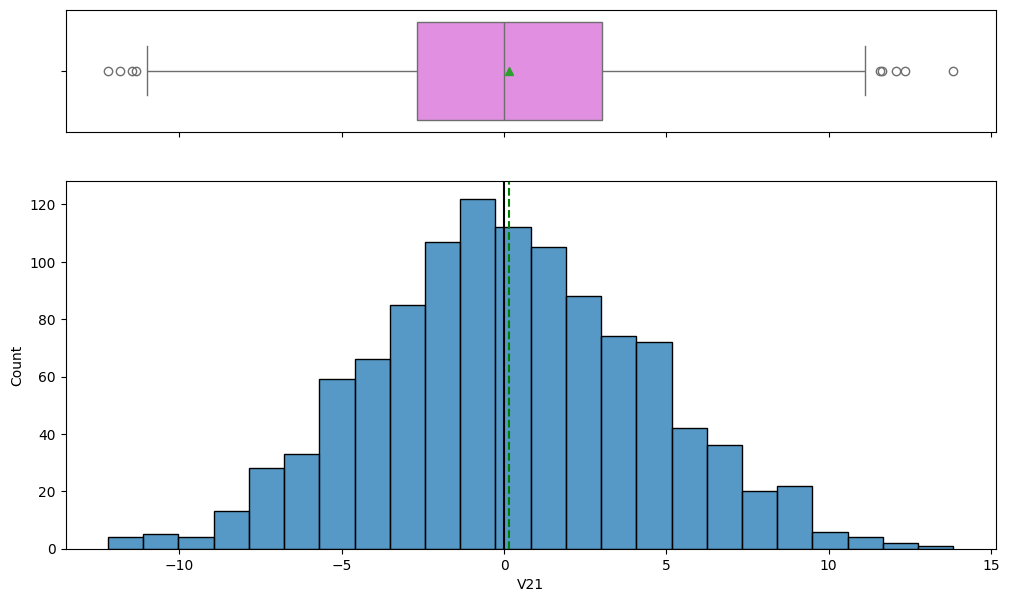

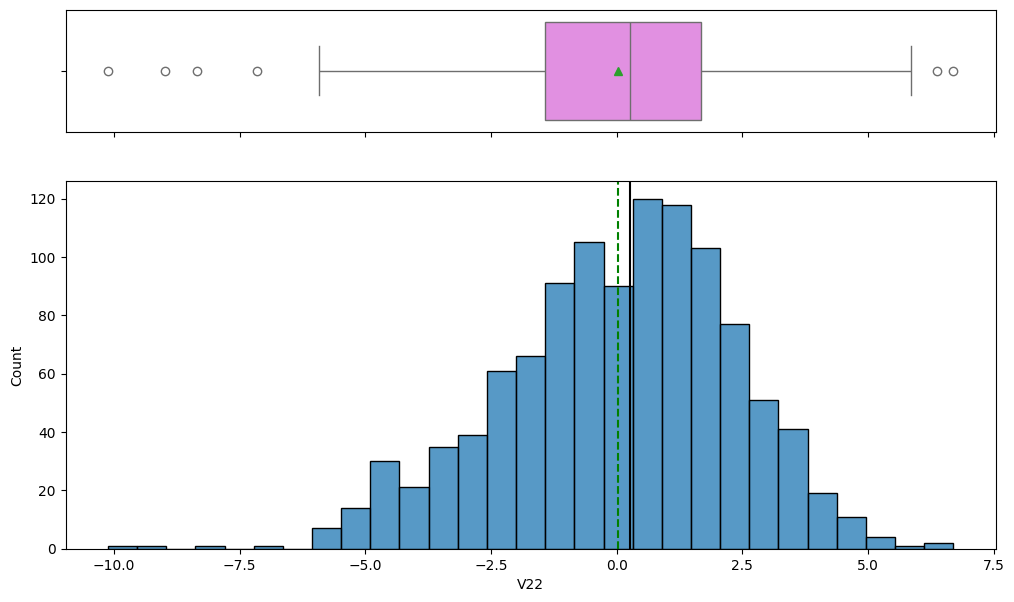

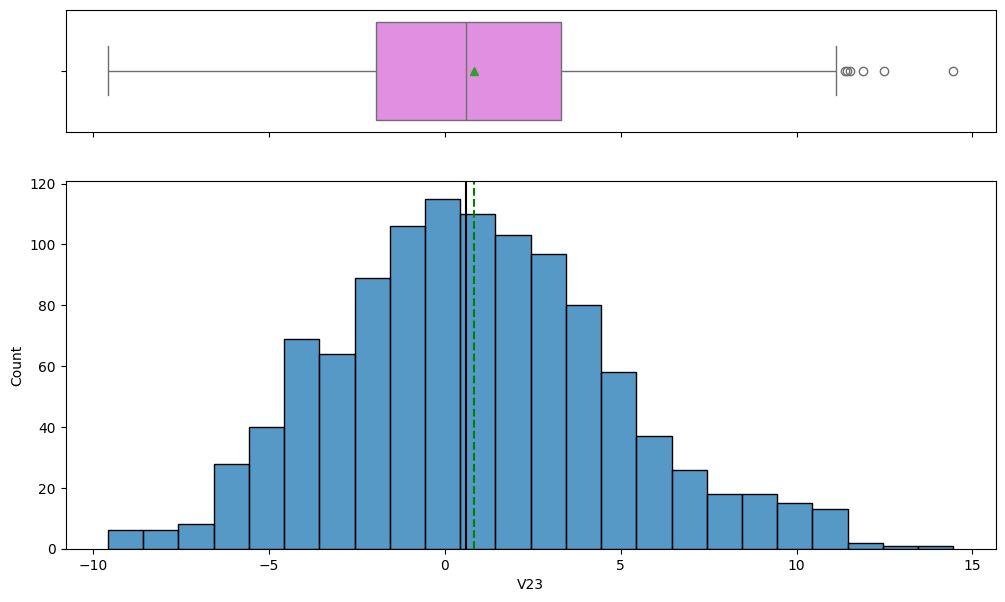

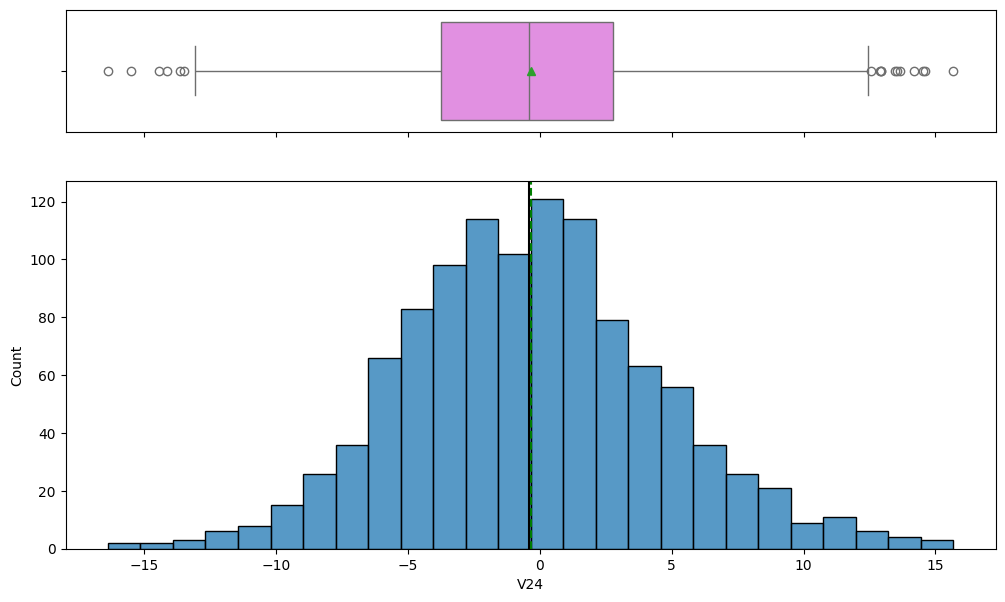

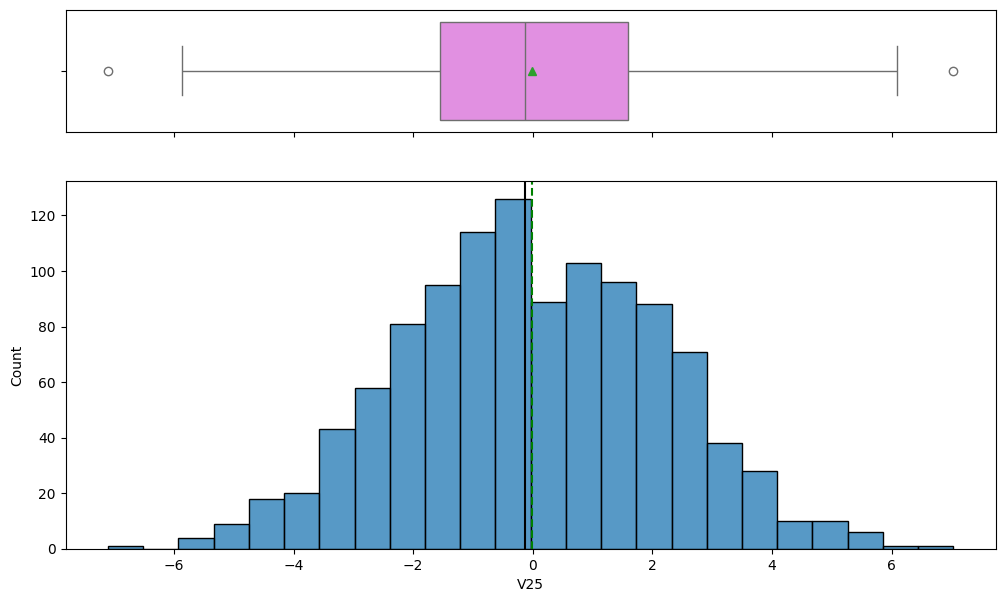

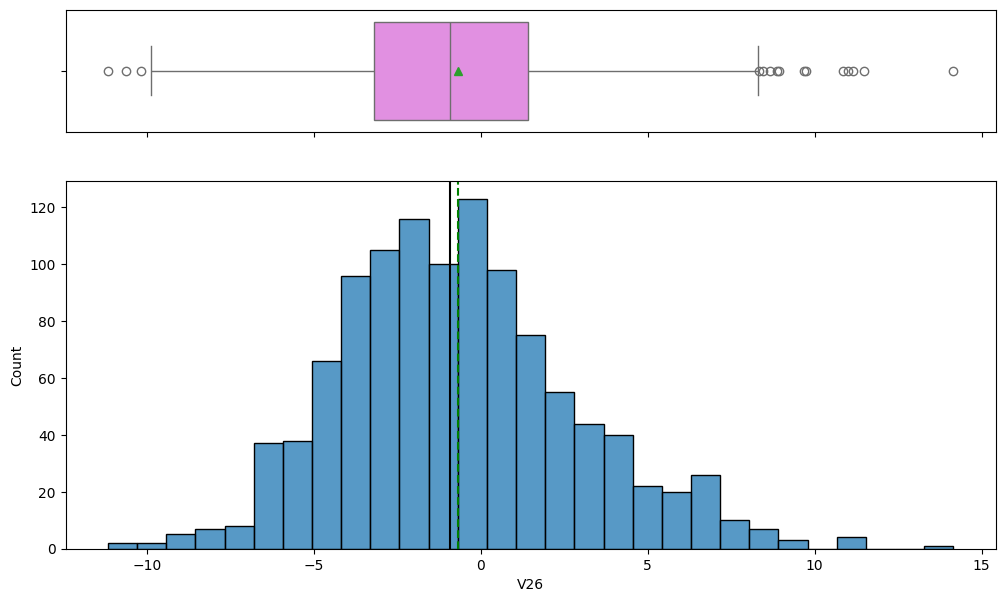

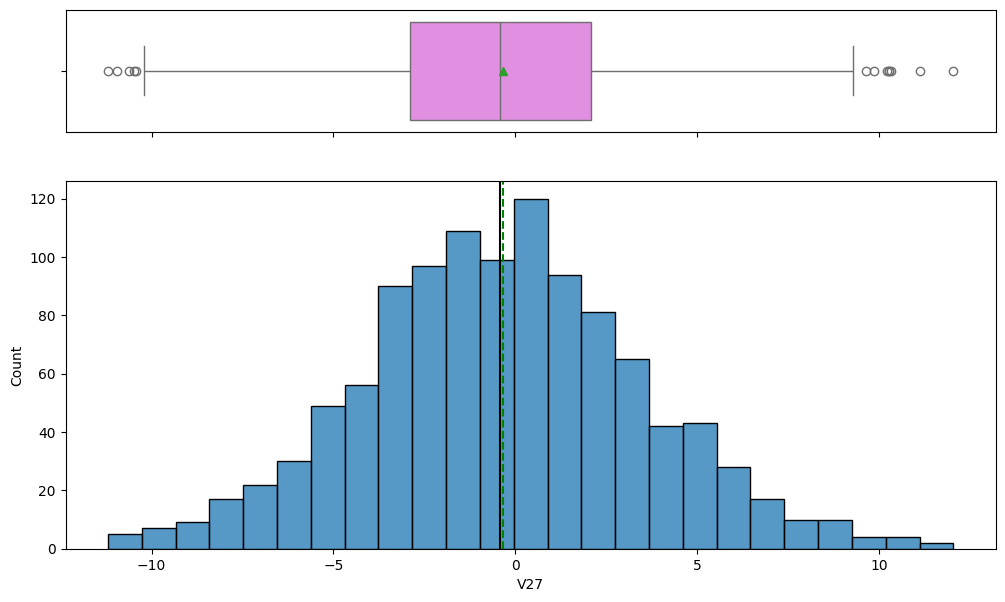

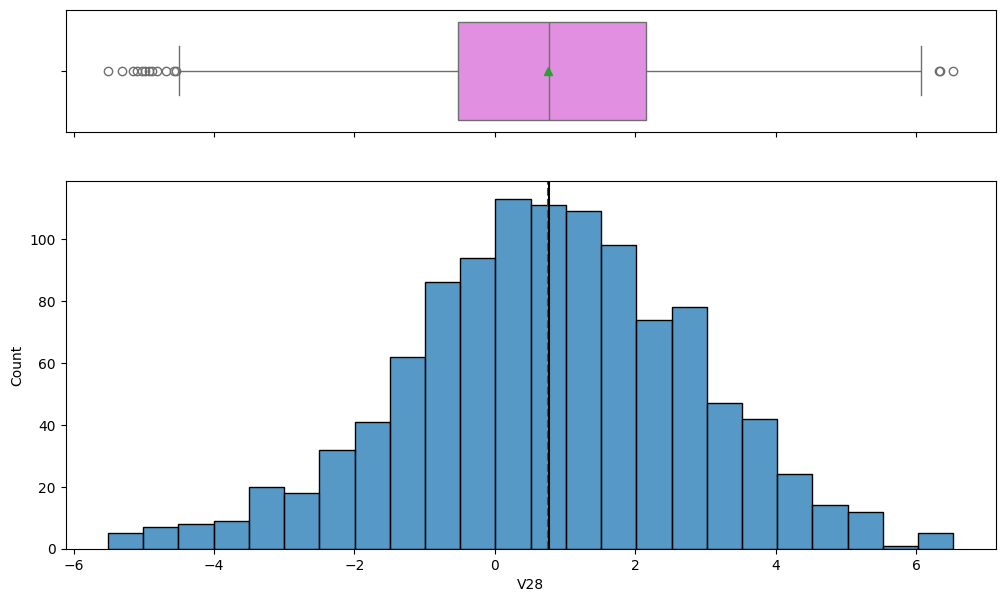

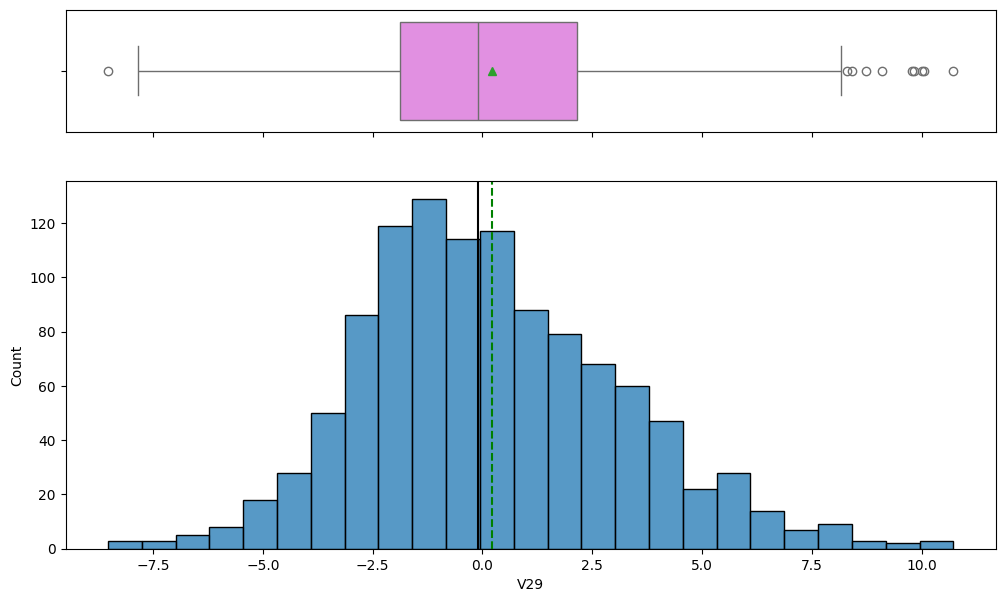

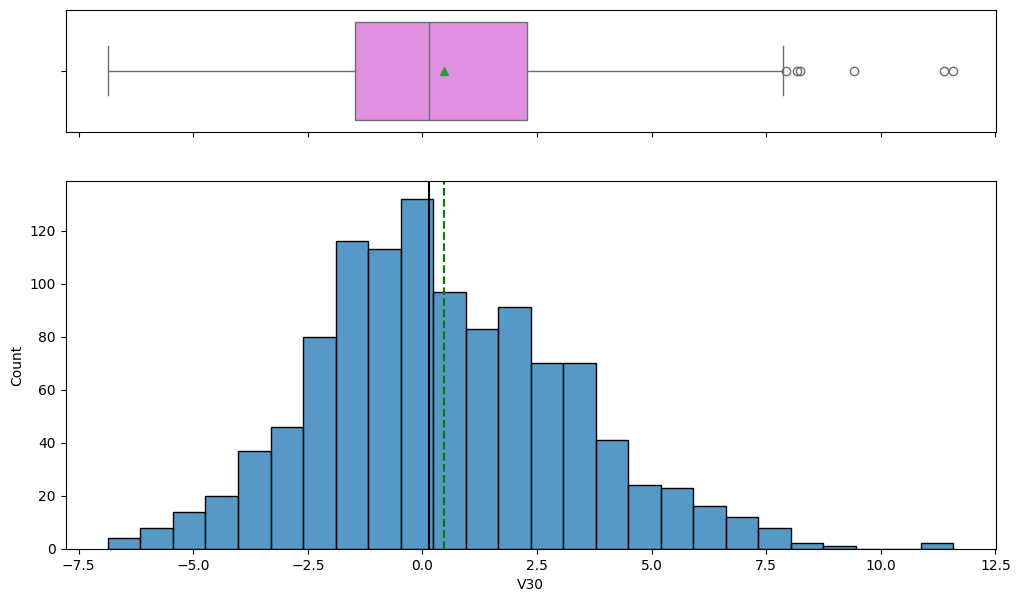

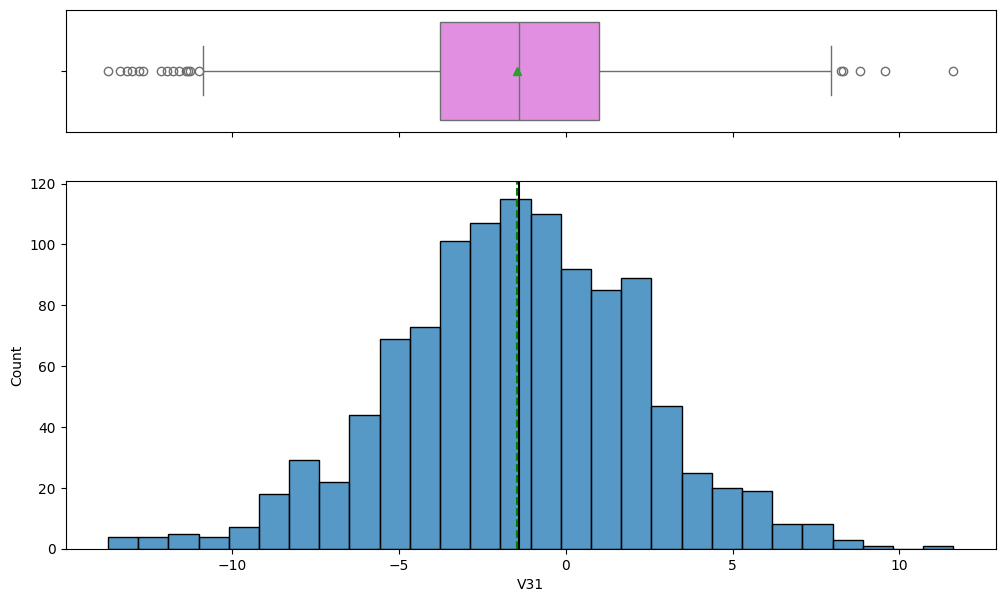

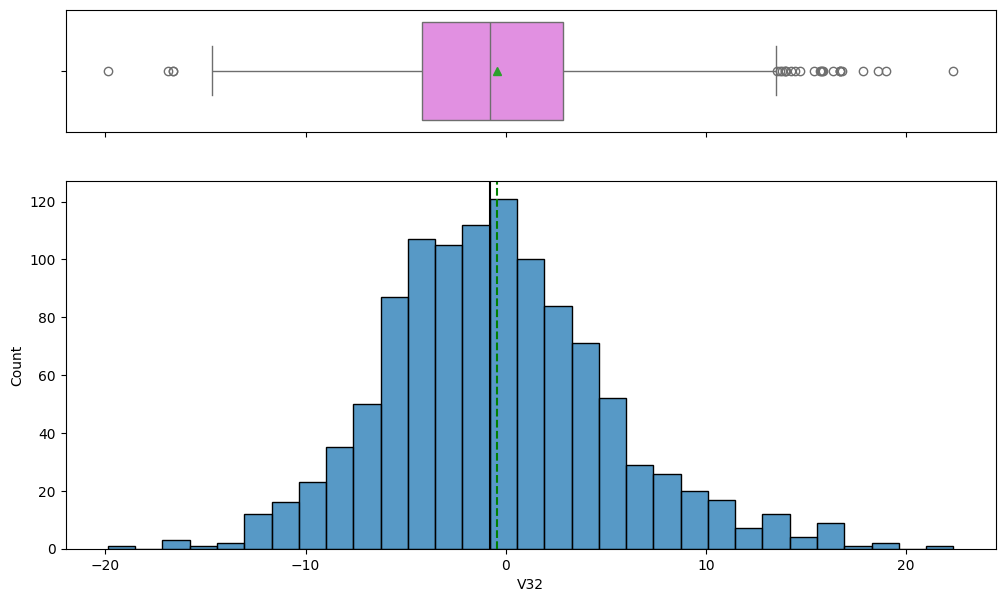

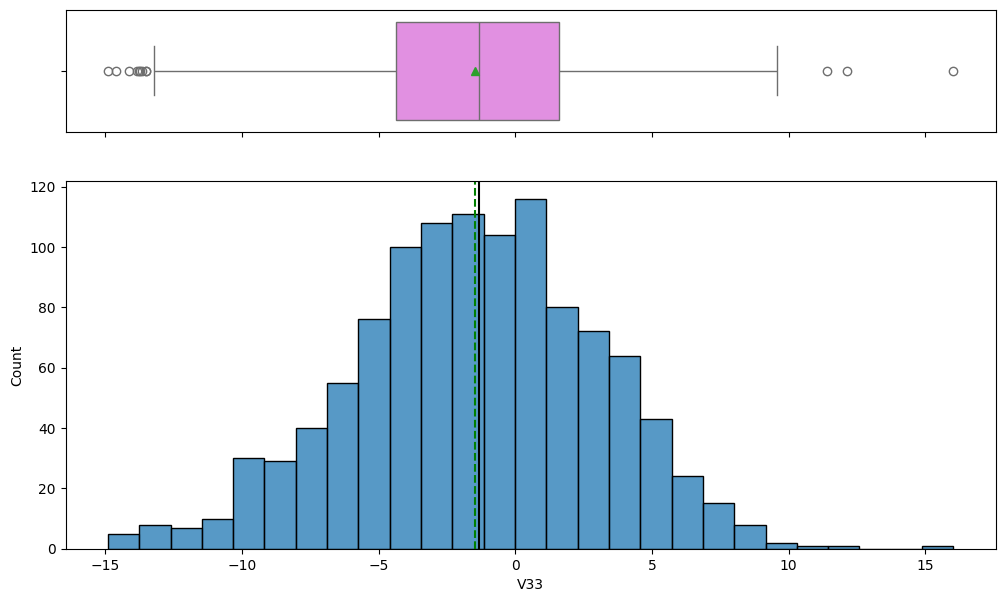

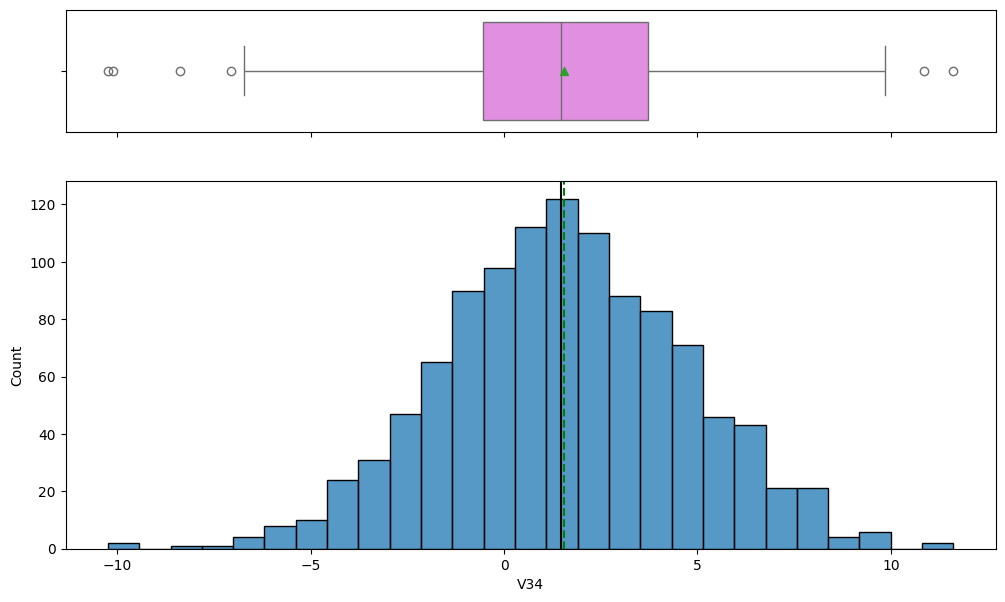

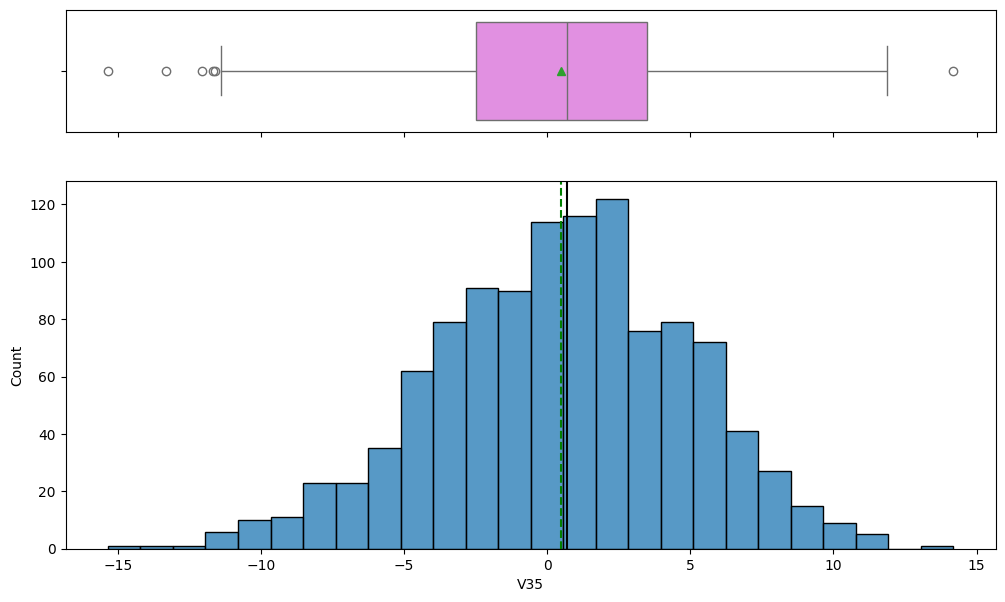

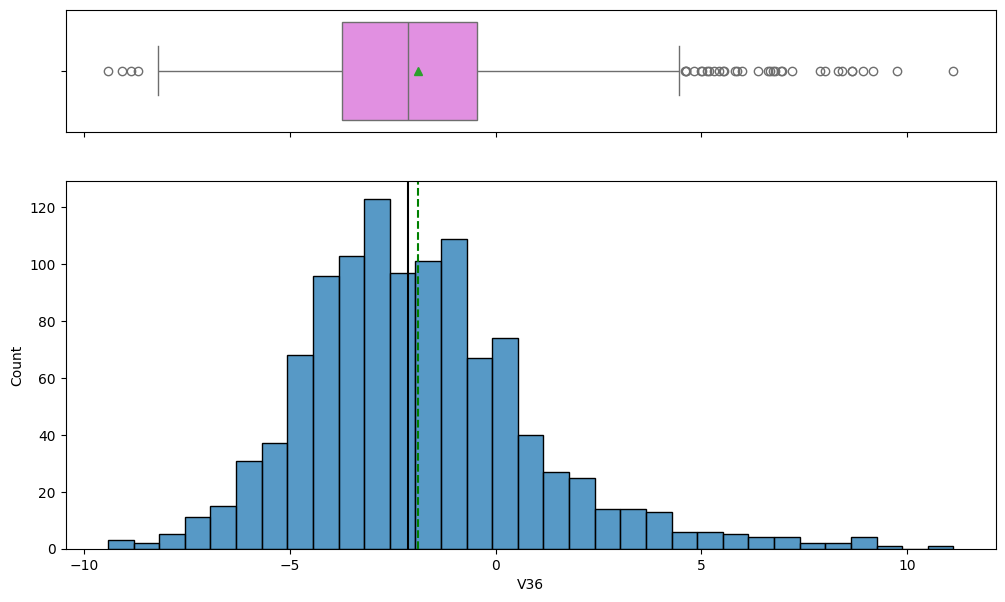

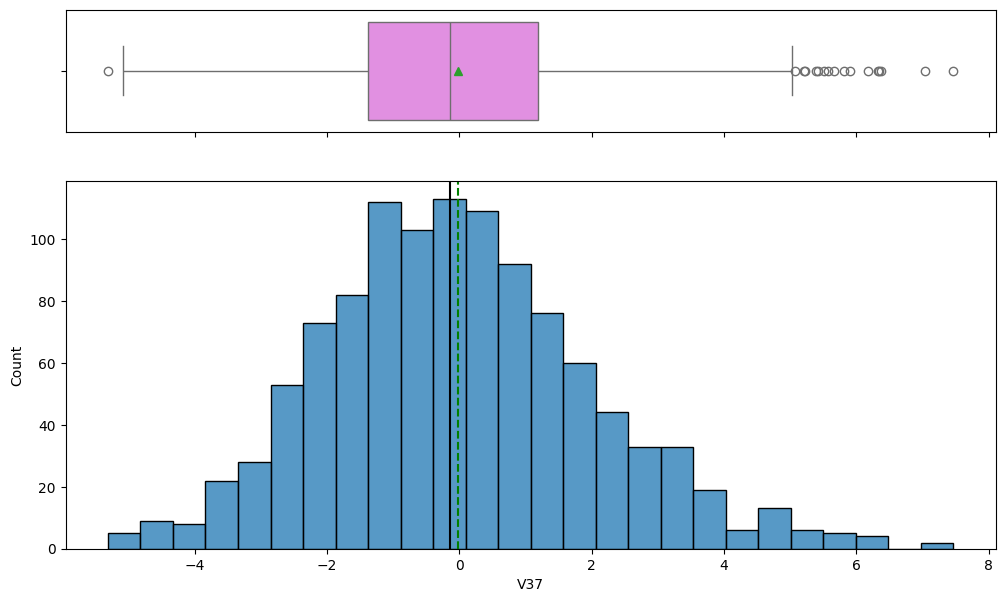

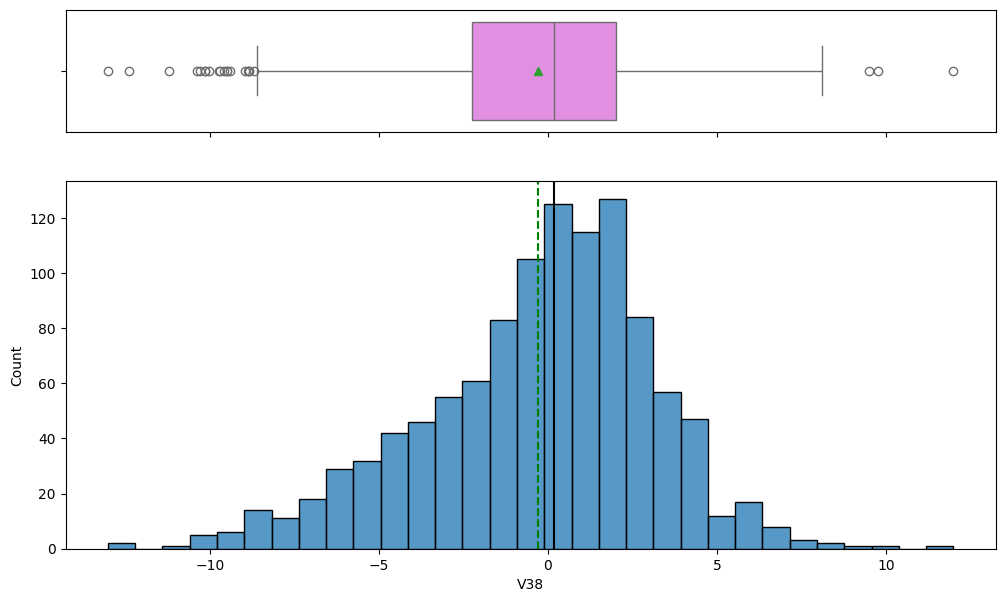

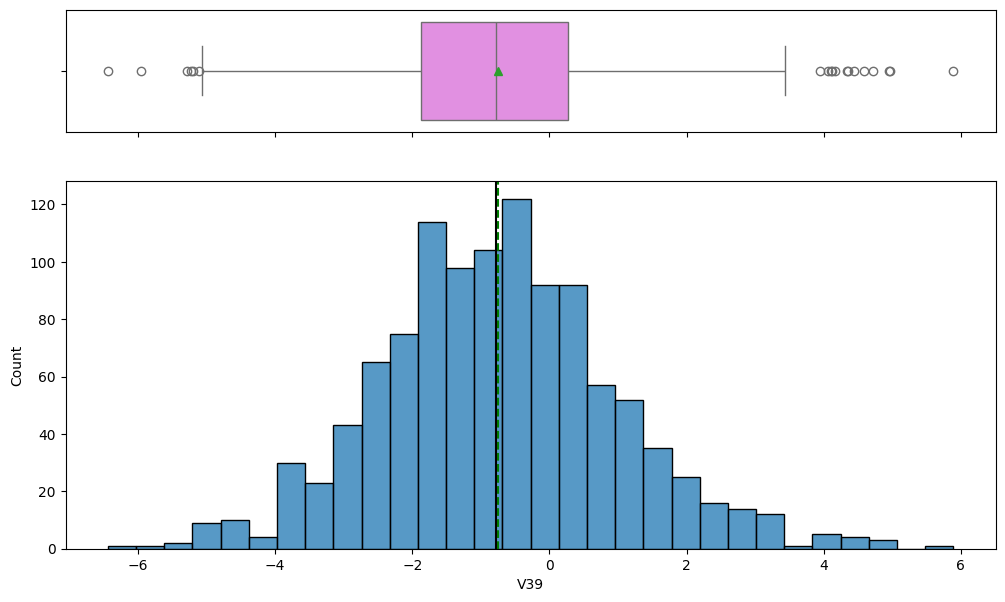

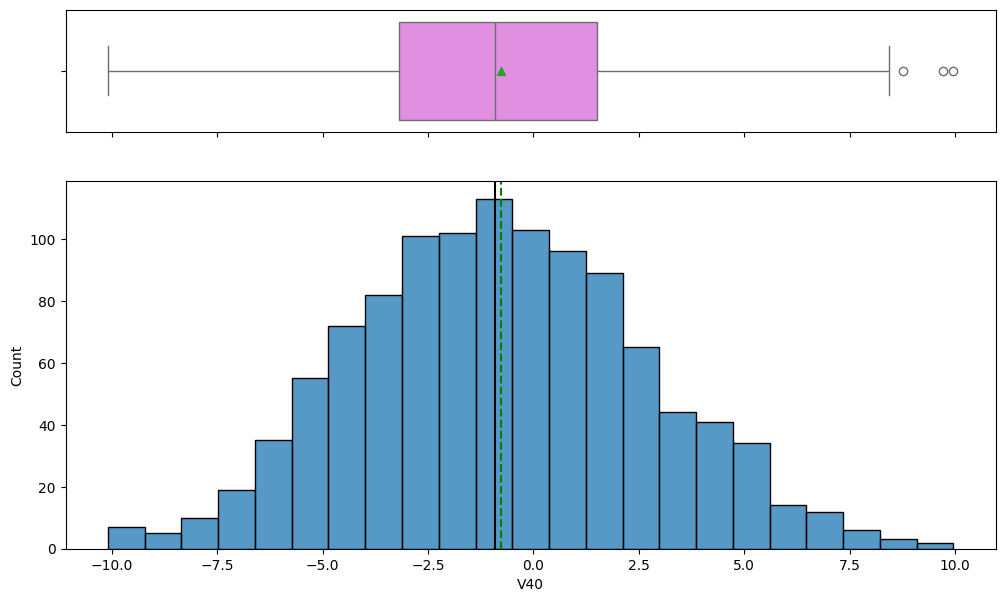

In [19]:
for feature in fail.columns[fail.dtypes=='float64']:
    histogram_boxplot(fail, feature, figsize=(12, 7), kde=False, bins=None)

- All of the sensor variables appear normally distributed for both the training and testing data
- Now looking at missing value treatment, for those in `V1` and `V2` in both dataframes, simply filling them in with a median value should be sufficient

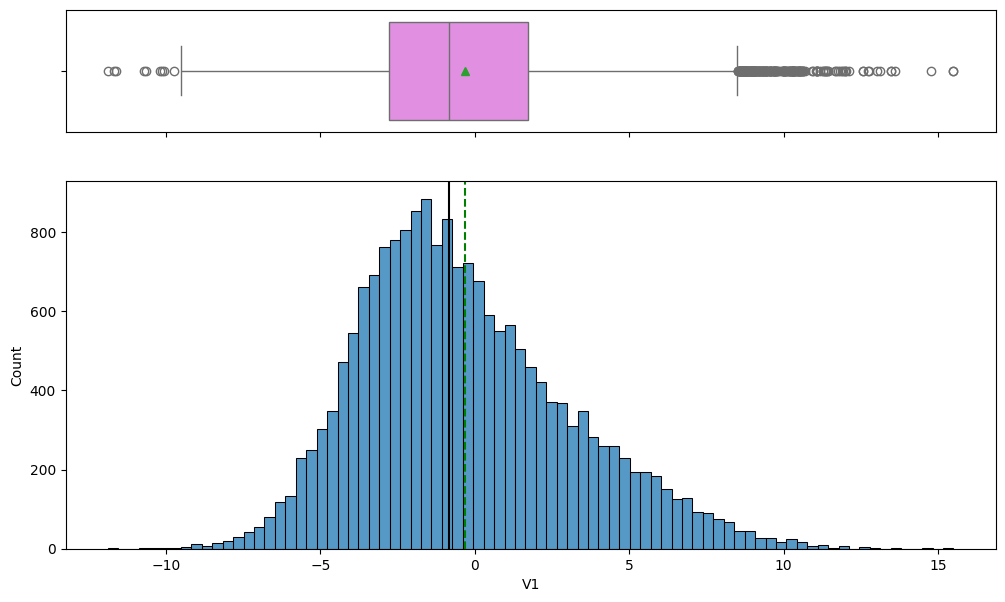

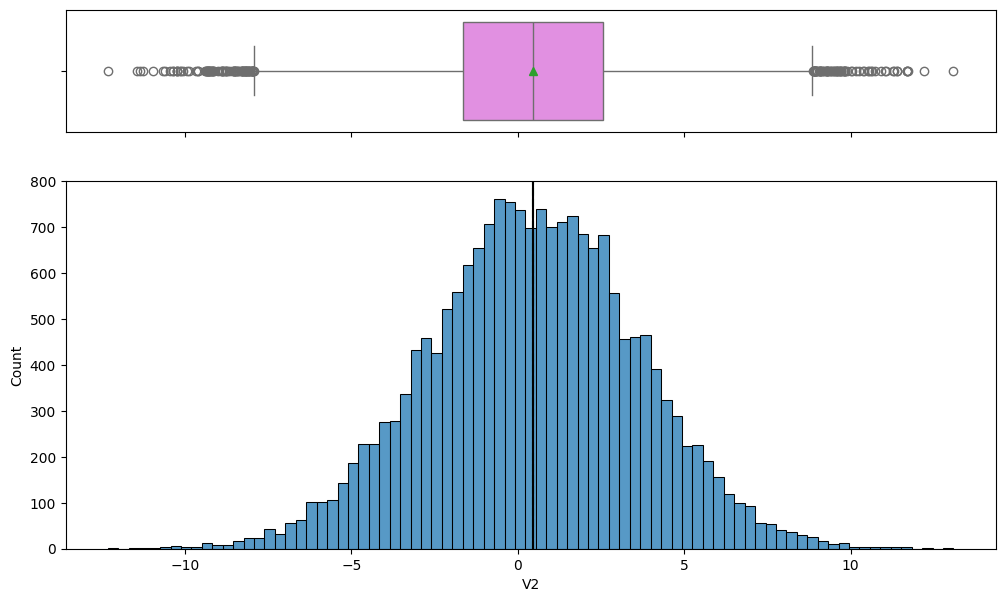

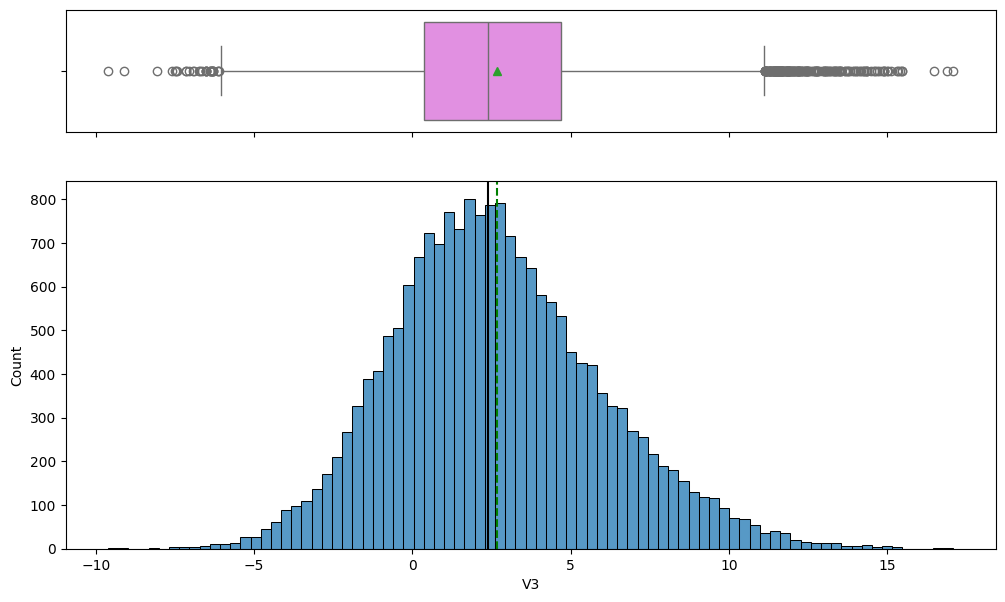

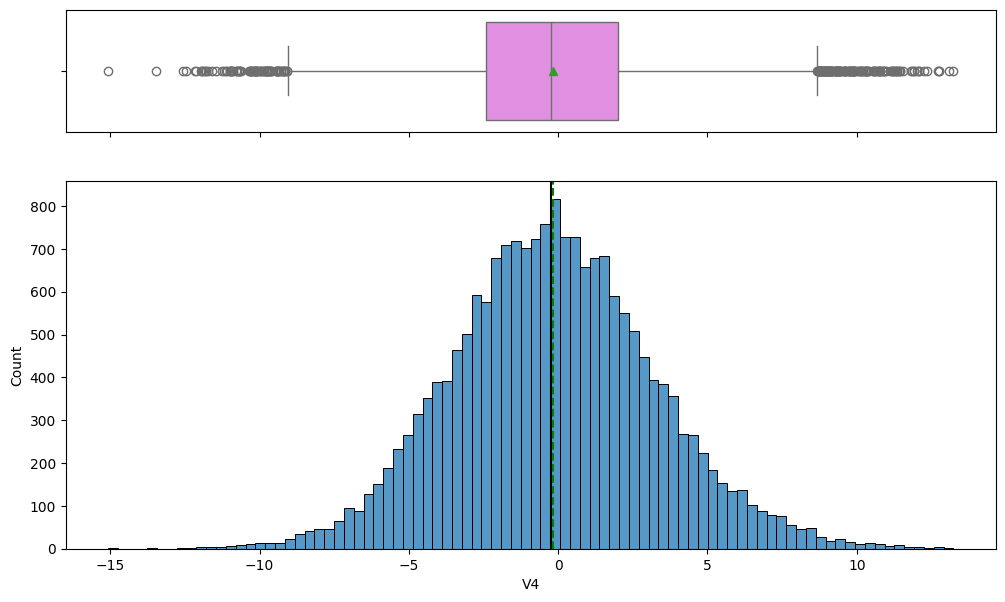

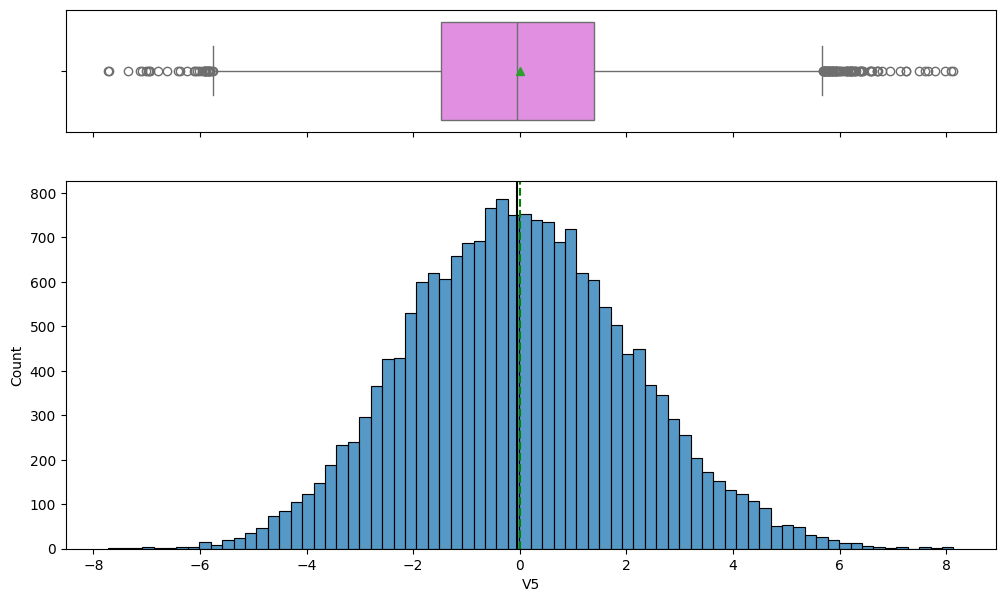

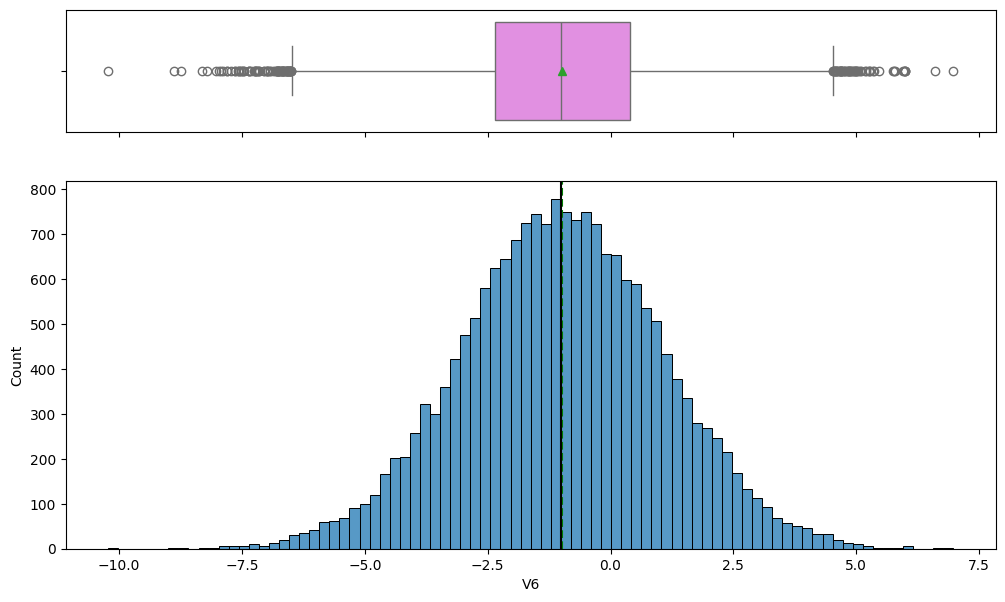

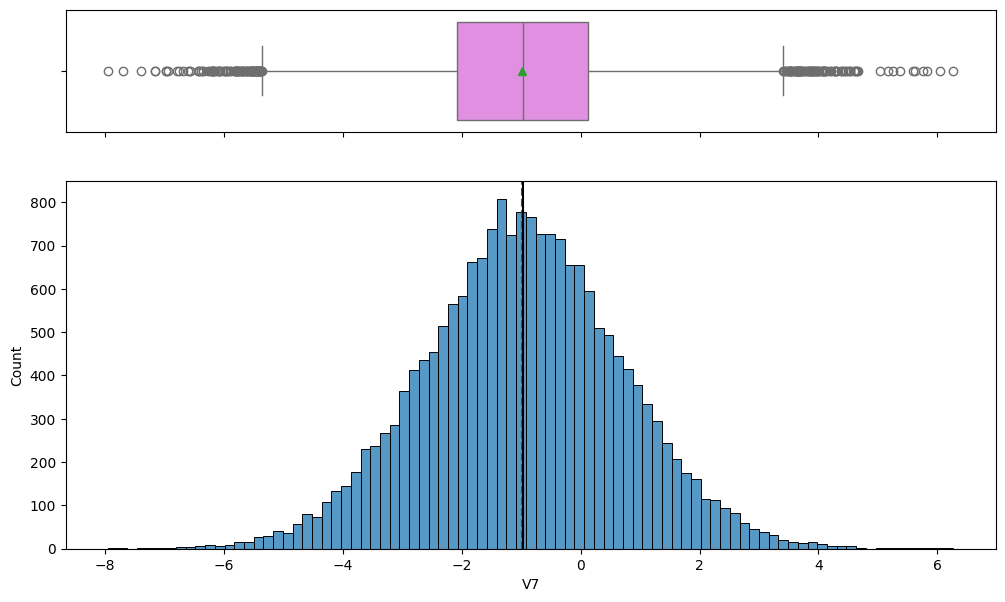

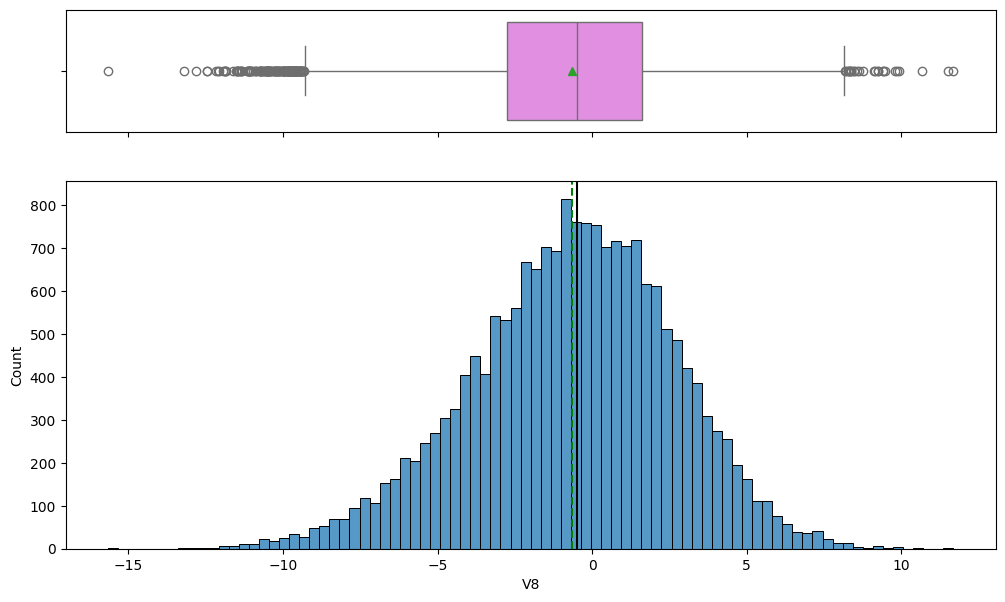

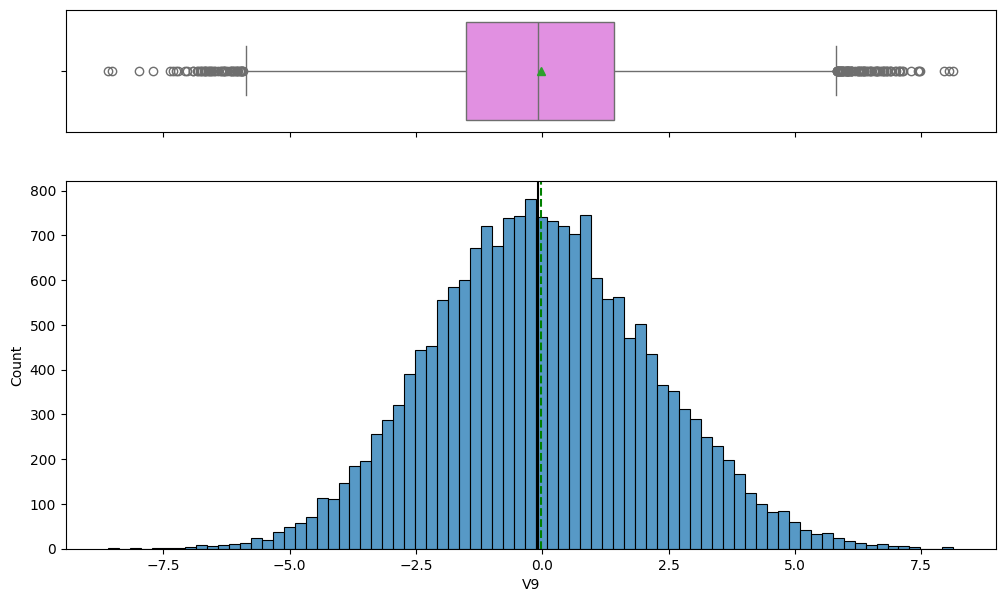

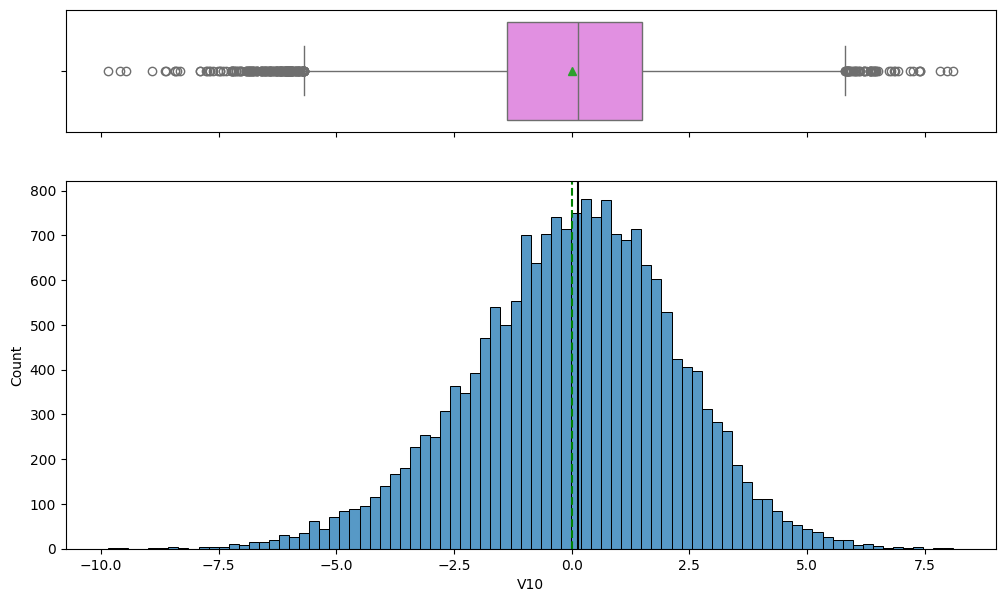

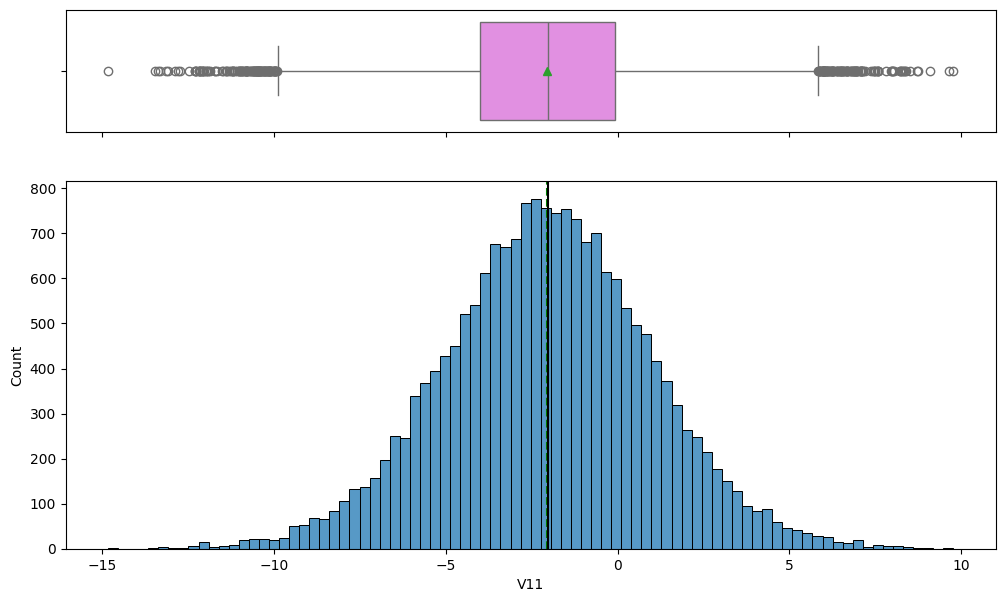

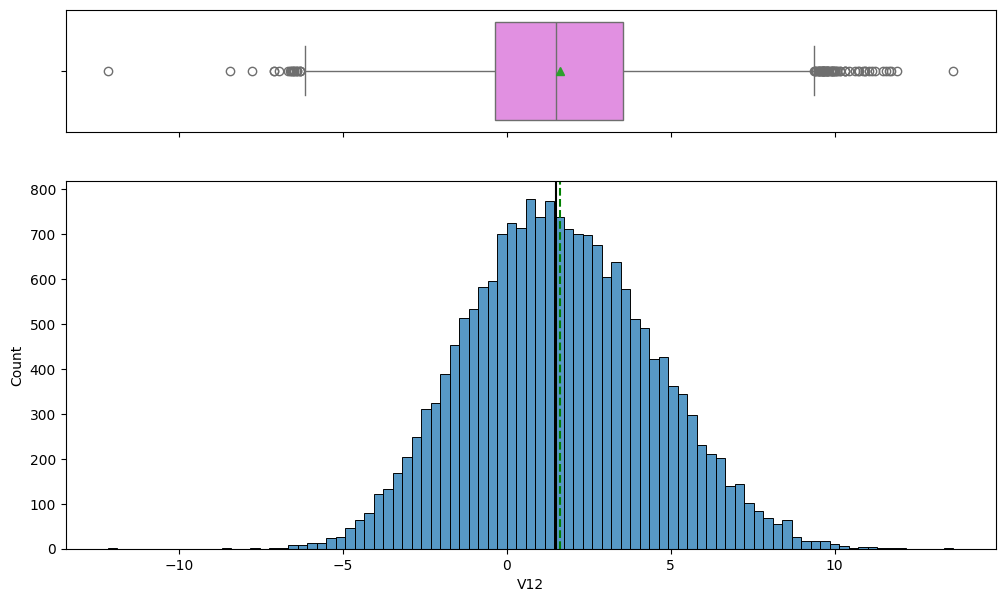

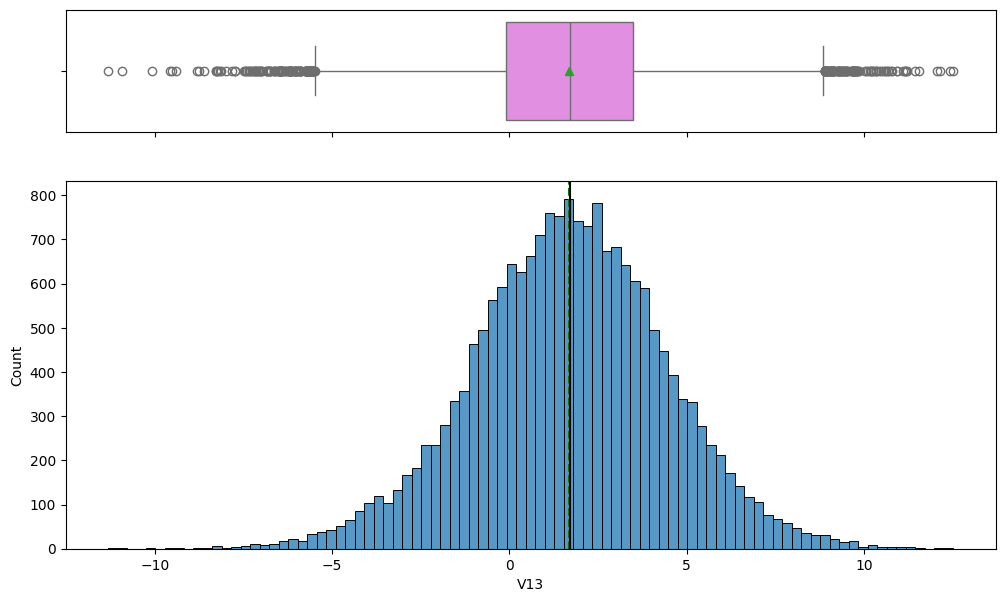

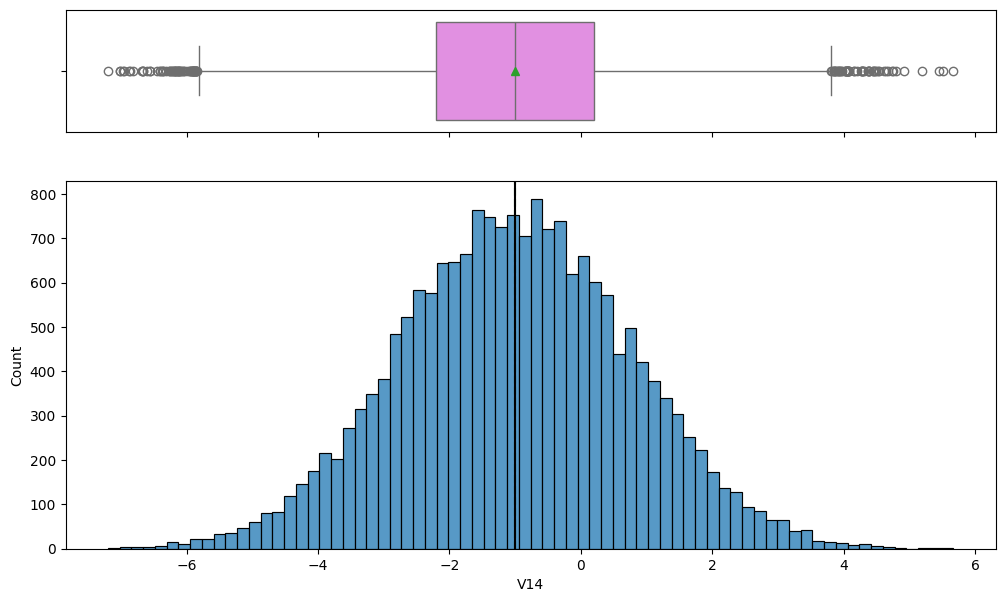

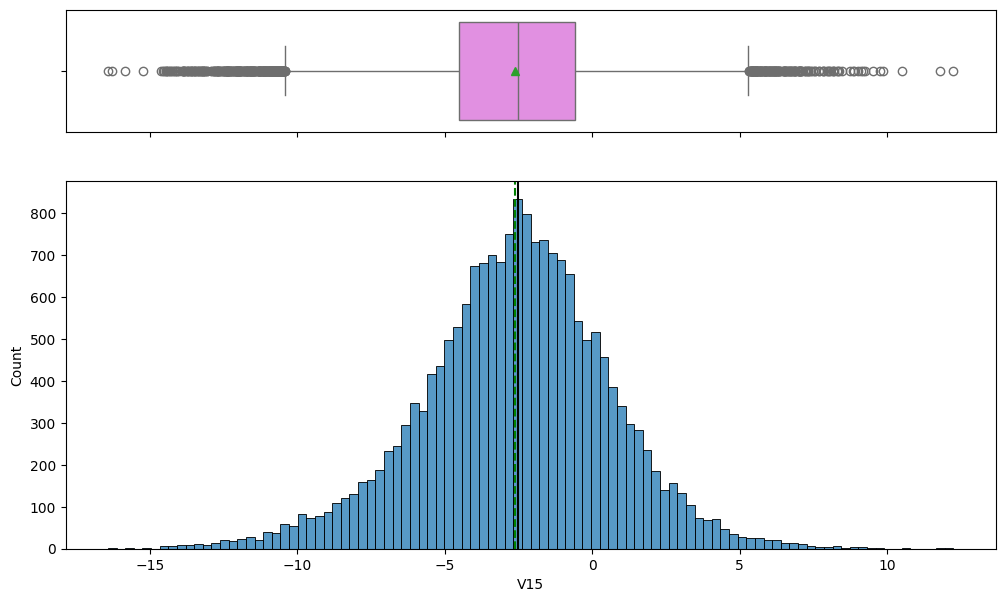

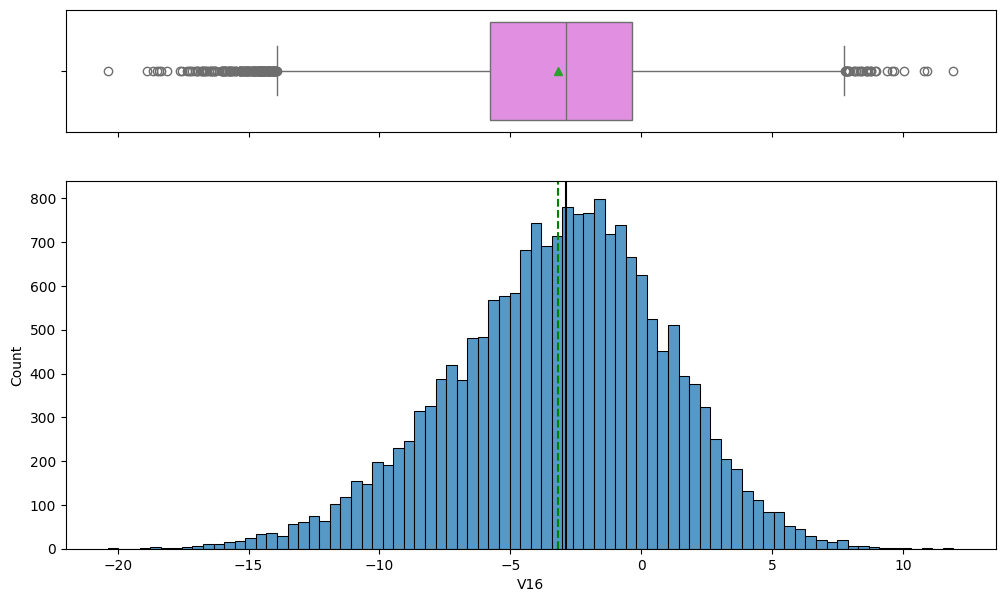

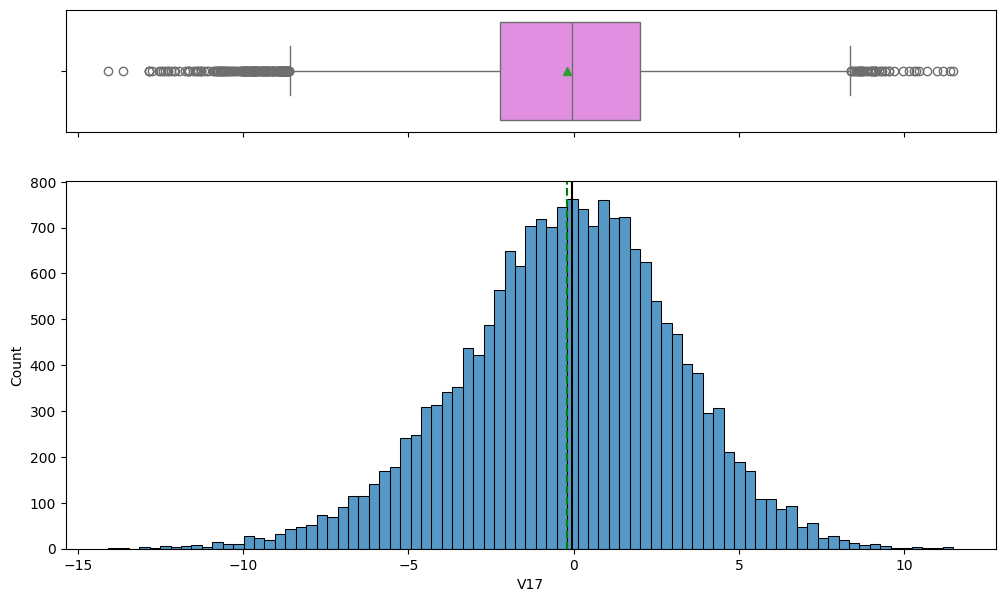

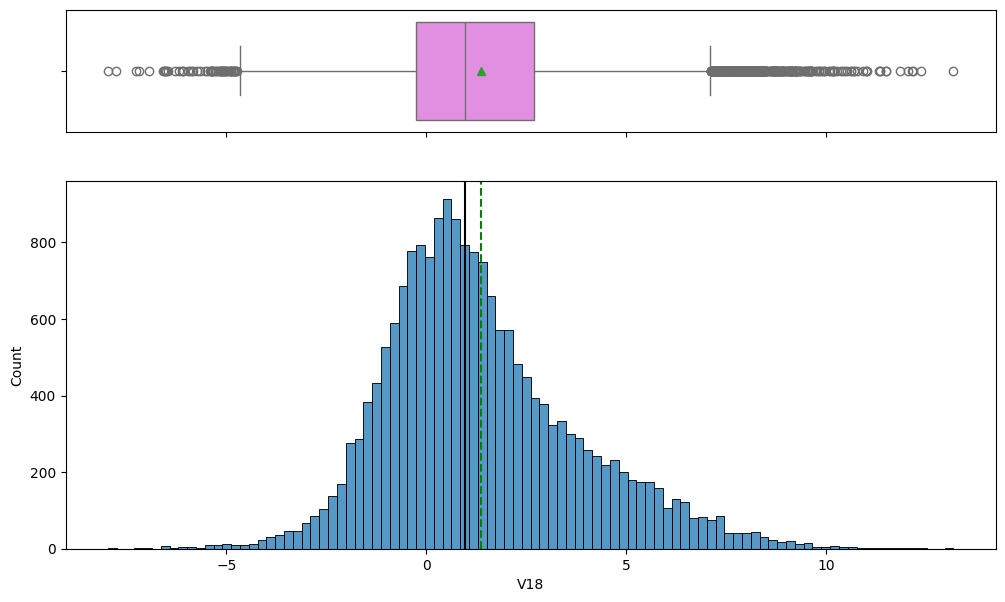

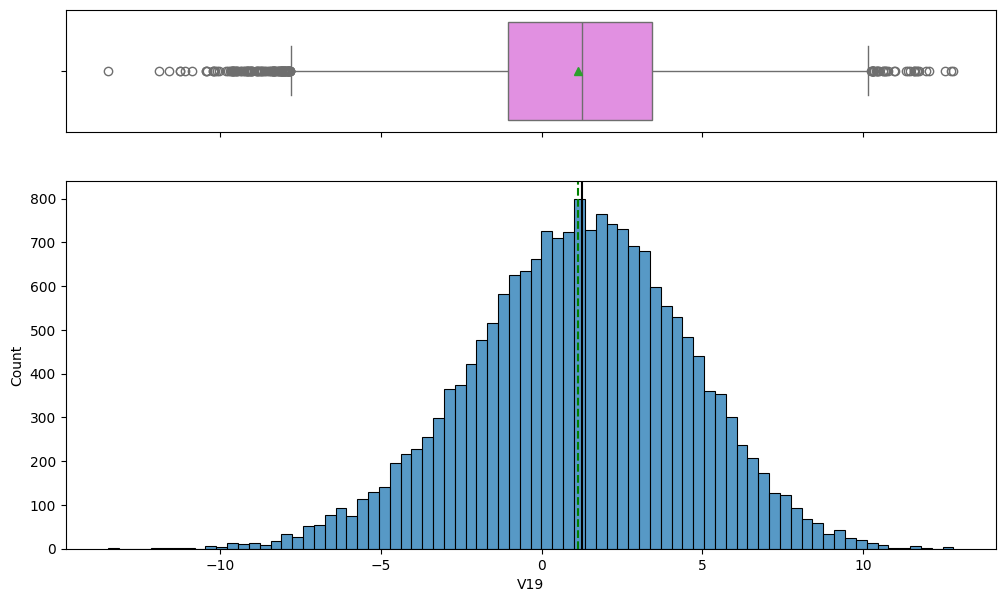

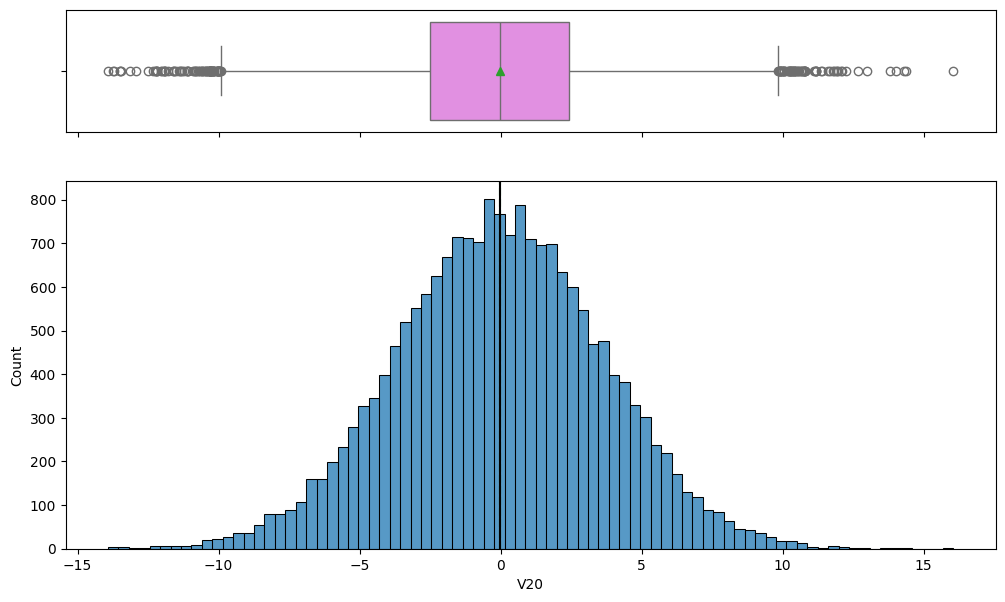

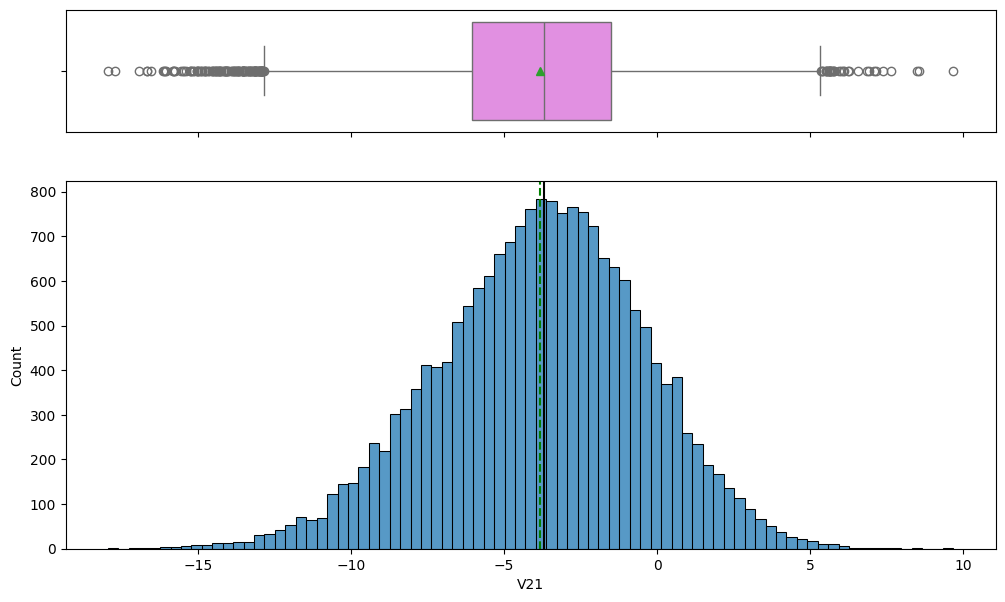

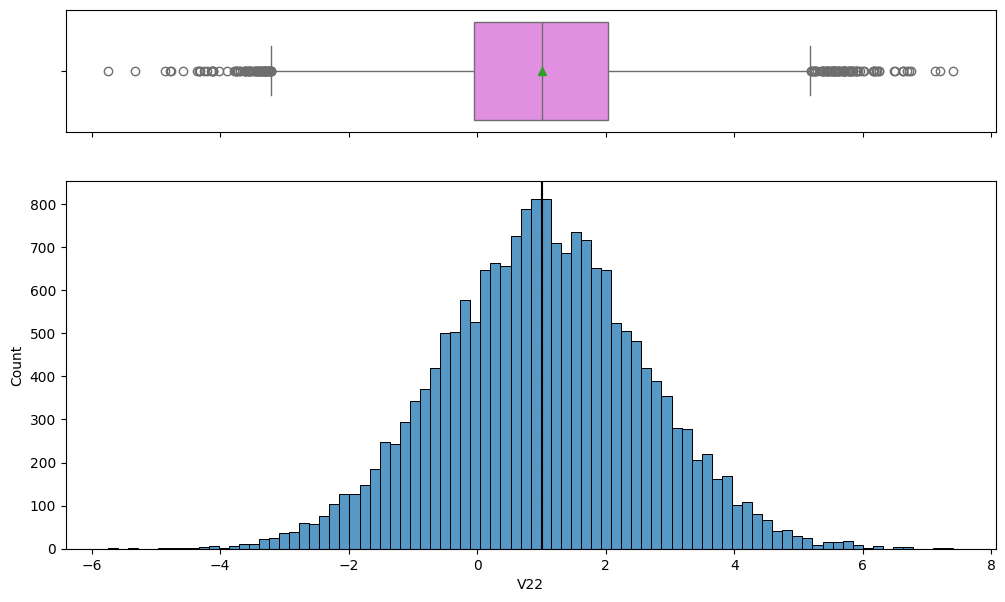

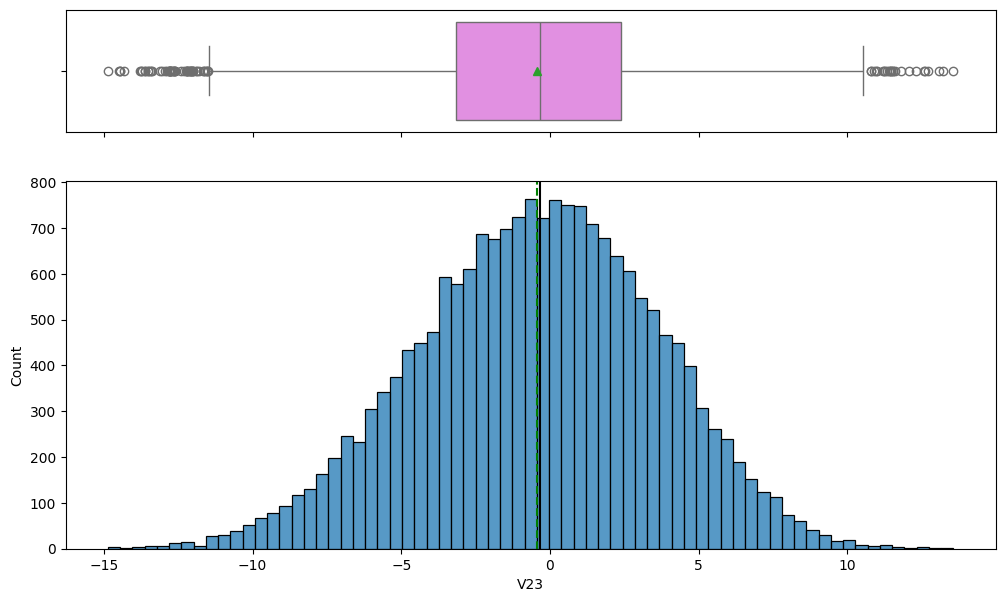

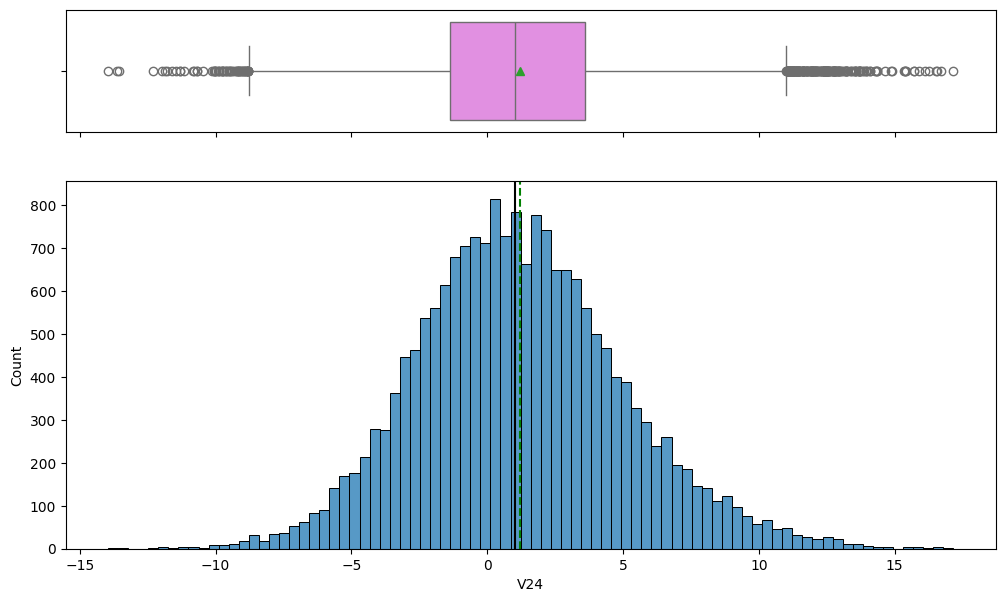

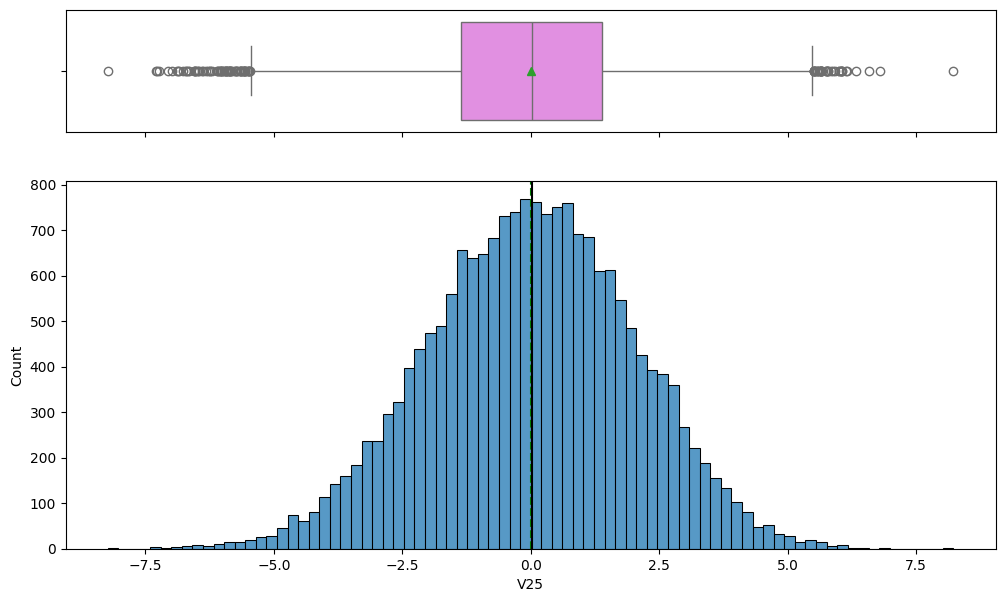

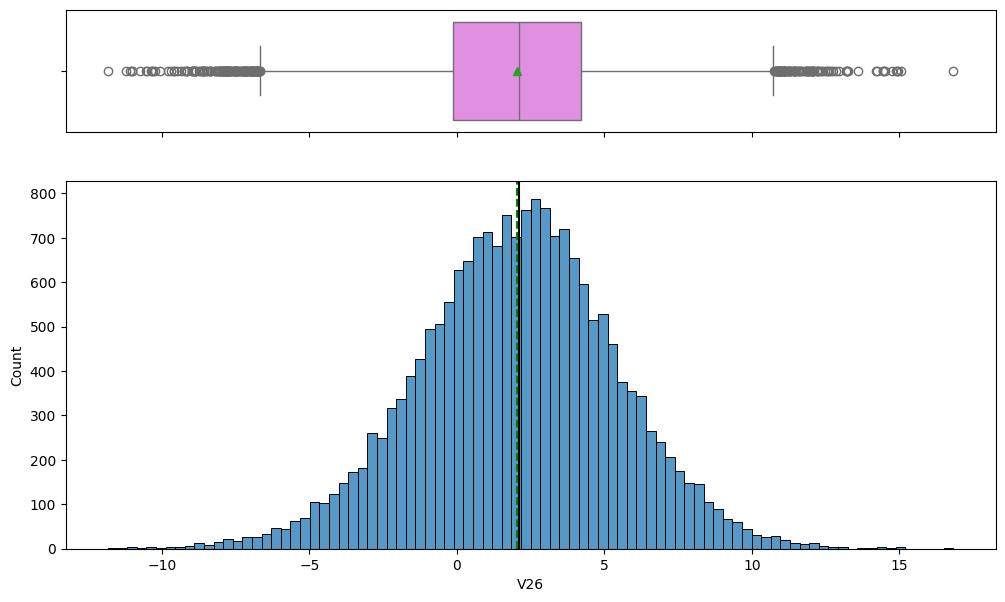

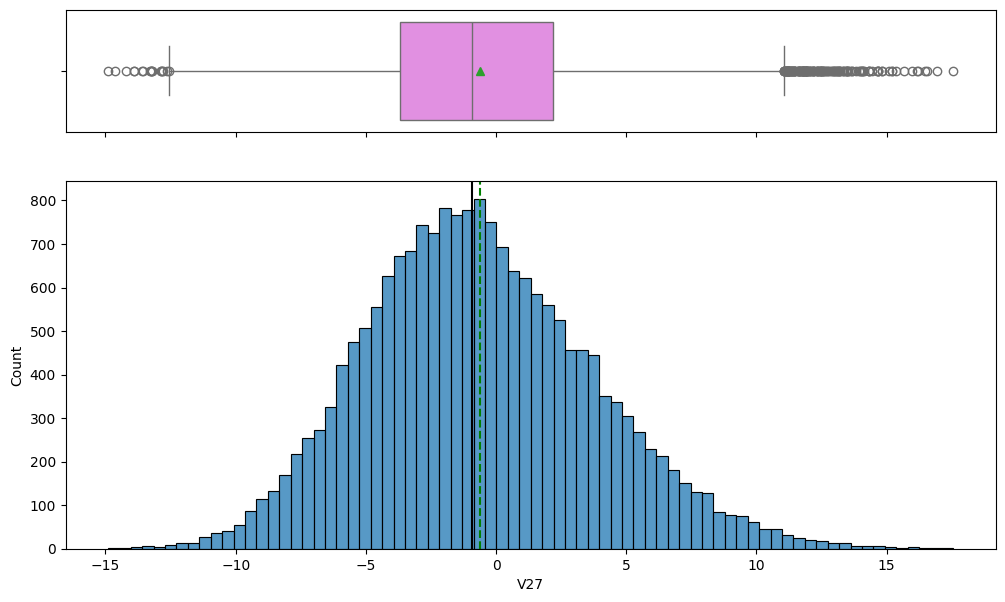

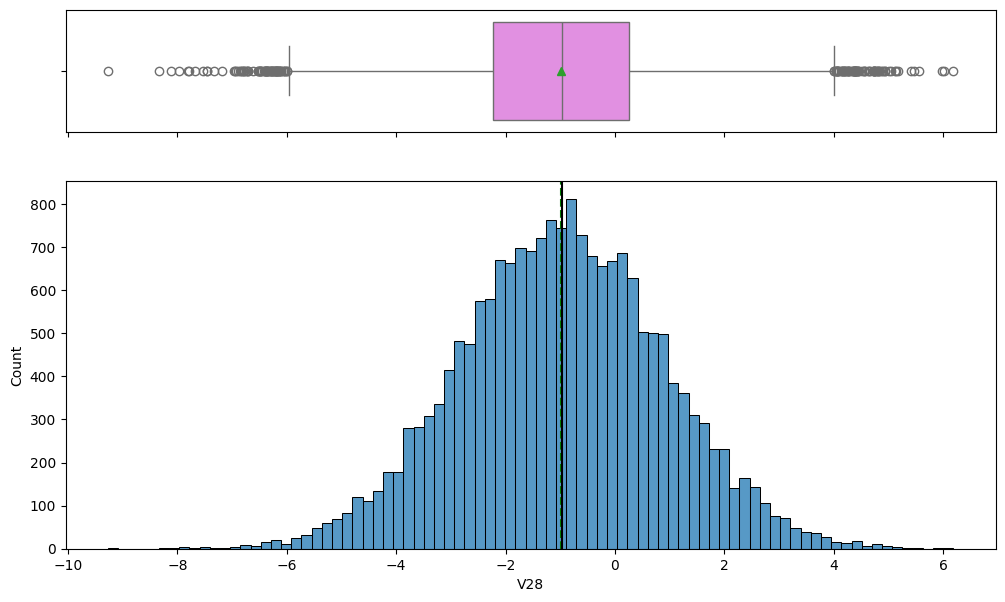

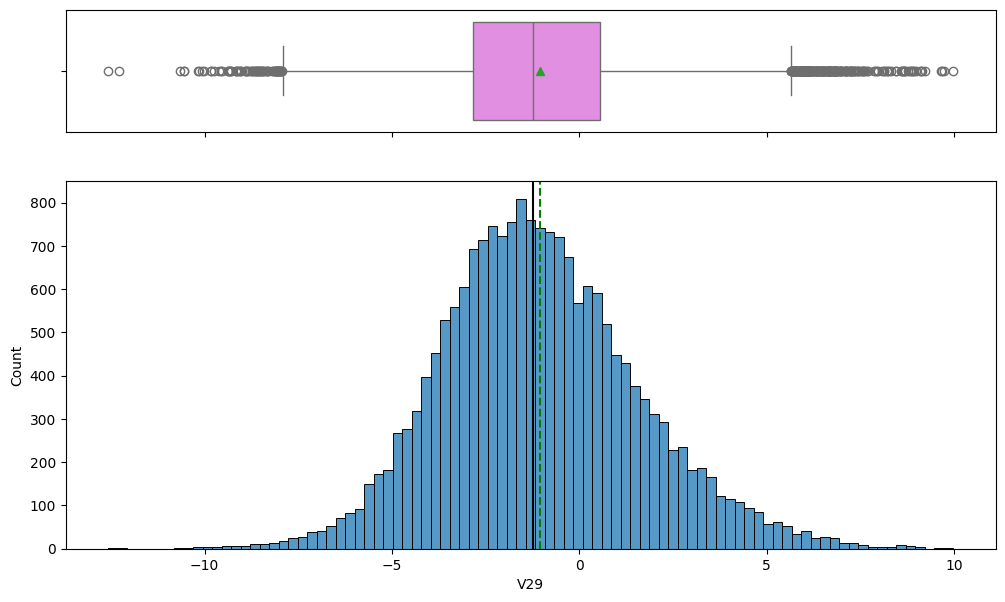

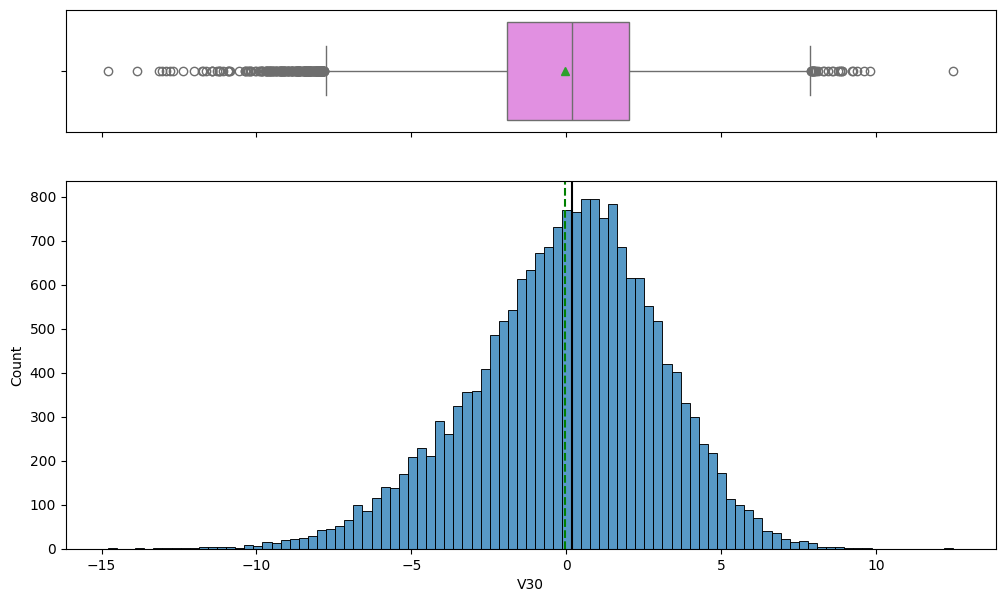

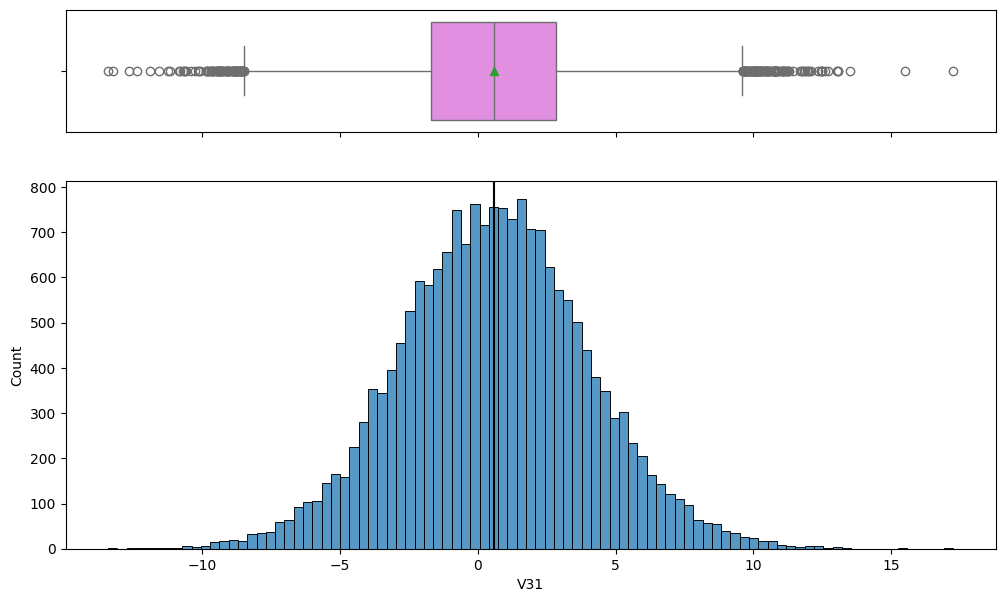

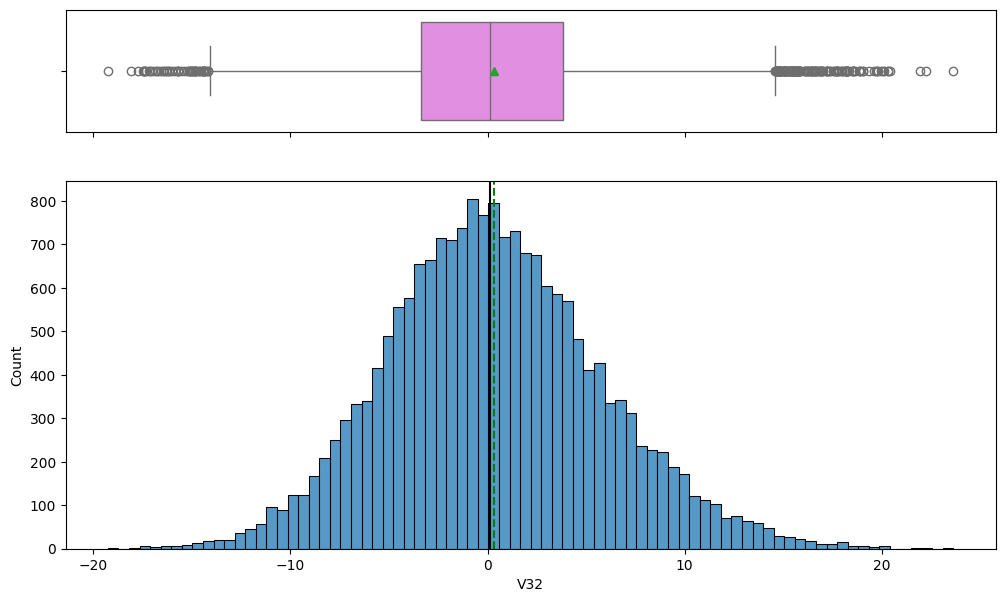

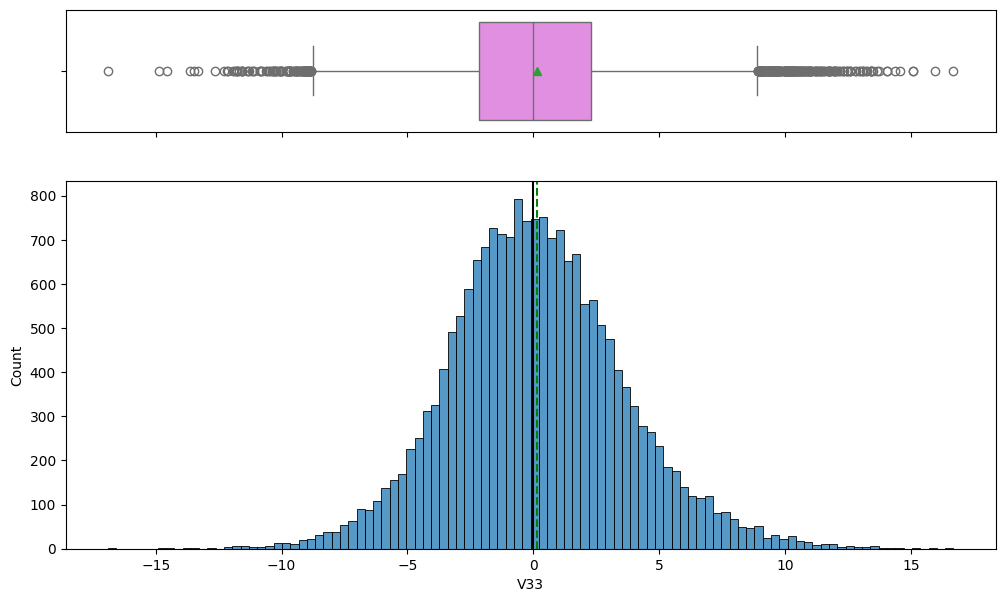

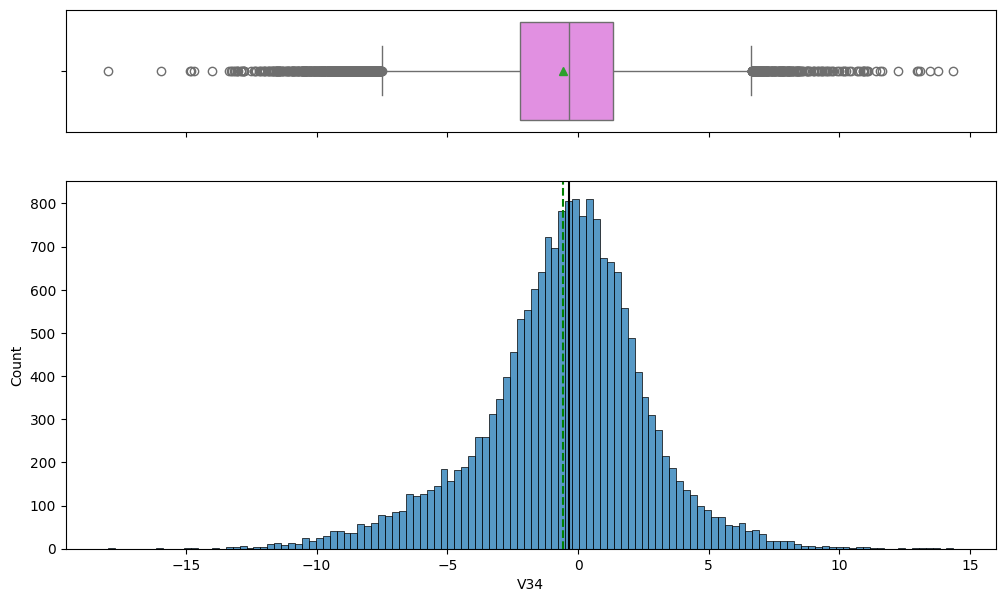

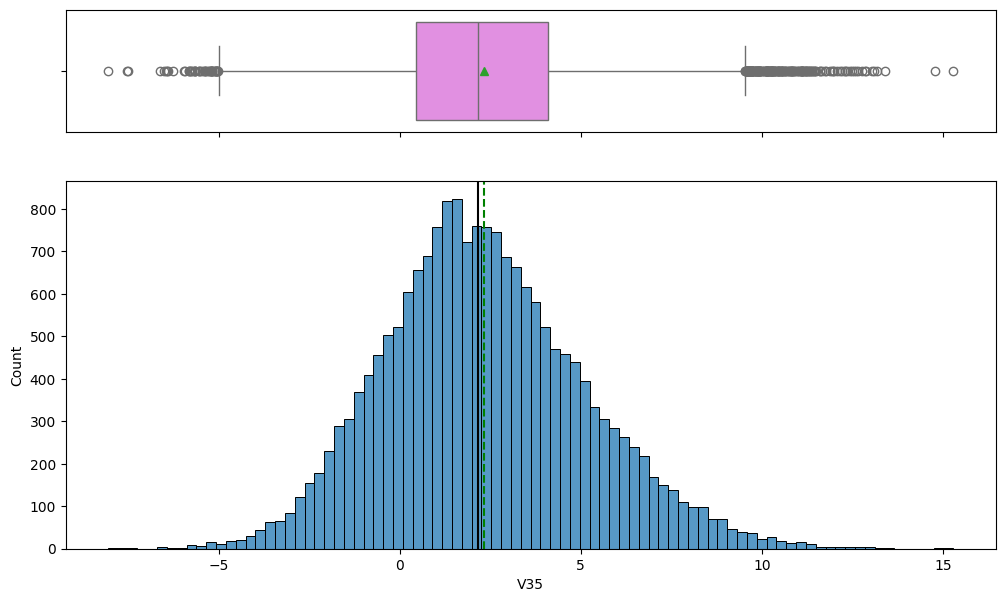

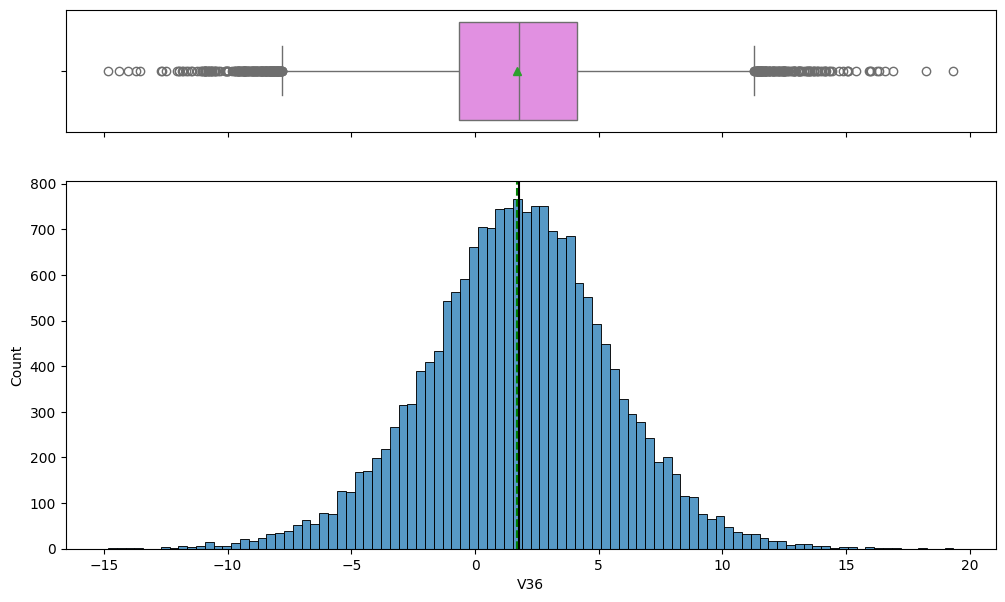

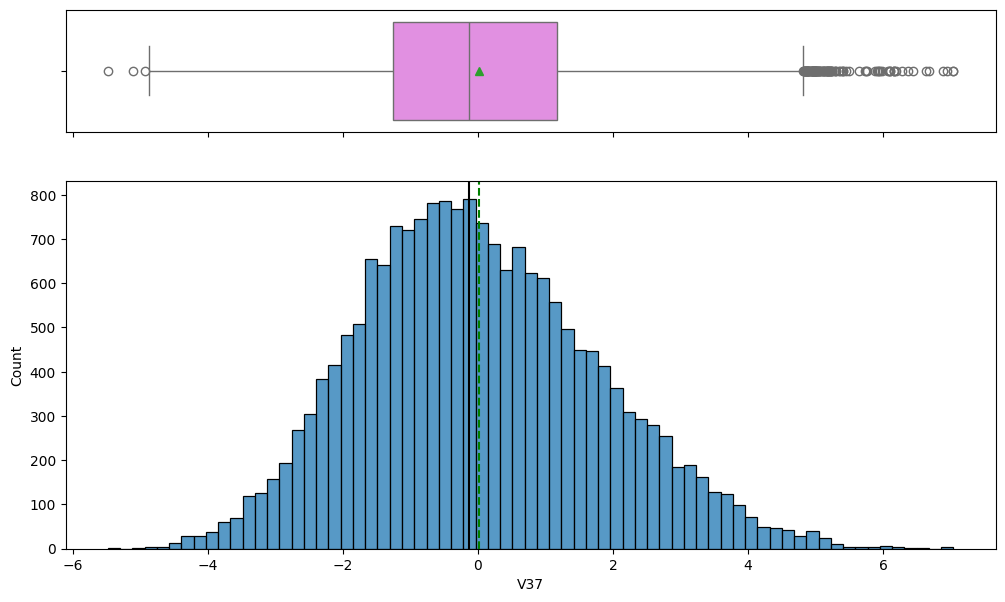

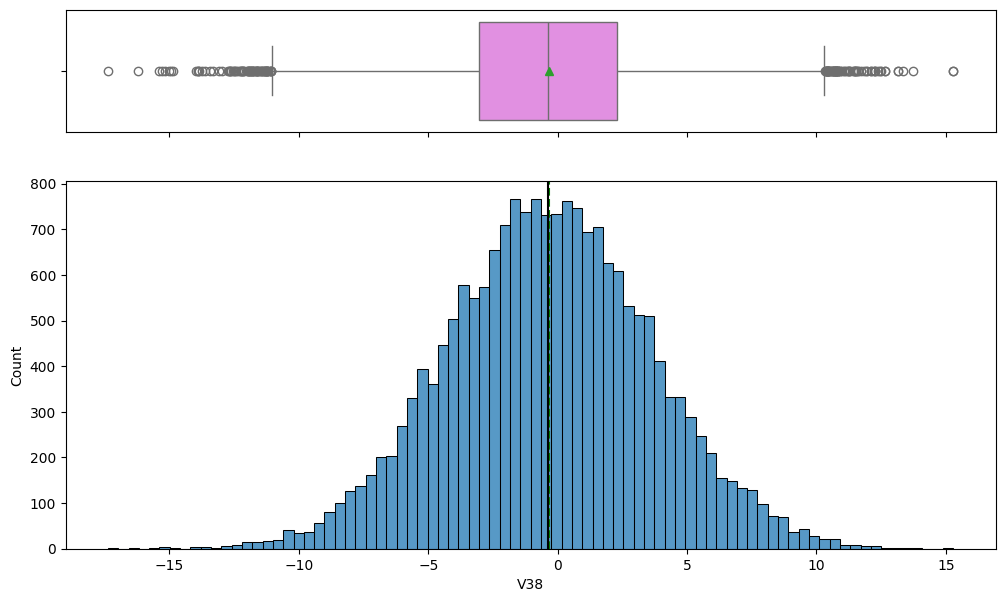

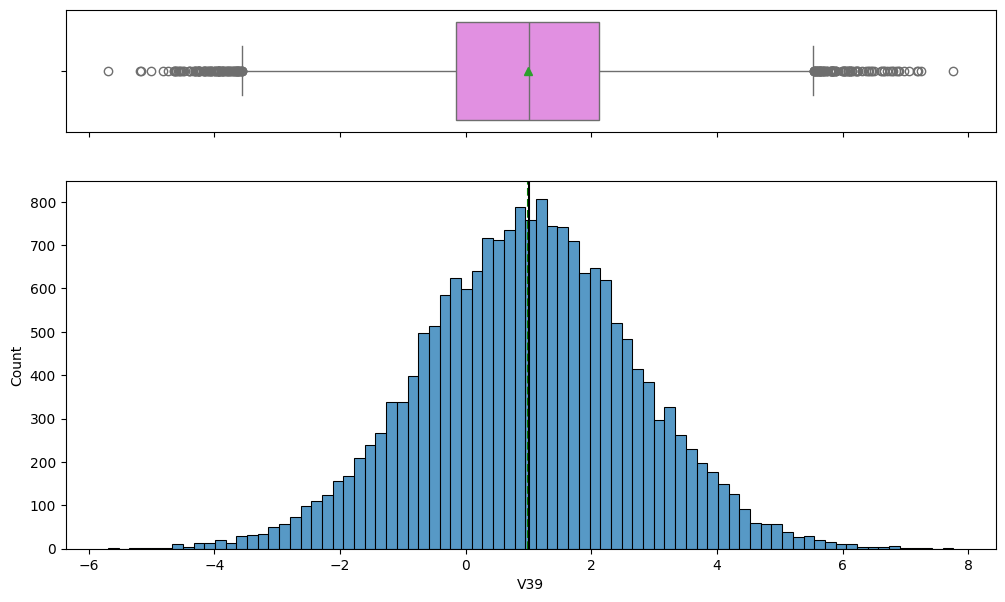

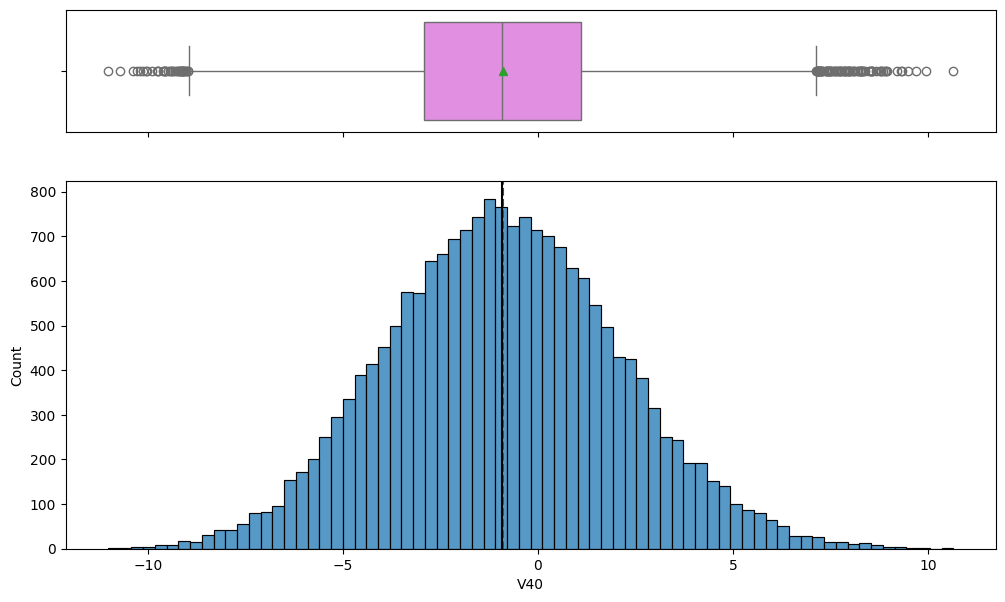

In [20]:
for feature in no_fail.columns[no_fail.dtypes=='float64']:
    histogram_boxplot(no_fail, feature, figsize=(12, 7), kde=False, bins=None)

## Data Pre-processing

In [21]:
# Separating target variable and other variables
X_train = df_train.drop(columns="Target")
Y_train = df_train["Target"]
X_test = df_test.drop(columns="Target")
y_test = df_test["Target"]

In [22]:
# Splitting data into training, validation, and test set:
# First, split data into two parts, temporary and test

# Then, split the temporary set into train and validation

X_train, X_val, y_train, y_val = train_test_split(
    X_train, Y_train, test_size=0.25, random_state=1, stratify=Y_train
)
print(X_train.shape, X_val.shape, X_test.shape)

(15000, 40) (5000, 40) (5000, 40)


In [23]:
print("Number of rows in train data =", X_train.shape[0])
print("Number of rows in validation data =", X_val.shape[0])
print("Number of rows in test data =", X_test.shape[0])

Number of rows in train data = 15000
Number of rows in validation data = 5000
Number of rows in test data = 5000


In [24]:
# creating an instace of the imputer to be used
imputer = SimpleImputer(strategy="median")

In [25]:
# replace the missing values in the train, validation, and test sets
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.fit_transform(X_val), columns=X_val.columns)
X_test = pd.DataFrame(imputer.fit_transform(X_test), columns=X_test.columns)

In [26]:
# verify there are no missing values in the training data
X_train.isna().sum()

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64

In [27]:
#verify there are no missing values in the validation data
X_val.isna().sum()

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64

In [28]:
#verify there are no missing values in the test data
X_test.isna().sum()

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64

- Data has been all prepped, with splitting and ensuring no missing values

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model.
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [29]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1

        },
        index=[0],
    )

    return df_perf

In [30]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [31]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

In [32]:
%%time

models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=3, shuffle=True, random_state=1
    )  # Setting number of splits equal to 3
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = f1_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

dtree: 0.7127236838687895
Bagging: 0.6946817996866045
Random forest: 0.7079145347981542
GBM: 0.711520314434373
Adaboost: 0.6345609433031193
Xgboost: 0.7992667238050714

Validation Performance:

dtree: 0.6962699822380106
Bagging: 0.8252032520325204
Random forest: 0.8364389233954451
GBM: 0.804
Adaboost: 0.7595959595959596
Xgboost: 0.9005847953216374
CPU times: user 1min 26s, sys: 1.61 s, total: 1min 27s
Wall time: 1min 20s


### Model Building with Oversampled data


In [33]:
print("Before Oversampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Oversampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print("After Oversampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After Oversampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))

print("After Oversampling, the shape of X_train: {}".format(X_train_over.shape))
print("After Oversampling, the shape of y_train: {} \n".format(y_train_over.shape))

Before Oversampling, counts of label 'Yes': 832
Before Oversampling, counts of label 'No': 14168 

After Oversampling, counts of label 'Yes': 14168
After Oversampling, counts of label 'No': 14168 

After Oversampling, the shape of X_train: (28336, 40)
After Oversampling, the shape of y_train: (28336,) 



In [34]:
%%time

models_over = []  # Empty list to store all the models

# Appending models into the list
models_over.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_over.append(("Bagging", BaggingClassifier(random_state=1)))
models_over.append(("Random forest", RandomForestClassifier(random_state=1)))
models_over.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_over.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_over.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1_over = []  # Empty list to store all model's CV scores
names_over = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models_over:
    kfold = StratifiedKFold(
        n_splits=3, shuffle=True, random_state=1
    )  # Setting number of splits equal to 3
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results1_over.append(cv_result)
    names_over.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_over:
    model.fit(X_train_over, y_train_over)
    scores = f1_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

dtree: 0.9676030338556392
Bagging: 0.971767532182232
Random forest: 0.9808724680042982
GBM: 0.9263832141377776
Adaboost: 0.8987859059255326
Xgboost: 0.9870130367047102

Validation Performance:

dtree: 0.6306569343065693
Bagging: 0.8197879858657244
Random forest: 0.8905660377358492
GBM: 0.7283582089552239
Adaboost: 0.5202185792349726
Xgboost: 0.8844036697247706
CPU times: user 2min 28s, sys: 4.83 s, total: 2min 33s
Wall time: 2min 23s


### Model Building with Undersampled data

In [35]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print("Before Undersampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before Undersampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

print("After Undersampling, counts of label 'Yes': {}".format(sum(y_train_under == 1)))
print("After Undersampling, counts of label 'No': {} \n".format(sum(y_train_under == 0)))

print("After Undersampling, the shape of X_train: {}".format(X_train_under.shape))
print("After Undersampling, the shape of y_train: {} \n".format(y_train_under.shape))

Before Undersampling, counts of label 'Yes': 832
Before Undersampling, counts of label 'No': 14168 

After Undersampling, counts of label 'Yes': 832
After Undersampling, counts of label 'No': 832 

After Undersampling, the shape of X_train: (1664, 40)
After Undersampling, the shape of y_train: (1664,) 



In [36]:
%%time

models_under = []  # Empty list to store all the models

# Appending models into the list
models_under.append(("dtree", DecisionTreeClassifier(random_state=1)))
models_under.append(("Bagging", BaggingClassifier(random_state=1)))
models_under.append(("Random forest", RandomForestClassifier(random_state=1)))
models_under.append(("GBM", GradientBoostingClassifier(random_state=1)))
models_under.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models_under.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))

results1_under = []  # Empty list to store all model's CV scores
names_under = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation Cost:" "\n")

for name, model in models_under:
    kfold = StratifiedKFold(
        n_splits=3, shuffle=True, random_state=1
    )  # Setting number of splits equal to 3
    cv_result = cross_val_score(
        estimator=model, X=X_train_under, y=y_train_under, scoring=scorer, cv=kfold
    )
    results1_under.append(cv_result)
    names_under.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models_under:
    model.fit(X_train_under, y_train_under)
    scores = f1_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation Cost:

dtree: 0.8497433100451047
Bagging: 0.8629803738236848
Random forest: 0.8990165268507216
GBM: 0.8990338415188427
Adaboost: 0.8774164783696509
Xgboost: 0.9050506886909245

Validation Performance:

dtree: 0.35589353612167307
Bagging: 0.5741399762752076
Random forest: 0.6526315789473683
GBM: 0.5866983372921616
Adaboost: 0.4350230414746544
Xgboost: 0.6831275720164609
CPU times: user 10.2 s, sys: 2.24 s, total: 12.5 s
Wall time: 6.05 s


### Observations
- With the original data, my top performing model is: XGBoost with an excellent recall score of: 0.900, identifying 90% of true positives and missing only 10%
- With the oversampled data, my top performing model is: Random Forest with an improved recall score of: 0.890, showing significantly better identification in true positives compared to original data.
- With the undersampled data, my top performing model is: XGBoost with a moderate recall score of : 0.683, the lowest performance for XGBoost across the sampling strategies but still better than many others.

**General Model Commentary:**

*XGBoost:* Performs best with original data but still performs well with oversampled data.

*Random Forest:* Benefits significantly from oversampling.

*Bagging:* Maintains high recall across original and oversampled data.

*Adaboost:* Performs poorly with oversampled and undersampled data; better with original data.

Considering the recall scores, original and oversampled data are preferable for achieving higher recall in most models, with XGBoost and Random Forest being the standout models for maximizing recall.

Other insights:
- For some reason, Adaboost in the oversampled data reported a recall score of 0.5202, a significant drop! This is indicative of poor performance, identifying only 52% of true positives.
- XGBoost in oversampled data reported a recall score of 0.8844, which was slightly lower than with original data but still very high recall, maintaining strong performance.
- The lowest recall score was from Decision Tree with the undersampled data at 0.3559, identifying only around 36% of true positives.
- Original data provides the best playing field for my machine learning models, as the overall highest recall scores were generated with that data.
- It can generally be observed that with the undersampled data, all models took a hit to their performances, and reporting decreased recall scores across the board.

## HyperparameterTuning

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7],
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1],
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6),
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

### Tuning XGBoost with original data

In [37]:
%%time

# Defining model
xb = XGBClassifier(random_state=1,eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

# Calling RandomizedSearchCV
xb_tuned = RandomizedSearchCV(estimator=xb, param_distributions=param_grid, n_iter=10, 
                              n_jobs = -1, scoring=scorer, cv=5, random_state=1)

# Fitting parameters in RandomizedSearchCV
xb_tuned.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(xb_tuned.best_params_,xb_tuned.best_score_))

Best parameters are {'subsample': 0.8, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.1, 'gamma': 5} with CV score=0.8546353076978572:
CPU times: user 2.17 s, sys: 771 ms, total: 2.94 s
Wall time: 5.91 s


In [38]:
# Creating new pipeline with best parameters
xb_tuned = XGBClassifier(
    subsample=0.9, 
    scale_pos_weight=10, 
    n_estimators=200, 
    learning_rate=0.2, 
    gamma=0,
    eval_metric="logloss",
    random_state=1
)

# Fit the model on undersampled training data
xb_tuned.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [39]:
# Calculating different metrics on train set
xb_grid_train = model_performance_classification_sklearn(
    xb_tuned, X_train, y_train
)
print("Training performance:")
xb_grid_train

Training performance:


Accuracy  Recall  Precision   F1
0      1.00    1.00       1.00 1.00

In [40]:
# Calculating different metrics on validation set
xb_grid_val = model_performance_classification_sklearn(
    xb_tuned, X_val, y_val
)
print("Validation performance:")
xb_grid_val

Validation performance:


Accuracy  Recall  Precision   F1
0      0.99    0.85       0.97 0.90

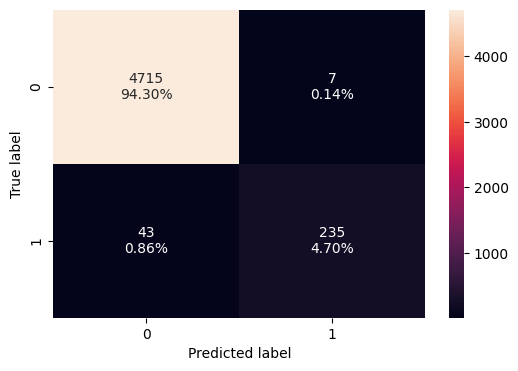

In [41]:
# Print confusion matrix
confusion_matrix_sklearn(xb_tuned, X_val, y_val)

### Tuning Random Forest with oversampled data

In [42]:
%%time

# defining model
rf = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

# Calling RandomizedSearchCV
rf_tuned_over = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, 
                              n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

# Fitting parameters in RandomizedSearchCV
rf_tuned_over.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(rf_tuned_over.best_params_, rf_tuned_over.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.6996248466921577:
CPU times: user 11.8 s, sys: 1.12 s, total: 13 s
Wall time: 50.6 s


In [43]:
# Creating new pipeline with best parameters
rf_tuned = RandomForestClassifier(
    n_estimators=300, 
    min_samples_leaf=1, 
    max_samples=0.6, 
    max_features='sqrt',
    random_state=1
)

# Fit the model on undersampled training data
rf_tuned.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.6, n_estimators=300, random_state=1)

In [45]:
# Calculating different metrics on train set
rf_grid_train_over = model_performance_classification_sklearn(
    rf_tuned, X_train, y_train
)
print("Training performance:")
rf_grid_train_over

Training performance:


Accuracy  Recall  Precision   F1
0      1.00    0.91       1.00 0.95

In [46]:
# calculating different metrics on validation set
rf_grid_val_over = model_performance_classification_sklearn(
    rf_tuned, X_val, y_val
)
print("Validation performance:")
rf_grid_val_over

Validation performance:


Accuracy  Recall  Precision   F1
0      0.98    0.71       0.99 0.83

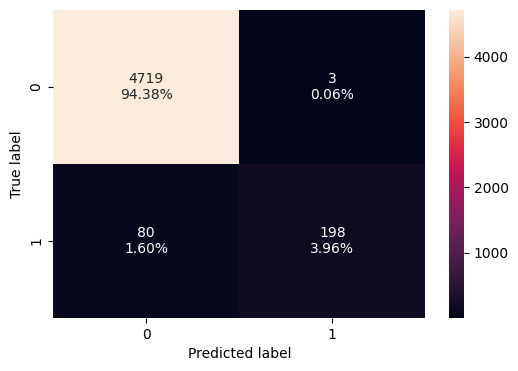

In [47]:
# print confusion matrix
confusion_matrix_sklearn(rf_tuned, X_val, y_val)

### Tuning XGBoost with oversampled data

In [48]:
%%time

# defining model
xb = XGBClassifier(random_state=1,eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

# Calling RandomizedSearchCV
xb_tuned_over = RandomizedSearchCV(estimator=xb, param_distributions=param_grid, n_iter=10, 
                              n_jobs = -1, scoring=scorer, cv=5, random_state=1)

# Fitting parameters in RandomizedSearchCV
xb_tuned_over.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(xb_tuned_over.best_params_,xb_tuned_over.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.2, 'gamma': 0} with CV score=0.9959769935987322:
CPU times: user 4.13 s, sys: 741 ms, total: 4.87 s
Wall time: 6.39 s


In [49]:
# Creating new pipeline with best parameters
xb_tuned_over = XGBClassifier(
    subsample=0.9, 
    scale_pos_weight=10, 
    n_estimators=200, 
    learning_rate=0.2, 
    gamma=0,
    eval_metric="logloss",
    random_state=1
)

# Fit the model on undersampled training data
xb_tuned_over.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.2, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, random_state=1, ...)

In [50]:
# Calculating different metrics on train set
xb_grid_train_over = model_performance_classification_sklearn(
    xb_tuned_over, X_train_over, y_train_over
)
print("Training performance:")
xb_grid_train_over

Training performance:


Accuracy  Recall  Precision   F1
0      1.00    1.00       1.00 1.00

In [55]:
# Calculating different metrics on validation set
xb_grid_val_over = model_performance_classification_sklearn(
    xb_tuned, X_val, y_val
)
print("Validation performance:")
xb_grid_val_over

Validation performance:


Accuracy  Recall  Precision   F1
0      0.99    0.85       0.97 0.90

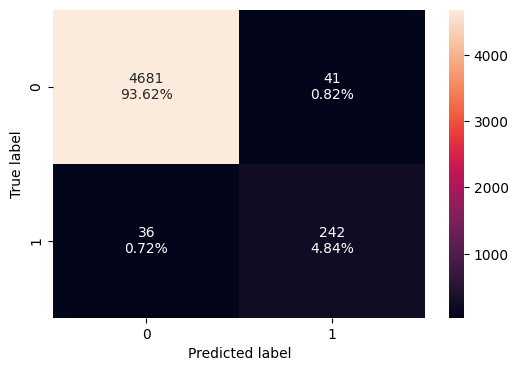

In [52]:
# print confusion matrix
confusion_matrix_sklearn(xb_tuned_over, X_val, y_val)

## Model performance comparison and choosing the final model

In [53]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        xb_grid_train.T,
        rf_grid_train_over.T,
        xb_grid_train_over.T
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "XGBoost with original data",
    "Random forest with oversampled data",
    "XGBoost with original data",
]
print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


XGBoost with original data  Random forest with oversampled data  \
Accuracy                         1.00                                 1.00   
Recall                           1.00                                 0.91   
Precision                        1.00                                 1.00   
F1                               1.00                                 0.95   

           XGBoost with original data  
Accuracy                         1.00  
Recall                           1.00  
Precision                        1.00  
F1                               1.00

In [56]:
# validation performance comparison

models_val_comp_df = pd.concat(
    [
        xb_grid_val.T,
        rf_grid_val_over.T,
        xb_grid_val_over.T
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "XGBoost with original data",
    "Random forest with oversampled data",
    "XGBoost with oversampled data"
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


XGBoost with original data  Random forest with oversampled data  \
Accuracy                         0.99                                 0.98   
Recall                           0.85                                 0.71   
Precision                        0.97                                 0.99   
F1                               0.90                                 0.83   

           XGBoost with oversampled data  
Accuracy                            0.99  
Recall                              0.85  
Precision                           0.97  
F1                                  0.90

- After tuning the top 3 models, the best overall performing tuned model according to F1 score is XGBoost with the original data, reporting at 0.88. 
- As a close second, when looking at the Recall score, XGBoost with oversampled data is 0.01 points higher than the same model with original data.

### Test set final performance

In [57]:
# calculating different metrics on validation set
xb_tuned_test_perf = model_performance_classification_sklearn(
    xb_tuned, X_test, y_test
)
print("Test performance:")
xb_tuned_test_perf

Test performance:


Accuracy  Recall  Precision   F1
0      0.99    0.84       0.96 0.90

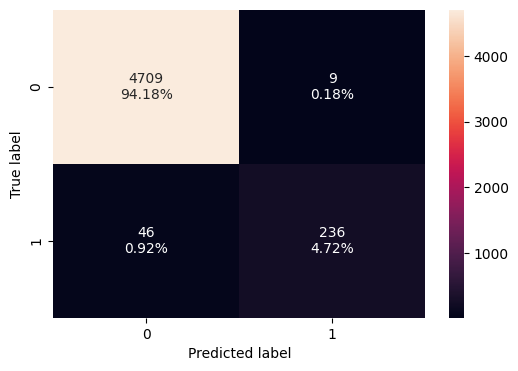

In [58]:
# print confusion matrix
confusion_matrix_sklearn(xb_tuned, X_test, y_test)

In [59]:
# calculate the cost without the model
act_cost_without = 40000*len(y_test[y_test==1])
print("The actual cost to ReneWind without the model would have been $"+"{:,}".format(act_cost_without))

The actual cost to ReneWind without the model would have been $11,280,000


In [60]:
# calculate the actual cost using the above confusion matrix from the XGBoost model
act_cost_with = 40000*45+(5000+15000)*237+5000*20
print("The actual cost for ReneWind after implementing the preventative maintenance model would have been $"
      +"{:,}".format(act_cost_with))

The actual cost for ReneWind after implementing the preventative maintenance model would have been $6,640,000


In [61]:
# calculate the actual cost difference
act_cost_savings = act_cost_without-act_cost_with
print("The actual cost savings were $"+"{:,}".format(act_cost_savings)+", an overall cost reduction of "+
      str(round(act_cost_savings/act_cost_without,3)*100)+"%")

The actual cost savings were $4,640,000, an overall cost reduction of 41.099999999999994%


- Implementing the XGBoost maintenance model would produce almost 42% in savings for the company!

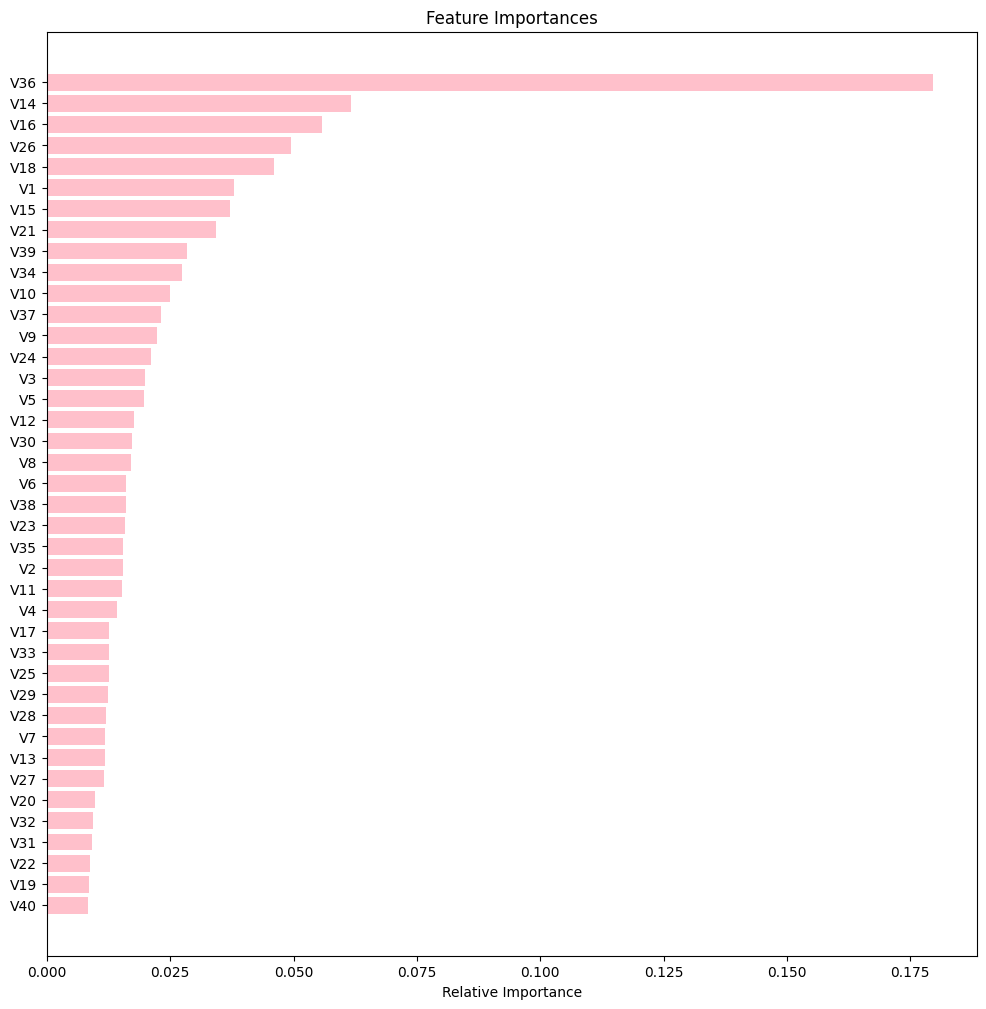

In [62]:
# show the most important features from the tuned XGBoost model, ranked from highest to lowest
feature_names = X_test.columns
importances = xb_tuned_over.feature_importances_
indices = np.argsort(importances)

# sort and plot feature importances
plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="pink", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- The top three most important sensors for predicting generator failure are `V36`, `V14`, and `V16`
- ReneWind would benefit from a deeper analysis of why these sensors are key in predicting generator failures.

## Pipelines to build the final model


In [63]:
"""create a pipeline that fills the missing values in a dataset, followed by the XGBoost model 
with the hyperparameters tuned from the oversampled data above"""
pipeline = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy="median")),
    ("RF", xb_tuned_over)])

In [64]:
# separate target variable from the other variables for both the training and test datasets
X1_train = df_train.drop(columns="Target")
y1_train = df_train["Target"]

X1_test = df_test.drop(columns="Target")
y1_test = df_test["Target"]

In [65]:
# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X1_train_over, y1_train_over = sm.fit_resample(X_train, y_train)

In [66]:
# fit the original training data to the XGBoost model
pipeline.fit(X1_train,y1_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('RF',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=0, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=1, ...))])

In [67]:
# use the pipeline to predict the failed generators within the testing data
pipeline.predict(X1_test)

array([0, 0, 0, ..., 0, 0, 0])

# Business Insights and Conclusions

To ReneWind, I suggest:
- Analyze the distributions and summary statistics of sensor data for both failing and non-failing generators. This analysis could reveal operational, engineering, or other root causes that the company can address to reduce failures across its wind turbines.
- Create a sort of communication system to the engineering team, which triggers an alarm relevant to the most important sensors if and when they near failing zone.
- A pipeline has been built to productionalize the final model that was chosen. If business plans change over time, the second runner-up model I would suggest is the Random Forest model with oversampled data, which reported highly on Accuracy and Precision, though only 0.83 on F1 as compared to our strongest model, XGBoost with original data. 
- XGBoost with oversampled data comes in third place, though tying with Random Forest model on the same data, fell short with Precision.
- The top three most important sensors for predicting generator failure are `V36`, `V14`, and `V16`
- The XGBoost model built from original data provided the highest F1 score across both the validation and testing data and performed similarly well on both, leading us to the conclusion that this model should generalize well in production. 
- Implementing the model as part of a preventative maintenance program, ReneWind can anticipate a reduction in maintenance costs for its generator fleet by more than _40%_.